In [94]:
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

In [163]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
train_df = pd.merge(X_train, y_train, on='id')
train_df = train_df.drop(['id'], axis=1)

train_df_0 = train_df[train_df['y'] == 0]
train_df_1 = train_df[train_df['y'] == 1]
train_df_2 = train_df[train_df['y'] == 2]
train_df_3 = train_df[train_df['y'] == 3]

train_df_0, val_df_0 = train_test_split(train_df_0, test_size=0.2, random_state=42)
train_df_1, val_df_1 = train_test_split(train_df_1, test_size=0.2, random_state=42)
train_df_2, val_df_2 = train_test_split(train_df_2, test_size=0.2, random_state=42)
train_df_3, val_df_3 = train_test_split(train_df_3, test_size=0.2, random_state=42)

train_df = pd.concat([train_df_0, train_df_1, train_df_2, train_df_3], axis=0)
val_df = pd.concat([val_df_0, val_df_1, val_df_2, val_df_3], axis=0)
train_y = train_df.pop('y')
val_y = val_df.pop('y')


39
              Signal  Index Label
-0.243525 -25.317506   2923    14
-0.240180 -21.710725   2924    14
-0.236834 -18.190120   2925    14
-0.233489 -14.588994   2926    14
-0.230144 -10.823987   2927    14
...              ...    ...   ...
 0.438880 -69.145062   3127    14
 0.442225 -64.775445   3128    14
 0.445570 -60.733665   3129    14
 0.448915 -57.047474   3130    14
 0.452260 -53.716845   3131    14

[209 rows x 3 columns]
39 38


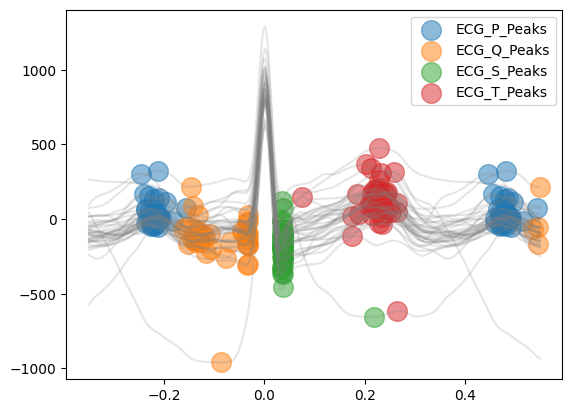

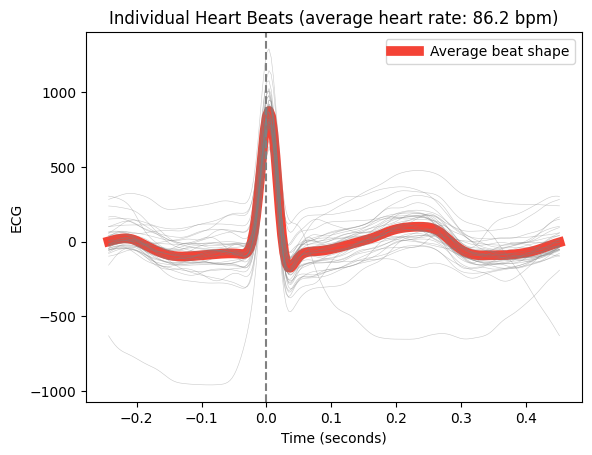

In [142]:
import neurokit2 as nk

sample_signal = train_df.iloc[1, :].values
sample_signal = sample_signal[~np.isnan(sample_signal)]

# Preprocess
signal_cleaned = nk.ecg_clean(sample_signal, sampling_rate=300)
#signal_processed, peaks = nk.ecg_process(signal_cleaned, sampling_rate=300)
_, peaks = nk.ecg_peaks(signal_cleaned, sampling_rate=300)
peaks = peaks['ECG_R_Peaks']
delineated, _ = nk.ecg_delineate(signal_cleaned, peaks, sampling_rate=300, show=True)

heart_rate = nk.signal_rate(peaks, sampling_rate=300)
mean_hr = np.mean(heart_rate)
std_hr = np.std(heart_rate)

#quality = delineated['ECG_Quality']
#mean_quality = np.mean(quality[quality != 0])
#std_quality = np.std(quality[quality != 0])

t_offsets = delineated['ECG_R_Offsets']
q_onsets = delineated['ECG_R_Onsets']
# get list of qt intervals


rr_intervals = np.diff(peaks)
mean_rr = np.mean(rr_intervals)
inv_var_rr = np.var(1 / rr_intervals)

#qrs_

segmented = nk.ecg_segment(signal_cleaned, peaks, sampling_rate=300, show=True)
#print(segmented)


for key in segmented:
    #print(key, segmented[key].shape)
    if segmented[key].isna().any().any():
        print(key)

#print(list(segmented.keys()))
print(segmented['14'])
#results = nk.ecg_eventrelated(segmented)
#results[]
signals = [k for k in list(segmented.items())[:-1]]
print(len(list(segmented.keys())), len(signals))

In [148]:
import neurokit2 as nk

def split_n_extract(signal, idx):
    signal_cleaned = nk.ecg_clean(signal, sampling_rate=300)
    _, peaks = nk.ecg_peaks(signal, sampling_rate=300)
    peaks = peaks['ECG_R_Peaks']

    heart_rate = nk.signal_rate(peaks, sampling_rate=300)
    mean_hr = np.mean(heart_rate)
    std_hr = np.std(heart_rate)

    rr_intervals = np.diff(peaks)
    mean_rr = np.mean(rr_intervals)
    inv_var_rr = np.var(1 / rr_intervals)

    segmented = nk.ecg_segment(signal_cleaned, peaks, sampling_rate=300, show=False)
    # average over segments
    segments = np.array([signal['Signal'] for signal in list(segmented.values())[:-1]])
    mu = np.mean(segments, axis=0)
    std = np.std(segments, axis=0)
    md = np.median(segments, axis=0)

    return [mean_hr, std_hr, mean_rr, inv_var_rr, mu, std, md]


train_processed = []
val_processed = []
for df_name, df, processed in zip(['train', 'val'], [train_df, val_df], [train_processed, val_processed]):
    for i, (idx, row) in enumerate(tqdm(df.iterrows(), total=len(df))):
        if i in [2882,2939,3348] and df_name == 'train':
            train_y = train_y.drop([idx]) # remove corresponding y
            continue
        signal = row.values
        signal = signal[~np.isnan(signal)]
        processed.append(split_n_extract(signal, idx))

train_processed = pd.DataFrame(train_processed, columns=['mean_hr', 'std_hr', 'mean_rr', 'inv_var_rr', 'mu', 'std', 'md'])
train_processed['y'] = train_y
val_processed = pd.DataFrame(val_processed, columns=['mean_hr', 'std_hr', 'mean_rr', 'inv_var_rr', 'mu', 'std', 'md'])
val_processed['y'] = val_y

 40%|████      | 1096/2727 [00:18<00:26, 62.57it/s]/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide

ValueError: cannot convert float NaN to integer

In [49]:
def R_correction(signal, peaks):
    num_peaks = peaks.shape[0]
    peaks_corrected_list = []

    for index in range(num_peaks):
        i = peaks[index]
        cnt = i

        if cnt - 1 < 0:
            break

        if signal[cnt] < signal[cnt - 1]:
            while cnt > 0 and signal[cnt] < signal[cnt - 1]:
                cnt -= 1
        elif cnt + 1 < len(signal) and signal[cnt] < signal[cnt + 1]:
            while cnt + 1 < len(signal) and signal[cnt] < signal[cnt + 1]:
                cnt += 1

        peaks_corrected_list.append(cnt)

    peaks_corrected = np.asarray(peaks_corrected_list)
    return peaks_corrected


from ecgdetectors import Detectors # pip install py-ecg-detectors
detectors = Detectors(300)

Processing train set:   0%|          | 0/4093 [00:00<?, ?it/s]/tmp/ipykernel_808822/3937424030.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  r_peaks = np.array([r_peaks_christov, r_peaks_hamilton, r_peaks_engzee, r_peaks_twoavg, r_peaks_tompkins])[np.argmax(lengths)]
Processing train set:   0%|          | 1/4093 [00:00<27:56,  2.44it/s]

(33, 180)
(15, 180)


Processing train set:   0%|          | 4/4093 [00:00<10:37,  6.42it/s]

(70, 180)
(38, 180)


Processing train set:   0%|          | 6/4093 [00:00<08:25,  8.08it/s]

(36, 180)
(26, 180)
(26, 180)


Processing train set:   0%|          | 10/4093 [00:01<06:03, 11.24it/s]

(31, 180)
(26, 180)
(10, 180)


Processing train set:   0%|          | 12/4093 [00:01<06:06, 11.14it/s]

(30, 180)
(32, 180)
(33, 180)


Processing train set:   0%|          | 16/4093 [00:01<05:47, 11.74it/s]

(17, 180)
(26, 180)
(36, 180)


Processing train set:   0%|          | 18/4093 [00:01<06:47, 10.01it/s]

(56, 180)
(28, 180)


Processing train set:   0%|          | 20/4093 [00:02<07:28,  9.09it/s]

(62, 180)
(34, 180)
(39, 180)


Processing train set:   1%|          | 24/4093 [00:02<06:16, 10.81it/s]

(32, 180)
(16, 180)
(25, 180)
(24, 180)


Processing train set:   1%|          | 26/4093 [00:02<05:57, 11.37it/s]

(31, 180)
(30, 180)


Processing train set:   1%|          | 30/4093 [00:03<06:37, 10.21it/s]

(61, 180)
(40, 180)
(36, 180)


Processing train set:   1%|          | 32/4093 [00:03<06:27, 10.48it/s]

(31, 180)
(35, 180)


Processing train set:   1%|          | 34/4093 [00:03<06:34, 10.28it/s]

(54, 180)
(42, 180)
(37, 180)


Processing train set:   1%|          | 38/4093 [00:03<06:19, 10.68it/s]

(26, 180)
(30, 180)
(41, 180)


Processing train set:   1%|          | 40/4093 [00:04<06:17, 10.73it/s]

(35, 180)
(35, 180)
(13, 180)


Processing train set:   1%|          | 44/4093 [00:04<05:46, 11.67it/s]

(34, 180)
(39, 180)
(37, 180)


Processing train set:   1%|          | 46/4093 [00:04<05:54, 11.42it/s]

(31, 180)
(35, 180)
(30, 180)


Processing train set:   1%|          | 50/4093 [00:04<05:57, 11.31it/s]

(35, 180)
(50, 180)
(37, 180)


Processing train set:   1%|▏         | 52/4093 [00:05<05:52, 11.48it/s]

(30, 180)
(38, 180)
(38, 180)


Processing train set:   1%|▏         | 56/4093 [00:05<05:43, 11.76it/s]

(34, 180)
(22, 180)
(34, 180)
(11, 180)


Processing train set:   1%|▏         | 60/4093 [00:05<05:29, 12.24it/s]

(39, 180)
(31, 180)
(39, 180)


Processing train set:   2%|▏         | 62/4093 [00:05<06:35, 10.20it/s]

(64, 180)
(33, 180)


Processing train set:   2%|▏         | 64/4093 [00:06<06:40, 10.06it/s]

(50, 180)
(36, 180)
(29, 180)


Processing train set:   2%|▏         | 66/4093 [00:06<06:54,  9.72it/s]

(54, 180)
(26, 180)


Processing train set:   2%|▏         | 69/4093 [00:06<07:20,  9.13it/s]

(58, 180)
(40, 180)
(40, 180)


Processing train set:   2%|▏         | 73/4093 [00:07<06:37, 10.10it/s]

(35, 180)
(31, 180)
(38, 180)


Processing train set:   2%|▏         | 75/4093 [00:07<06:27, 10.38it/s]

(34, 180)
(34, 180)
(31, 180)


Processing train set:   2%|▏         | 79/4093 [00:07<06:16, 10.67it/s]

(34, 180)
(47, 180)
(33, 180)


Processing train set:   2%|▏         | 81/4093 [00:07<06:09, 10.85it/s]

(37, 180)
(33, 180)
(35, 180)


Processing train set:   2%|▏         | 85/4093 [00:08<06:01, 11.10it/s]

(42, 180)
(33, 180)
(30, 180)


Processing train set:   2%|▏         | 87/4093 [00:08<07:41,  8.68it/s]

(77, 180)
(58, 180)


Processing train set:   2%|▏         | 90/4093 [00:08<06:57,  9.59it/s]

(33, 180)
(31, 180)
(41, 180)


Processing train set:   2%|▏         | 92/4093 [00:08<05:54, 11.30it/s]

(31, 180)
(15, 180)
(39, 180)


Processing train set:   2%|▏         | 96/4093 [00:09<05:55, 11.26it/s]

(32, 180)
(35, 180)
(32, 180)


Processing train set:   2%|▏         | 98/4093 [00:09<05:57, 11.18it/s]

(33, 180)
(31, 180)
(42, 180)


Processing train set:   2%|▏         | 102/4093 [00:09<06:05, 10.92it/s]

(29, 180)
(40, 180)
(36, 180)


Processing train set:   3%|▎         | 104/4093 [00:10<06:05, 10.92it/s]

(44, 180)
(35, 180)
(33, 180)


Processing train set:   3%|▎         | 106/4093 [00:10<06:01, 11.02it/s]

(34, 180)
(42, 180)


Processing train set:   3%|▎         | 110/4093 [00:10<06:40,  9.95it/s]

(78, 180)
(33, 180)
(28, 180)


Processing train set:   3%|▎         | 112/4093 [00:10<06:51,  9.67it/s]

(33, 180)
(48, 180)


Processing train set:   3%|▎         | 114/4093 [00:11<07:31,  8.81it/s]

(37, 180)
(65, 180)


Processing train set:   3%|▎         | 116/4093 [00:11<06:44,  9.83it/s]

(26, 180)
(38, 180)
(24, 180)


Processing train set:   3%|▎         | 120/4093 [00:11<05:57, 11.13it/s]

(58, 180)
(31, 180)
(13, 180)
(19, 180)


Processing train set:   3%|▎         | 122/4093 [00:11<05:28, 12.10it/s]

(26, 180)
(28, 180)


Processing train set:   3%|▎         | 126/4093 [00:12<06:13, 10.62it/s]

(70, 180)
(32, 180)
(34, 180)


Processing train set:   3%|▎         | 128/4093 [00:12<06:09, 10.72it/s]

(39, 180)
(30, 180)
(41, 180)


Processing train set:   3%|▎         | 132/4093 [00:12<05:44, 11.51it/s]

(32, 180)
(43, 180)
(21, 180)


Processing train set:   3%|▎         | 134/4093 [00:12<05:57, 11.06it/s]

(39, 180)
(30, 180)
(30, 180)


Processing train set:   3%|▎         | 136/4093 [00:13<05:57, 11.06it/s]

(43, 180)
(30, 180)


Processing train set:   3%|▎         | 140/4093 [00:13<06:07, 10.76it/s]

(64, 180)
(20, 180)
(29, 180)


Processing train set:   3%|▎         | 142/4093 [00:13<05:33, 11.83it/s]

(29, 180)
(16, 180)
(34, 180)


Processing train set:   4%|▎         | 146/4093 [00:13<05:38, 11.64it/s]

(31, 180)
(45, 180)
(31, 180)


Processing train set:   4%|▎         | 148/4093 [00:14<06:35,  9.98it/s]

(68, 180)
(37, 180)
(26, 180)


Processing train set:   4%|▎         | 152/4093 [00:14<06:10, 10.64it/s]

(34, 180)
(48, 180)
(31, 180)


Processing train set:   4%|▍         | 154/4093 [00:14<06:53,  9.52it/s]

(61, 180)
(36, 180)
(34, 180)


Processing train set:   4%|▍         | 156/4093 [00:15<06:34,  9.99it/s]

(27, 180)
(32, 180)


Processing train set:   4%|▍         | 160/4093 [00:15<06:45,  9.70it/s]

(55, 180)
(36, 180)
(33, 180)


Processing train set:   4%|▍         | 162/4093 [00:15<06:45,  9.69it/s]

(50, 180)
(39, 180)
(31, 180)


Processing train set:   4%|▍         | 164/4093 [00:15<06:25, 10.19it/s]

(39, 180)
(35, 180)


Processing train set:   4%|▍         | 167/4093 [00:16<07:27,  8.78it/s]

(63, 180)
(46, 180)


Processing train set:   4%|▍         | 169/4093 [00:16<06:55,  9.46it/s]

(31, 180)
(42, 180)
(35, 180)


Processing train set:   4%|▍         | 174/4093 [00:16<06:05, 10.71it/s]

(61, 180)
(27, 180)
(14, 180)
(33, 180)


Processing train set:   4%|▍         | 176/4093 [00:17<06:51,  9.52it/s]

(67, 180)
(31, 180)
(35, 180)


Processing train set:   4%|▍         | 180/4093 [00:17<06:19, 10.32it/s]

(34, 180)
(40, 180)
(34, 180)


Processing train set:   4%|▍         | 182/4093 [00:17<06:42,  9.73it/s]

(31, 180)
(48, 180)


Processing train set:   4%|▍         | 184/4093 [00:18<07:17,  8.94it/s]

(73, 180)
(29, 180)
(31, 180)


Processing train set:   5%|▍         | 188/4093 [00:18<06:06, 10.64it/s]

(28, 180)
(21, 180)
(30, 180)


Processing train set:   5%|▍         | 190/4093 [00:18<06:01, 10.80it/s]

(38, 180)
(28, 180)
(35, 180)


Processing train set:   5%|▍         | 192/4093 [00:18<05:59, 10.85it/s]

(36, 180)
(79, 180)


Processing train set:   5%|▍         | 196/4093 [00:19<06:07, 10.60it/s]

(36, 180)
(17, 180)
(35, 180)
(23, 180)


Processing train set:   5%|▍         | 200/4093 [00:19<05:45, 11.28it/s]

(28, 180)
(37, 180)
(37, 180)


Processing train set:   5%|▍         | 202/4093 [00:19<06:32,  9.91it/s]

(47, 180)
(33, 180)
(32, 180)


Processing train set:   5%|▍         | 204/4093 [00:19<06:16, 10.32it/s]

(25, 180)
(54, 180)


Processing train set:   5%|▌         | 208/4093 [00:20<06:32,  9.89it/s]

(32, 180)
(38, 180)
(31, 180)
(11, 180)


Processing train set:   5%|▌         | 212/4093 [00:20<05:43, 11.31it/s]

(32, 180)
(30, 180)
(35, 180)


Processing train set:   5%|▌         | 214/4093 [00:20<05:12, 12.42it/s]

(27, 180)
(15, 180)
(37, 180)


Processing train set:   5%|▌         | 216/4093 [00:20<05:50, 11.05it/s]

(58, 180)
(27, 180)


Processing train set:   5%|▌         | 218/4093 [00:21<06:42,  9.62it/s]

(73, 180)
(36, 180)


Processing train set:   5%|▌         | 222/4093 [00:21<06:49,  9.45it/s]

(56, 180)
(40, 180)
(25, 180)


Processing train set:   5%|▌         | 224/4093 [00:21<06:24, 10.06it/s]

(26, 180)
(29, 180)
(31, 180)


Processing train set:   6%|▌         | 228/4093 [00:22<06:03, 10.65it/s]

(37, 180)
(31, 180)
(32, 180)


Processing train set:   6%|▌         | 230/4093 [00:22<06:04, 10.60it/s]

(31, 180)
(41, 180)
(31, 180)


Processing train set:   6%|▌         | 234/4093 [00:22<05:24, 11.90it/s]

(31, 180)
(15, 180)
(28, 180)


Processing train set:   6%|▌         | 236/4093 [00:22<06:16, 10.25it/s]

(52, 180)
(42, 180)
(30, 180)


Processing train set:   6%|▌         | 240/4093 [00:23<05:57, 10.77it/s]

(23, 180)
(27, 180)
(40, 180)


Processing train set:   6%|▌         | 242/4093 [00:23<06:24, 10.02it/s]

(31, 180)
(47, 180)


Processing train set:   6%|▌         | 244/4093 [00:23<06:57,  9.23it/s]

(37, 180)
(70, 180)


Processing train set:   6%|▌         | 246/4093 [00:23<06:26,  9.95it/s]

(27, 180)
(40, 180)
(34, 180)


Processing train set:   6%|▌         | 250/4093 [00:24<06:07, 10.45it/s]

(39, 180)
(46, 180)
(36, 180)


Processing train set:   6%|▌         | 252/4093 [00:24<06:03, 10.56it/s]

(38, 180)
(33, 180)
(37, 180)


Processing train set:   6%|▋         | 256/4093 [00:24<05:19, 11.99it/s]

(35, 180)
(12, 180)
(35, 180)


Processing train set:   6%|▋         | 258/4093 [00:24<05:01, 12.72it/s]

(34, 180)
(15, 180)
(30, 180)


Processing train set:   6%|▋         | 262/4093 [00:25<05:22, 11.88it/s]

(40, 180)
(33, 180)
(32, 180)


Processing train set:   6%|▋         | 264/4093 [00:25<05:26, 11.73it/s]

(35, 180)
(34, 180)
(32, 180)


Processing train set:   6%|▋         | 266/4093 [00:25<06:25,  9.92it/s]

(57, 180)
(30, 180)


Processing train set:   7%|▋         | 270/4093 [00:26<06:32,  9.74it/s]

(79, 180)
(30, 180)
(30, 180)


Processing train set:   7%|▋         | 272/4093 [00:26<06:12, 10.25it/s]

(28, 180)
(29, 180)
(26, 180)


Processing train set:   7%|▋         | 276/4093 [00:26<05:36, 11.36it/s]

(23, 180)
(31, 180)
(36, 180)


Processing train set:   7%|▋         | 278/4093 [00:26<05:39, 11.25it/s]

(37, 180)
(33, 180)
(40, 180)


Processing train set:   7%|▋         | 282/4093 [00:27<05:35, 11.35it/s]

(39, 180)
(35, 180)
(31, 180)


Processing train set:   7%|▋         | 284/4093 [00:27<06:00, 10.58it/s]

(31, 180)
(48, 180)


Processing train set:   7%|▋         | 286/4093 [00:27<05:42, 11.10it/s]

(29, 180)
(29, 180)
(35, 180)


Processing train set:   7%|▋         | 290/4093 [00:27<05:04, 12.47it/s]

(34, 180)
(19, 180)
(26, 180)
(33, 180)


Processing train set:   7%|▋         | 294/4093 [00:28<05:05, 12.44it/s]

(27, 180)
(30, 180)
(33, 180)


Processing train set:   7%|▋         | 296/4093 [00:28<05:14, 12.09it/s]

(38, 180)
(26, 180)
(30, 180)


Processing train set:   7%|▋         | 298/4093 [00:28<05:14, 12.06it/s]

(31, 180)
(39, 180)


Processing train set:   7%|▋         | 302/4093 [00:28<05:26, 11.61it/s]

(86, 180)
(11, 180)
(35, 180)


Processing train set:   7%|▋         | 304/4093 [00:29<05:31, 11.44it/s]

(35, 180)
(34, 180)
(30, 180)


Processing train set:   8%|▊         | 308/4093 [00:29<05:37, 11.23it/s]

(37, 180)
(39, 180)
(28, 180)


Processing train set:   8%|▊         | 310/4093 [00:29<06:21,  9.92it/s]

(34, 180)
(74, 180)


Processing train set:   8%|▊         | 312/4093 [00:29<06:08, 10.26it/s]

(41, 180)
(30, 180)
(35, 180)


Processing train set:   8%|▊         | 316/4093 [00:30<05:53, 10.69it/s]

(32, 180)
(36, 180)
(38, 180)


Processing train set:   8%|▊         | 318/4093 [00:30<05:47, 10.87it/s]

(33, 180)
(38, 180)
(30, 180)


Processing train set:   8%|▊         | 322/4093 [00:30<05:39, 11.10it/s]

(39, 180)
(26, 180)
(32, 180)


Processing train set:   8%|▊         | 324/4093 [00:30<05:38, 11.14it/s]

(27, 180)
(38, 180)
(32, 180)


Processing train set:   8%|▊         | 328/4093 [00:31<06:12, 10.11it/s]

(93, 180)
(30, 180)
(34, 180)


Processing train set:   8%|▊         | 330/4093 [00:31<06:01, 10.42it/s]

(33, 180)
(29, 180)
(39, 180)


Processing train set:   8%|▊         | 333/4093 [00:32<07:28,  8.39it/s]

(67, 180)
(87, 180)


Processing train set:   8%|▊         | 335/4093 [00:32<06:48,  9.19it/s]

(31, 180)
(36, 180)
(37, 180)


Processing train set:   8%|▊         | 338/4093 [00:32<07:29,  8.36it/s]

(32, 180)
(71, 180)


Processing train set:   8%|▊         | 340/4093 [00:32<06:20,  9.87it/s]

(19, 180)
(28, 180)
(38, 180)


Processing train set:   8%|▊         | 342/4093 [00:32<06:11, 10.11it/s]

(38, 180)
(28, 180)


Processing train set:   8%|▊         | 346/4093 [00:33<06:26,  9.69it/s]

(109, 180)
(34, 180)
(29, 180)


Processing train set:   9%|▊         | 348/4093 [00:33<06:58,  8.96it/s]

(72, 180)
(32, 180)
(32, 180)


Processing train set:   9%|▊         | 352/4093 [00:33<06:09, 10.13it/s]

(31, 180)
(27, 180)
(36, 180)


Processing train set:   9%|▊         | 354/4093 [00:34<06:07, 10.18it/s]

(38, 180)
(37, 180)
(37, 180)


Processing train set:   9%|▊         | 358/4093 [00:34<06:02, 10.31it/s]

(30, 180)
(32, 180)
(43, 180)


Processing train set:   9%|▉         | 360/4093 [00:34<05:24, 11.50it/s]

(33, 180)
(14, 180)
(31, 180)


Processing train set:   9%|▉         | 364/4093 [00:35<05:26, 11.41it/s]

(29, 180)
(35, 180)
(32, 180)


Processing train set:   9%|▉         | 366/4093 [00:35<06:16,  9.90it/s]

(78, 180)
(29, 180)


Processing train set:   9%|▉         | 368/4093 [00:35<06:52,  9.03it/s]

(73, 180)
(30, 180)
(29, 180)


Processing train set:   9%|▉         | 372/4093 [00:35<06:11, 10.00it/s]

(34, 180)
(47, 180)
(36, 180)


Processing train set:   9%|▉         | 374/4093 [00:36<06:02, 10.26it/s]

(38, 180)
(44, 180)
(28, 180)


Processing train set:   9%|▉         | 378/4093 [00:36<06:22,  9.72it/s]

(72, 180)
(33, 180)
(31, 180)


Processing train set:   9%|▉         | 380/4093 [00:36<06:05, 10.17it/s]

(38, 180)
(26, 180)
(32, 180)


Processing train set:   9%|▉         | 384/4093 [00:37<05:30, 11.23it/s]

(19, 180)
(27, 180)
(36, 180)


Processing train set:   9%|▉         | 386/4093 [00:37<05:32, 11.15it/s]

(44, 180)
(33, 180)
(34, 180)


Processing train set:  10%|▉         | 390/4093 [00:37<05:26, 11.35it/s]

(35, 180)
(39, 180)
(26, 180)


Processing train set:  10%|▉         | 392/4093 [00:37<05:27, 11.29it/s]

(30, 180)
(31, 180)


Processing train set:  10%|▉         | 394/4093 [00:37<06:14,  9.88it/s]

(59, 180)
(41, 180)
(38, 180)


Processing train set:  10%|▉         | 399/4093 [00:38<05:12, 11.82it/s]

(33, 180)
(24, 180)
(14, 180)
(45, 180)


Processing train set:  10%|▉         | 401/4093 [00:38<05:16, 11.65it/s]

(31, 180)
(33, 180)
(35, 180)


Processing train set:  10%|▉         | 405/4093 [00:38<05:15, 11.70it/s]

(28, 180)
(27, 180)
(37, 180)


Processing train set:  10%|▉         | 407/4093 [00:39<06:02, 10.18it/s]

(41, 180)
(53, 180)


Processing train set:  10%|█         | 411/4093 [00:39<05:04, 12.10it/s]

(28, 180)
(26, 180)
(37, 180)
(18, 180)


Processing train set:  10%|█         | 413/4093 [00:39<05:05, 12.05it/s]

(27, 180)
(31, 180)


Processing train set:  10%|█         | 415/4093 [00:39<05:37, 10.89it/s]

(68, 180)
(19, 180)
(32, 180)


Processing train set:  10%|█         | 419/4093 [00:40<06:05, 10.06it/s]

(64, 180)
(38, 180)
(37, 180)


Processing train set:  10%|█         | 423/4093 [00:40<05:06, 11.99it/s]

(38, 180)
(30, 180)
(34, 180)
(12, 180)


Processing train set:  10%|█         | 425/4093 [00:40<05:10, 11.80it/s]

(38, 180)
(32, 180)


Processing train set:  10%|█         | 427/4093 [00:40<06:02, 10.11it/s]

(61, 180)
(34, 180)


Processing train set:  10%|█         | 429/4093 [00:41<06:36,  9.24it/s]

(52, 180)
(36, 180)
(33, 180)


Processing train set:  11%|█         | 433/4093 [00:41<06:02, 10.10it/s]

(35, 180)
(35, 180)
(32, 180)


Processing train set:  11%|█         | 435/4093 [00:41<05:55, 10.29it/s]

(42, 180)
(42, 180)


Processing train set:  11%|█         | 437/4093 [00:42<06:21,  9.59it/s]

(67, 180)
(26, 180)
(36, 180)


Processing train set:  11%|█         | 441/4093 [00:42<05:49, 10.46it/s]

(32, 180)
(39, 180)
(32, 180)


Processing train set:  11%|█         | 443/4093 [00:42<06:30,  9.36it/s]

(39, 180)
(73, 180)


Processing train set:  11%|█         | 445/4093 [00:42<07:02,  8.63it/s]

(39, 180)
(56, 180)


Processing train set:  11%|█         | 447/4093 [00:43<06:30,  9.35it/s]

(28, 180)
(26, 180)
(20, 180)


Processing train set:  11%|█         | 449/4093 [00:43<05:54, 10.29it/s]

(41, 180)
(62, 180)


Processing train set:  11%|█         | 453/4093 [00:43<06:07,  9.89it/s]

(43, 180)
(28, 180)
(31, 180)


Processing train set:  11%|█         | 455/4093 [00:43<06:34,  9.21it/s]

(66, 180)
(26, 180)
(31, 180)


Processing train set:  11%|█         | 459/4093 [00:44<05:58, 10.15it/s]

(40, 180)
(29, 180)
(32, 180)


Processing train set:  11%|█▏        | 461/4093 [00:44<05:46, 10.47it/s]

(32, 180)
(30, 180)
(30, 180)


Processing train set:  11%|█▏        | 465/4093 [00:44<05:27, 11.06it/s]

(26, 180)
(38, 180)
(32, 180)


Processing train set:  11%|█▏        | 467/4093 [00:44<05:23, 11.21it/s]

(26, 180)
(33, 180)
(40, 180)


Processing train set:  11%|█▏        | 469/4093 [00:45<05:50, 10.35it/s]

(60, 180)
(61, 180)


Processing train set:  12%|█▏        | 473/4093 [00:45<06:01, 10.03it/s]

(30, 180)
(29, 180)
(29, 180)


Processing train set:  12%|█▏        | 475/4093 [00:45<05:48, 10.39it/s]

(34, 180)
(28, 180)
(30, 180)


Processing train set:  12%|█▏        | 477/4093 [00:45<05:22, 11.23it/s]

(45, 180)
(46, 180)


Processing train set:  12%|█▏        | 481/4093 [00:46<05:43, 10.51it/s]

(61, 180)
(25, 180)
(37, 180)


Processing train set:  12%|█▏        | 483/4093 [00:46<05:37, 10.69it/s]

(35, 180)
(36, 180)
(35, 180)


Processing train set:  12%|█▏        | 487/4093 [00:46<05:57, 10.10it/s]

(57, 180)
(29, 180)
(29, 180)


Processing train set:  12%|█▏        | 489/4093 [00:47<05:48, 10.34it/s]

(30, 180)
(31, 180)
(36, 180)


Processing train set:  12%|█▏        | 493/4093 [00:47<05:29, 10.94it/s]

(30, 180)
(25, 180)
(26, 180)


Processing train set:  12%|█▏        | 495/4093 [00:47<05:04, 11.83it/s]

(35, 180)
(17, 180)
(30, 180)


Processing train set:  12%|█▏        | 499/4093 [00:48<05:33, 10.77it/s]

(76, 180)
(36, 180)
(23, 180)


Processing train set:  12%|█▏        | 501/4093 [00:48<06:14,  9.59it/s]

(29, 180)
(57, 180)


Processing train set:  12%|█▏        | 503/4093 [00:48<06:44,  8.87it/s]

(31, 180)
(59, 180)


Processing train set:  12%|█▏        | 505/4093 [00:48<05:51, 10.21it/s]

(44, 180)
(13, 180)
(42, 180)


Processing train set:  12%|█▏        | 509/4093 [00:49<05:35, 10.69it/s]

(42, 180)
(38, 180)
(31, 180)


Processing train set:  12%|█▏        | 511/4093 [00:49<05:05, 11.74it/s]

(16, 180)
(38, 180)
(36, 180)


Processing train set:  13%|█▎        | 515/4093 [00:49<05:06, 11.69it/s]

(29, 180)
(33, 180)
(32, 180)


Processing train set:  13%|█▎        | 517/4093 [00:49<04:51, 12.26it/s]

(19, 180)
(39, 180)
(28, 180)


Processing train set:  13%|█▎        | 521/4093 [00:50<05:02, 11.82it/s]

(41, 180)
(25, 180)
(27, 180)


Processing train set:  13%|█▎        | 523/4093 [00:50<05:03, 11.76it/s]

(35, 180)
(30, 180)
(29, 180)


Processing train set:  13%|█▎        | 525/4093 [00:50<05:07, 11.59it/s]

(35, 180)
(41, 180)


Processing train set:  13%|█▎        | 529/4093 [00:50<05:44, 10.35it/s]

(53, 180)
(26, 180)
(49, 180)


Processing train set:  13%|█▎        | 531/4093 [00:51<05:39, 10.50it/s]

(44, 180)
(30, 180)
(20, 180)


Processing train set:  13%|█▎        | 535/4093 [00:51<05:13, 11.34it/s]

(35, 180)
(35, 180)
(38, 180)


Processing train set:  13%|█▎        | 537/4093 [00:51<05:14, 11.32it/s]

(32, 180)
(39, 180)
(37, 180)


Processing train set:  13%|█▎        | 539/4093 [00:51<05:15, 11.26it/s]

(30, 180)
(39, 180)


Processing train set:  13%|█▎        | 541/4093 [00:51<05:56,  9.95it/s]

(62, 180)
(61, 180)


Processing train set:  13%|█▎        | 545/4093 [00:52<05:54, 10.00it/s]

(27, 180)
(32, 180)
(34, 180)


Processing train set:  13%|█▎        | 547/4093 [00:52<05:41, 10.37it/s]

(32, 180)
(33, 180)
(33, 180)


Processing train set:  13%|█▎        | 551/4093 [00:52<05:43, 10.31it/s]

(57, 180)
(36, 180)
(34, 180)


Processing train set:  14%|█▎        | 553/4093 [00:53<05:04, 11.64it/s]

(42, 180)
(10, 180)
(35, 180)


Processing train set:  14%|█▎        | 555/4093 [00:53<05:48, 10.15it/s]

(59, 180)
(26, 180)


Processing train set:  14%|█▎        | 559/4093 [00:53<06:08,  9.58it/s]

(81, 180)
(45, 180)
(37, 180)


Processing train set:  14%|█▎        | 561/4093 [00:53<06:10,  9.53it/s]

(40, 180)
(47, 180)


Processing train set:  14%|█▍        | 563/4093 [00:54<05:51, 10.04it/s]

(28, 180)
(28, 180)
(36, 180)


Processing train set:  14%|█▍        | 567/4093 [00:54<05:35, 10.52it/s]

(31, 180)
(34, 180)
(32, 180)


Processing train set:  14%|█▍        | 569/4093 [00:54<05:27, 10.76it/s]

(32, 180)
(35, 180)
(49, 180)


Processing train set:  14%|█▍        | 571/4093 [00:54<05:04, 11.56it/s]

(24, 180)
(46, 180)


Processing train set:  14%|█▍        | 575/4093 [00:55<05:22, 10.89it/s]

(35, 180)
(29, 180)
(27, 180)


Processing train set:  14%|█▍        | 577/4093 [00:55<05:26, 10.78it/s]

(33, 180)
(37, 180)
(23, 180)


Processing train set:  14%|█▍        | 581/4093 [00:55<05:06, 11.47it/s]

(33, 180)
(26, 180)
(31, 180)


Processing train set:  14%|█▍        | 583/4093 [00:55<05:13, 11.20it/s]

(37, 180)
(37, 180)
(29, 180)


Processing train set:  14%|█▍        | 587/4093 [00:56<05:05, 11.47it/s]

(41, 180)
(37, 180)
(24, 180)


Processing train set:  14%|█▍        | 589/4093 [00:56<06:22,  9.15it/s]

(74, 180)
(103, 180)


Processing train set:  14%|█▍        | 591/4093 [00:56<05:59,  9.73it/s]

(30, 180)
(28, 180)
(32, 180)


Processing train set:  15%|█▍        | 595/4093 [00:57<05:06, 11.41it/s]

(31, 180)
(30, 180)
(12, 180)


Processing train set:  15%|█▍        | 597/4093 [00:57<05:45, 10.12it/s]

(34, 180)
(63, 180)


Processing train set:  15%|█▍        | 599/4093 [00:57<05:34, 10.45it/s]

(33, 180)
(29, 180)
(38, 180)


Processing train set:  15%|█▍        | 603/4093 [00:57<05:28, 10.63it/s]

(39, 180)
(31, 180)
(37, 180)


Processing train set:  15%|█▍        | 605/4093 [00:58<05:56,  9.77it/s]

(60, 180)
(29, 180)
(13, 180)


Processing train set:  15%|█▍        | 609/4093 [00:58<05:11, 11.19it/s]

(36, 180)
(34, 180)
(20, 180)


Processing train set:  15%|█▍        | 611/4093 [00:58<06:03,  9.59it/s]

(64, 180)
(40, 180)


Processing train set:  15%|█▍        | 613/4093 [00:58<06:27,  8.97it/s]

(70, 180)
(37, 180)
(41, 180)


Processing train set:  15%|█▌        | 617/4093 [00:59<05:51,  9.90it/s]

(31, 180)
(35, 180)
(33, 180)


Processing train set:  15%|█▌        | 619/4093 [00:59<05:40, 10.19it/s]

(44, 180)
(33, 180)
(37, 180)


Processing train set:  15%|█▌        | 623/4093 [00:59<04:59, 11.58it/s]

(38, 180)
(12, 180)
(33, 180)


Processing train set:  15%|█▌        | 625/4093 [01:00<05:44, 10.06it/s]

(55, 180)
(30, 180)
(34, 180)


Processing train set:  15%|█▌        | 629/4093 [01:00<05:19, 10.84it/s]

(31, 180)
(35, 180)
(23, 180)


Processing train set:  15%|█▌        | 631/4093 [01:00<04:52, 11.82it/s]

(17, 180)
(36, 180)
(29, 180)


Processing train set:  16%|█▌        | 635/4093 [01:00<05:00, 11.51it/s]

(34, 180)
(45, 180)
(27, 180)


Processing train set:  16%|█▌        | 637/4093 [01:01<05:06, 11.27it/s]

(26, 180)
(44, 180)


Processing train set:  16%|█▌        | 639/4093 [01:01<05:52,  9.79it/s]

(74, 180)
(36, 180)
(38, 180)


Processing train set:  16%|█▌        | 643/4093 [01:01<05:31, 10.39it/s]

(40, 180)
(41, 180)
(30, 180)


Processing train set:  16%|█▌        | 645/4093 [01:01<05:25, 10.59it/s]

(26, 180)
(35, 180)
(27, 180)


Processing train set:  16%|█▌        | 649/4093 [01:02<05:11, 11.07it/s]

(29, 180)
(34, 180)
(35, 180)


Processing train set:  16%|█▌        | 651/4093 [01:02<05:59,  9.57it/s]

(33, 180)
(74, 180)


Processing train set:  16%|█▌        | 653/4093 [01:02<05:20, 10.75it/s]

(15, 180)
(39, 180)
(31, 180)


Processing train set:  16%|█▌        | 657/4093 [01:03<05:42, 10.02it/s]

(59, 180)
(42, 180)
(39, 180)


Processing train set:  16%|█▌        | 659/4093 [01:03<05:47,  9.88it/s]

(46, 180)
(45, 180)


Processing train set:  16%|█▌        | 661/4093 [01:03<05:43, 10.00it/s]

(43, 180)
(29, 180)


Processing train set:  16%|█▌        | 663/4093 [01:03<06:42,  8.53it/s]

(51, 180)
(62, 180)


Processing train set:  16%|█▌        | 665/4093 [01:03<06:11,  9.23it/s]

(29, 180)
(34, 180)
(36, 180)


Processing train set:  16%|█▋        | 669/4093 [01:04<05:27, 10.46it/s]

(30, 180)
(31, 180)
(31, 180)


Processing train set:  16%|█▋        | 671/4093 [01:04<06:05,  9.37it/s]

(58, 180)
(31, 180)
(37, 180)


Processing train set:  16%|█▋        | 675/4093 [01:04<05:33, 10.26it/s]

(34, 180)
(29, 180)
(30, 180)


Processing train set:  17%|█▋        | 677/4093 [01:05<06:12,  9.17it/s]

(35, 180)
(70, 180)


Processing train set:  17%|█▋        | 679/4093 [01:05<05:34, 10.21it/s]

(26, 180)
(28, 180)
(29, 180)


Processing train set:  17%|█▋        | 683/4093 [01:05<05:34, 10.19it/s]

(46, 180)
(35, 180)
(27, 180)


Processing train set:  17%|█▋        | 685/4093 [01:05<05:23, 10.54it/s]

(37, 180)
(33, 180)


Processing train set:  17%|█▋        | 687/4093 [01:06<06:01,  9.42it/s]

(94, 180)
(31, 180)
(31, 180)


Processing train set:  17%|█▋        | 689/4093 [01:06<05:42,  9.93it/s]

(29, 180)
(32, 180)


Processing train set:  17%|█▋        | 693/4093 [01:06<05:37, 10.08it/s]

(54, 180)
(32, 180)
(30, 180)


Processing train set:  17%|█▋        | 695/4093 [01:06<05:25, 10.43it/s]

(32, 180)
(26, 180)
(33, 180)


Processing train set:  17%|█▋        | 699/4093 [01:07<05:03, 11.19it/s]

(23, 180)
(38, 180)
(36, 180)


Processing train set:  17%|█▋        | 701/4093 [01:07<05:44,  9.84it/s]

(35, 180)
(61, 180)


Processing train set:  17%|█▋        | 703/4093 [01:07<05:28, 10.32it/s]

(32, 180)
(23, 180)
(33, 180)


Processing train set:  17%|█▋        | 707/4093 [01:08<05:14, 10.77it/s]

(32, 180)
(32, 180)
(31, 180)


Processing train set:  17%|█▋        | 709/4093 [01:08<05:10, 10.89it/s]

(39, 180)
(36, 180)
(20, 180)


Processing train set:  17%|█▋        | 713/4093 [01:08<04:53, 11.50it/s]

(39, 180)
(37, 180)
(33, 180)


Processing train set:  17%|█▋        | 715/4093 [01:08<05:38,  9.97it/s]

(29, 180)
(61, 180)


Processing train set:  18%|█▊        | 717/4093 [01:09<05:50,  9.62it/s]

(55, 180)
(34, 180)
(38, 180)


Processing train set:  18%|█▊        | 721/4093 [01:09<05:18, 10.60it/s]

(31, 180)
(44, 180)
(28, 180)


Processing train set:  18%|█▊        | 723/4093 [01:09<05:13, 10.74it/s]

(30, 180)
(39, 180)
(36, 180)


Processing train set:  18%|█▊        | 727/4093 [01:09<05:04, 11.06it/s]

(37, 180)
(33, 180)
(44, 180)


Processing train set:  18%|█▊        | 729/4093 [01:10<05:04, 11.05it/s]

(34, 180)
(39, 180)
(41, 180)


Processing train set:  18%|█▊        | 733/4093 [01:10<04:57, 11.28it/s]

(28, 180)
(32, 180)
(33, 180)


Processing train set:  18%|█▊        | 735/4093 [01:10<04:57, 11.29it/s]

(31, 180)
(29, 180)
(34, 180)


Processing train set:  18%|█▊        | 739/4093 [01:10<04:28, 12.48it/s]

(33, 180)
(14, 180)
(32, 180)


Processing train set:  18%|█▊        | 741/4093 [01:11<04:38, 12.02it/s]

(41, 180)
(33, 180)
(41, 180)


Processing train set:  18%|█▊        | 745/4093 [01:11<04:51, 11.48it/s]

(34, 180)
(32, 180)
(38, 180)


Processing train set:  18%|█▊        | 747/4093 [01:11<04:59, 11.19it/s]

(25, 180)
(42, 180)
(33, 180)


Processing train set:  18%|█▊        | 751/4093 [01:12<04:55, 11.32it/s]

(38, 180)
(37, 180)
(35, 180)


Processing train set:  18%|█▊        | 753/4093 [01:12<04:57, 11.21it/s]

(42, 180)
(35, 180)


Processing train set:  18%|█▊        | 755/4093 [01:12<05:42,  9.76it/s]

(68, 180)
(28, 180)
(28, 180)


Processing train set:  18%|█▊        | 757/4093 [01:12<05:29, 10.12it/s]

(41, 180)
(29, 180)


Processing train set:  19%|█▊        | 761/4093 [01:13<05:42,  9.74it/s]

(61, 180)
(33, 180)
(39, 180)


Processing train set:  19%|█▊        | 763/4093 [01:13<05:27, 10.16it/s]

(29, 180)
(39, 180)
(36, 180)


Processing train set:  19%|█▊        | 765/4093 [01:13<05:24, 10.25it/s]

(42, 180)
(63, 180)


Processing train set:  19%|█▉        | 769/4093 [01:13<05:23, 10.28it/s]

(30, 180)
(34, 180)
(33, 180)


Processing train set:  19%|█▉        | 771/4093 [01:14<05:15, 10.52it/s]

(31, 180)
(33, 180)
(33, 180)


Processing train set:  19%|█▉        | 775/4093 [01:14<04:58, 11.12it/s]

(35, 180)
(45, 180)
(25, 180)


Processing train set:  19%|█▉        | 777/4093 [01:14<04:32, 12.15it/s]

(34, 180)
(16, 180)
(28, 180)


Processing train set:  19%|█▉        | 781/4093 [01:14<05:01, 10.99it/s]

(53, 180)
(41, 180)
(39, 180)


Processing train set:  19%|█▉        | 783/4093 [01:15<05:40,  9.72it/s]

(34, 180)
(67, 180)


Processing train set:  19%|█▉        | 785/4093 [01:15<05:20, 10.33it/s]

(28, 180)
(33, 180)
(36, 180)


Processing train set:  19%|█▉        | 789/4093 [01:15<04:52, 11.30it/s]

(14, 180)
(35, 180)
(33, 180)


Processing train set:  19%|█▉        | 791/4093 [01:15<04:53, 11.24it/s]

(30, 180)
(31, 180)
(30, 180)


Processing train set:  19%|█▉        | 793/4093 [01:16<05:37,  9.79it/s]

(68, 180)
(72, 180)


Processing train set:  19%|█▉        | 797/4093 [01:16<05:50,  9.40it/s]

(30, 180)
(36, 180)
(39, 180)


Processing train set:  20%|█▉        | 799/4093 [01:16<05:33,  9.87it/s]

(34, 180)
(27, 180)
(38, 180)


Processing train set:  20%|█▉        | 803/4093 [01:17<05:15, 10.43it/s]

(42, 180)
(35, 180)
(42, 180)


Processing train set:  20%|█▉        | 805/4093 [01:17<05:10, 10.59it/s]

(36, 180)
(29, 180)
(13, 180)
(22, 180)


Processing train set:  20%|█▉        | 810/4093 [01:17<04:30, 12.15it/s]

(50, 180)
(35, 180)
(39, 180)


Processing train set:  20%|█▉        | 812/4093 [01:17<04:37, 11.82it/s]

(32, 180)
(44, 180)
(38, 180)


Processing train set:  20%|█▉        | 816/4093 [01:18<04:45, 11.46it/s]

(26, 180)
(29, 180)
(42, 180)


Processing train set:  20%|█▉        | 818/4093 [01:18<04:46, 11.42it/s]

(32, 180)
(31, 180)
(45, 180)


Processing train set:  20%|██        | 822/4093 [01:18<04:50, 11.26it/s]

(32, 180)
(31, 180)
(35, 180)


Processing train set:  20%|██        | 824/4093 [01:18<04:50, 11.27it/s]

(34, 180)
(32, 180)
(26, 180)


Processing train set:  20%|██        | 828/4093 [01:19<04:50, 11.24it/s]

(30, 180)
(32, 180)
(40, 180)


Processing train set:  20%|██        | 830/4093 [01:19<05:32,  9.83it/s]

(34, 180)
(71, 180)


Processing train set:  20%|██        | 832/4093 [01:19<05:17, 10.27it/s]

(34, 180)
(34, 180)
(35, 180)


Processing train set:  20%|██        | 836/4093 [01:20<04:57, 10.93it/s]

(27, 180)
(35, 180)
(35, 180)


Processing train set:  20%|██        | 838/4093 [01:20<04:56, 10.99it/s]

(29, 180)
(39, 180)
(35, 180)


Processing train set:  21%|██        | 842/4093 [01:20<04:39, 11.63it/s]

(20, 180)
(34, 180)
(32, 180)


Processing train set:  21%|██        | 844/4093 [01:20<04:41, 11.55it/s]

(32, 180)
(33, 180)
(31, 180)


Processing train set:  21%|██        | 848/4093 [01:21<04:37, 11.70it/s]

(16, 180)
(30, 180)
(41, 180)


Processing train set:  21%|██        | 850/4093 [01:21<04:29, 12.03it/s]

(29, 180)
(31, 180)


Processing train set:  21%|██        | 852/4093 [01:21<05:20, 10.12it/s]

(64, 180)
(39, 180)
(36, 180)


Processing train set:  21%|██        | 856/4093 [01:21<05:12, 10.37it/s]

(31, 180)
(32, 180)
(37, 180)


Processing train set:  21%|██        | 858/4093 [01:21<05:05, 10.59it/s]

(29, 180)
(29, 180)
(38, 180)


Processing train set:  21%|██        | 862/4093 [01:22<04:58, 10.83it/s]

(34, 180)
(44, 180)
(40, 180)


Processing train set:  21%|██        | 864/4093 [01:22<04:31, 11.91it/s]

(15, 180)
(32, 180)
(33, 180)


Processing train set:  21%|██        | 866/4093 [01:22<05:18, 10.14it/s]

(74, 180)
(64, 180)


Processing train set:  21%|██▏       | 870/4093 [01:23<05:37,  9.56it/s]

(39, 180)
(33, 180)
(37, 180)


Processing train set:  21%|██▏       | 872/4093 [01:23<06:00,  8.92it/s]

(58, 180)
(29, 180)
(33, 180)


Processing train set:  21%|██▏       | 876/4093 [01:23<05:24,  9.93it/s]

(29, 180)
(38, 180)
(37, 180)


Processing train set:  21%|██▏       | 878/4093 [01:23<05:13, 10.26it/s]

(43, 180)
(39, 180)
(11, 180)


Processing train set:  22%|██▏       | 882/4093 [01:24<04:31, 11.81it/s]

(41, 180)
(25, 180)
(36, 180)


Processing train set:  22%|██▏       | 884/4093 [01:24<04:32, 11.77it/s]

(31, 180)
(30, 180)
(32, 180)


Processing train set:  22%|██▏       | 888/4093 [01:24<04:40, 11.44it/s]

(26, 180)
(40, 180)
(27, 180)


Processing train set:  22%|██▏       | 890/4093 [01:24<04:40, 11.43it/s]

(27, 180)
(27, 180)
(41, 180)


Processing train set:  22%|██▏       | 894/4093 [01:25<04:35, 11.61it/s]

(29, 180)
(36, 180)
(39, 180)


Processing train set:  22%|██▏       | 896/4093 [01:25<04:37, 11.51it/s]

(27, 180)
(36, 180)
(43, 180)


Processing train set:  22%|██▏       | 898/4093 [01:25<05:21,  9.95it/s]

(70, 180)
(60, 180)


Processing train set:  22%|██▏       | 902/4093 [01:26<05:29,  9.68it/s]

(40, 180)
(31, 180)
(27, 180)


Processing train set:  22%|██▏       | 904/4093 [01:26<05:15, 10.11it/s]

(34, 180)
(37, 180)
(42, 180)


Processing train set:  22%|██▏       | 908/4093 [01:26<05:30,  9.63it/s]

(60, 180)
(29, 180)
(43, 180)


Processing train set:  22%|██▏       | 910/4093 [01:27<05:17, 10.02it/s]

(43, 180)
(34, 180)
(29, 180)


Processing train set:  22%|██▏       | 914/4093 [01:27<04:28, 11.86it/s]

(21, 180)
(25, 180)
(17, 180)


Processing train set:  22%|██▏       | 916/4093 [01:27<04:30, 11.75it/s]

(34, 180)
(28, 180)
(49, 180)


Processing train set:  22%|██▏       | 918/4093 [01:27<05:03, 10.47it/s]

(51, 180)
(36, 180)


Processing train set:  23%|██▎       | 922/4093 [01:28<05:21,  9.86it/s]

(58, 180)
(37, 180)
(37, 180)


Processing train set:  23%|██▎       | 924/4093 [01:28<05:10, 10.19it/s]

(33, 180)
(40, 180)
(31, 180)


Processing train set:  23%|██▎       | 928/4093 [01:28<04:57, 10.62it/s]

(35, 180)
(29, 180)
(43, 180)


Processing train set:  23%|██▎       | 930/4093 [01:28<05:44,  9.19it/s]

(145, 180)
(37, 180)
(26, 180)


Processing train set:  23%|██▎       | 932/4093 [01:29<05:23,  9.76it/s]

(34, 180)
(30, 180)


Processing train set:  23%|██▎       | 936/4093 [01:29<05:12, 10.12it/s]

(56, 180)
(31, 180)
(28, 180)


Processing train set:  23%|██▎       | 938/4093 [01:29<05:43,  9.19it/s]

(29, 180)
(65, 180)


Processing train set:  23%|██▎       | 940/4093 [01:29<05:21,  9.81it/s]

(38, 180)
(31, 180)
(34, 180)


Processing train set:  23%|██▎       | 944/4093 [01:30<05:03, 10.37it/s]

(47, 180)
(41, 180)
(29, 180)


Processing train set:  23%|██▎       | 946/4093 [01:30<05:00, 10.46it/s]

(34, 180)
(41, 180)
(30, 180)


Processing train set:  23%|██▎       | 950/4093 [01:30<04:53, 10.70it/s]

(36, 180)
(35, 180)
(36, 180)


Processing train set:  23%|██▎       | 952/4093 [01:31<04:39, 11.22it/s]

(23, 180)
(38, 180)
(32, 180)


Processing train set:  23%|██▎       | 956/4093 [01:31<05:03, 10.35it/s]

(76, 180)
(35, 180)
(31, 180)


Processing train set:  23%|██▎       | 958/4093 [01:31<05:37,  9.28it/s]

(38, 180)
(65, 180)


Processing train set:  23%|██▎       | 961/4093 [01:32<05:48,  8.99it/s]

(69, 180)
(33, 180)
(34, 180)


Processing train set:  24%|██▎       | 963/4093 [01:32<05:26,  9.60it/s]

(32, 180)
(38, 180)
(41, 180)


Processing train set:  24%|██▎       | 967/4093 [01:32<05:02, 10.33it/s]

(28, 180)
(41, 180)
(34, 180)


Processing train set:  24%|██▎       | 969/4093 [01:32<04:56, 10.53it/s]

(36, 180)
(35, 180)


Processing train set:  24%|██▎       | 971/4093 [01:33<05:34,  9.35it/s]

(63, 180)
(28, 180)
(32, 180)


Processing train set:  24%|██▍       | 974/4093 [01:33<06:26,  8.06it/s]

(54, 180)
(67, 180)


Processing train set:  24%|██▍       | 976/4093 [01:33<05:48,  8.94it/s]

(36, 180)
(31, 180)
(23, 180)


Processing train set:  24%|██▍       | 980/4093 [01:34<05:04, 10.22it/s]

(39, 180)
(35, 180)
(27, 180)


Processing train set:  24%|██▍       | 982/4093 [01:34<04:45, 10.88it/s]

(25, 180)
(32, 180)
(39, 180)


Processing train set:  24%|██▍       | 984/4093 [01:34<04:43, 10.97it/s]

(30, 180)
(71, 180)


Processing train set:  24%|██▍       | 988/4093 [01:34<05:07, 10.10it/s]

(35, 180)
(35, 180)
(32, 180)


Processing train set:  24%|██▍       | 990/4093 [01:35<04:58, 10.38it/s]

(29, 180)
(40, 180)
(31, 180)


Processing train set:  24%|██▍       | 994/4093 [01:35<04:48, 10.75it/s]

(32, 180)
(29, 180)
(40, 180)


Processing train set:  24%|██▍       | 998/4093 [01:35<04:03, 12.73it/s]

(37, 180)
(18, 180)
(12, 180)
(35, 180)


Processing train set:  24%|██▍       | 1000/4093 [01:35<04:13, 12.20it/s]

(38, 180)
(30, 180)
(21, 180)


Processing train set:  25%|██▍       | 1004/4093 [01:36<04:15, 12.10it/s]

(39, 180)
(36, 180)
(37, 180)


Processing train set:  25%|██▍       | 1006/4093 [01:36<04:18, 11.96it/s]

(33, 180)
(31, 180)


Processing train set:  25%|██▍       | 1008/4093 [01:36<04:39, 11.05it/s]

(50, 180)
(32, 180)
(32, 180)


Processing train set:  25%|██▍       | 1010/4093 [01:36<04:38, 11.09it/s]

(32, 180)
(71, 180)


Processing train set:  25%|██▍       | 1012/4093 [01:37<05:24,  9.51it/s]

(40, 180)
(34, 180)


Processing train set:  25%|██▍       | 1016/4093 [01:37<05:26,  9.42it/s]

(55, 180)
(37, 180)
(39, 180)


Processing train set:  25%|██▍       | 1018/4093 [01:37<05:13,  9.82it/s]

(30, 180)
(35, 180)
(28, 180)


Processing train set:  25%|██▍       | 1022/4093 [01:38<05:18,  9.63it/s]

(66, 180)
(30, 180)
(33, 180)


Processing train set:  25%|██▌       | 1024/4093 [01:38<05:05, 10.06it/s]

(33, 180)
(31, 180)
(33, 180)


Processing train set:  25%|██▌       | 1028/4093 [01:38<05:10,  9.86it/s]

(65, 180)
(35, 180)
(36, 180)
(15, 180)


Processing train set:  25%|██▌       | 1032/4093 [01:38<04:33, 11.18it/s]

(39, 180)
(38, 180)
(27, 180)


Processing train set:  25%|██▌       | 1034/4093 [01:39<04:36, 11.08it/s]

(41, 180)
(30, 180)
(16, 180)


Processing train set:  25%|██▌       | 1038/4093 [01:39<04:14, 12.00it/s]

(28, 180)
(31, 180)
(35, 180)


Processing train set:  25%|██▌       | 1040/4093 [01:39<04:22, 11.62it/s]

(45, 180)
(29, 180)
(24, 180)


Processing train set:  26%|██▌       | 1044/4093 [01:39<04:22, 11.64it/s]

(33, 180)
(31, 180)
(25, 180)


Processing train set:  26%|██▌       | 1046/4093 [01:40<04:22, 11.63it/s]

(33, 180)
(32, 180)
(32, 180)


Processing train set:  26%|██▌       | 1048/4093 [01:40<03:59, 12.72it/s]

(13, 180)
(69, 180)


Processing train set:  26%|██▌       | 1052/4093 [01:40<04:44, 10.70it/s]

(34, 180)
(38, 180)
(37, 180)


Processing train set:  26%|██▌       | 1054/4093 [01:41<05:20,  9.47it/s]

(32, 180)
(65, 180)


Processing train set:  26%|██▌       | 1056/4093 [01:41<05:07,  9.89it/s]

(28, 180)
(42, 180)
(29, 180)


Processing train set:  26%|██▌       | 1060/4093 [01:41<05:15,  9.61it/s]

(74, 180)
(32, 180)
(32, 180)


Processing train set:  26%|██▌       | 1062/4093 [01:41<04:59, 10.13it/s]

(28, 180)
(34, 180)
(37, 180)


Processing train set:  26%|██▌       | 1066/4093 [01:42<04:46, 10.55it/s]

(34, 180)
(24, 180)
(34, 180)


Processing train set:  26%|██▌       | 1068/4093 [01:42<04:44, 10.62it/s]

(44, 180)
(36, 180)
(52, 180)


Processing train set:  26%|██▌       | 1072/4093 [01:42<04:37, 10.89it/s]

(38, 180)
(36, 180)
(29, 180)


Processing train set:  26%|██▌       | 1074/4093 [01:42<04:34, 11.00it/s]

(38, 180)
(41, 180)
(35, 180)


Processing train set:  26%|██▋       | 1078/4093 [01:43<04:33, 11.02it/s]

(26, 180)
(38, 180)
(33, 180)


Processing train set:  26%|██▋       | 1080/4093 [01:43<04:25, 11.36it/s]

(46, 180)
(26, 180)
(28, 180)


Processing train set:  26%|██▋       | 1084/4093 [01:43<04:34, 10.97it/s]

(37, 180)
(30, 180)
(48, 180)


Processing train set:  27%|██▋       | 1086/4093 [01:43<04:28, 11.18it/s]

(32, 180)
(42, 180)


Processing train set:  27%|██▋       | 1088/4093 [01:44<05:04,  9.86it/s]

(82, 180)
(28, 180)
(30, 180)


Processing train set:  27%|██▋       | 1092/4093 [01:44<04:40, 10.72it/s]

(30, 180)
(30, 180)
(34, 180)


Processing train set:  27%|██▋       | 1094/4093 [01:44<04:37, 10.79it/s]

(34, 180)
(29, 180)
(28, 180)


Processing train set:  27%|██▋       | 1098/4093 [01:45<04:33, 10.95it/s]

(37, 180)
(30, 180)
(34, 180)


Processing train set:  27%|██▋       | 1100/4093 [01:45<05:10,  9.63it/s]

(76, 180)
(29, 180)
(41, 180)


Processing train set:  27%|██▋       | 1104/4093 [01:45<04:25, 11.24it/s]

(33, 180)
(29, 180)
(14, 180)


Processing train set:  27%|██▋       | 1106/4093 [01:45<04:25, 11.25it/s]

(39, 180)
(31, 180)
(36, 180)


Processing train set:  27%|██▋       | 1110/4093 [01:46<04:58, 10.00it/s]

(68, 180)
(36, 180)
(37, 180)


Processing train set:  27%|██▋       | 1112/4093 [01:46<05:28,  9.06it/s]

(65, 180)
(38, 180)
(32, 180)


Processing train set:  27%|██▋       | 1116/4093 [01:46<04:43, 10.49it/s]

(20, 180)
(34, 180)
(43, 180)


Processing train set:  27%|██▋       | 1118/4093 [01:47<04:38, 10.68it/s]

(34, 180)
(29, 180)
(33, 180)


Processing train set:  27%|██▋       | 1122/4093 [01:47<04:20, 11.38it/s]

(37, 180)
(34, 180)
(34, 180)


Processing train set:  27%|██▋       | 1124/4093 [01:47<04:23, 11.28it/s]

(41, 180)
(37, 180)


Processing train set:  28%|██▊       | 1126/4093 [01:47<05:01,  9.85it/s]

(67, 180)
(34, 180)
(39, 180)


Processing train set:  28%|██▊       | 1128/4093 [01:48<04:51, 10.19it/s]

(37, 180)
(41, 180)


Processing train set:  28%|██▊       | 1132/4093 [01:48<04:50, 10.19it/s]

(66, 180)
(31, 180)
(23, 180)


Processing train set:  28%|██▊       | 1134/4093 [01:48<04:44, 10.40it/s]

(43, 180)
(34, 180)


Processing train set:  28%|██▊       | 1136/4093 [01:48<05:03,  9.73it/s]

(47, 180)
(29, 180)
(40, 180)


Processing train set:  28%|██▊       | 1140/4093 [01:49<04:40, 10.54it/s]

(30, 180)
(33, 180)
(33, 180)


Processing train set:  28%|██▊       | 1142/4093 [01:49<04:33, 10.78it/s]

(30, 180)
(34, 180)


Processing train set:  28%|██▊       | 1144/4093 [01:49<05:11,  9.47it/s]

(74, 180)
(36, 180)


Processing train set:  28%|██▊       | 1147/4093 [01:49<05:12,  9.43it/s]

(62, 180)
(38, 180)
(42, 180)


Processing train set:  28%|██▊       | 1149/4093 [01:50<04:55,  9.95it/s]

(33, 180)
(35, 180)
(33, 180)


Processing train set:  28%|██▊       | 1153/4093 [01:50<04:34, 10.72it/s]

(30, 180)
(27, 180)
(29, 180)


Processing train set:  28%|██▊       | 1155/4093 [01:50<04:29, 10.91it/s]

(32, 180)
(32, 180)
(35, 180)


Processing train set:  28%|██▊       | 1159/4093 [01:51<04:32, 10.76it/s]

(33, 180)
(38, 180)
(31, 180)


Processing train set:  28%|██▊       | 1161/4093 [01:51<05:09,  9.49it/s]

(37, 180)
(61, 180)


Processing train set:  28%|██▊       | 1163/4093 [01:51<04:35, 10.65it/s]

(39, 180)
(15, 180)
(33, 180)


Processing train set:  29%|██▊       | 1167/4093 [01:51<04:08, 11.78it/s]

(38, 180)
(32, 180)
(18, 180)


Processing train set:  29%|██▊       | 1169/4093 [01:51<04:20, 11.21it/s]

(54, 180)
(34, 180)
(41, 180)


Processing train set:  29%|██▊       | 1173/4093 [01:52<04:21, 11.16it/s]

(26, 180)
(33, 180)
(32, 180)


Processing train set:  29%|██▊       | 1175/4093 [01:52<04:39, 10.45it/s]

(53, 180)
(32, 180)


Processing train set:  29%|██▉       | 1177/4093 [01:52<05:12,  9.33it/s]

(80, 180)
(41, 180)
(31, 180)


Processing train set:  29%|██▉       | 1181/4093 [01:53<04:45, 10.18it/s]

(37, 180)
(46, 180)
(24, 180)


Processing train set:  29%|██▉       | 1183/4093 [01:53<04:35, 10.57it/s]

(37, 180)
(30, 180)
(36, 180)


Processing train set:  29%|██▉       | 1187/4093 [01:53<04:24, 11.00it/s]

(42, 180)
(35, 180)
(41, 180)


Processing train set:  29%|██▉       | 1189/4093 [01:53<04:23, 11.01it/s]

(33, 180)
(34, 180)
(35, 180)


Processing train set:  29%|██▉       | 1193/4093 [01:54<04:22, 11.04it/s]

(31, 180)
(39, 180)
(34, 180)


Processing train set:  29%|██▉       | 1195/4093 [01:54<03:59, 12.11it/s]

(32, 180)
(14, 180)
(31, 180)


Processing train set:  29%|██▉       | 1199/4093 [01:54<04:09, 11.58it/s]

(33, 180)
(37, 180)
(32, 180)


Processing train set:  29%|██▉       | 1201/4093 [01:54<04:09, 11.59it/s]

(39, 180)
(37, 180)
(34, 180)


Processing train set:  29%|██▉       | 1205/4093 [01:55<04:32, 10.61it/s]

(73, 180)
(31, 180)
(38, 180)


Processing train set:  29%|██▉       | 1207/4093 [01:55<04:31, 10.65it/s]

(33, 180)
(39, 180)
(37, 180)


Processing train set:  30%|██▉       | 1211/4093 [01:55<04:29, 10.69it/s]

(37, 180)
(28, 180)
(34, 180)


Processing train set:  30%|██▉       | 1213/4093 [01:56<04:28, 10.74it/s]

(35, 180)
(33, 180)
(13, 180)


Processing train set:  30%|██▉       | 1217/4093 [01:56<04:25, 10.83it/s]

(61, 180)
(47, 180)
(35, 180)


Processing train set:  30%|██▉       | 1219/4093 [01:56<04:23, 10.91it/s]

(36, 180)
(34, 180)
(29, 180)


Processing train set:  30%|██▉       | 1223/4093 [01:56<04:06, 11.65it/s]

(29, 180)
(25, 180)
(30, 180)


Processing train set:  30%|██▉       | 1225/4093 [01:57<04:11, 11.40it/s]

(35, 180)
(35, 180)
(42, 180)


Processing train set:  30%|███       | 1229/4093 [01:57<04:22, 10.92it/s]

(54, 180)
(34, 180)
(39, 180)


Processing train set:  30%|███       | 1231/4093 [01:57<04:19, 11.05it/s]

(25, 180)
(30, 180)
(44, 180)


Processing train set:  30%|███       | 1235/4093 [01:58<03:56, 12.10it/s]

(34, 180)
(30, 180)
(21, 180)


Processing train set:  30%|███       | 1237/4093 [01:58<04:04, 11.70it/s]

(27, 180)
(40, 180)
(39, 180)


Processing train set:  30%|███       | 1241/4093 [01:58<04:13, 11.25it/s]

(29, 180)
(31, 180)
(42, 180)


Processing train set:  30%|███       | 1243/4093 [01:58<04:54,  9.68it/s]

(65, 180)
(37, 180)
(33, 180)


Processing train set:  30%|███       | 1247/4093 [01:59<04:34, 10.36it/s]

(37, 180)
(32, 180)
(40, 180)


Processing train set:  31%|███       | 1249/4093 [01:59<04:12, 11.28it/s]

(18, 180)
(32, 180)
(29, 180)


Processing train set:  31%|███       | 1253/4093 [01:59<04:10, 11.33it/s]

(39, 180)
(33, 180)
(27, 180)


Processing train set:  31%|███       | 1255/4093 [01:59<04:38, 10.18it/s]

(32, 180)
(76, 180)


Processing train set:  31%|███       | 1257/4093 [02:00<04:29, 10.53it/s]

(34, 180)
(32, 180)
(36, 180)


Processing train set:  31%|███       | 1261/4093 [02:00<04:21, 10.83it/s]

(29, 180)
(43, 180)
(33, 180)


Processing train set:  31%|███       | 1263/4093 [02:00<04:19, 10.93it/s]

(37, 180)
(32, 180)
(33, 180)


Processing train set:  31%|███       | 1267/4093 [02:00<04:14, 11.09it/s]

(38, 180)
(39, 180)
(31, 180)


Processing train set:  31%|███       | 1269/4093 [02:01<04:15, 11.05it/s]

(35, 180)
(30, 180)
(30, 180)


Processing train set:  31%|███       | 1273/4093 [02:01<04:12, 11.18it/s]

(36, 180)
(38, 180)
(31, 180)


Processing train set:  31%|███       | 1275/4093 [02:01<04:09, 11.27it/s]

(28, 180)
(26, 180)


Processing train set:  31%|███       | 1277/4093 [02:01<04:57,  9.47it/s]

(73, 180)
(49, 180)
(23, 180)


Processing train set:  31%|███▏      | 1281/4093 [02:02<04:20, 10.79it/s]

(29, 180)
(36, 180)
(38, 180)


Processing train set:  31%|███▏      | 1283/4093 [02:02<04:17, 10.93it/s]

(32, 180)
(32, 180)
(38, 180)


Processing train set:  31%|███▏      | 1285/4093 [02:02<04:16, 10.93it/s]

(38, 180)
(26, 180)


Processing train set:  31%|███▏      | 1287/4093 [02:02<04:47,  9.76it/s]

(49, 180)
(53, 180)


Processing train set:  32%|███▏      | 1291/4093 [02:03<04:27, 10.48it/s]

(29, 180)
(29, 180)
(21, 180)


Processing train set:  32%|███▏      | 1293/4093 [02:03<04:25, 10.53it/s]

(38, 180)
(39, 180)
(9, 180)


Processing train set:  32%|███▏      | 1295/4093 [02:03<03:58, 11.75it/s]

(45, 180)
(48, 180)


Processing train set:  32%|███▏      | 1297/4093 [02:03<04:34, 10.18it/s]

(34, 180)
(67, 180)


Processing train set:  32%|███▏      | 1301/4093 [02:04<04:48,  9.68it/s]

(31, 180)
(38, 180)
(38, 180)


Processing train set:  32%|███▏      | 1303/4093 [02:04<04:33, 10.20it/s]

(34, 180)
(37, 180)
(27, 180)


Processing train set:  32%|███▏      | 1307/4093 [02:04<04:03, 11.43it/s]

(33, 180)
(38, 180)
(22, 180)


Processing train set:  32%|███▏      | 1309/4093 [02:04<04:03, 11.44it/s]

(29, 180)
(27, 180)
(39, 180)


Processing train set:  32%|███▏      | 1313/4093 [02:05<04:00, 11.54it/s]

(16, 180)
(38, 180)
(33, 180)


Processing train set:  32%|███▏      | 1315/4093 [02:05<04:04, 11.37it/s]

(33, 180)
(38, 180)
(35, 180)


Processing train set:  32%|███▏      | 1319/4093 [02:05<04:13, 10.95it/s]

(76, 180)
(36, 180)
(16, 180)


Processing train set:  32%|███▏      | 1321/4093 [02:06<04:11, 11.03it/s]

(33, 180)
(31, 180)
(29, 180)


Processing train set:  32%|███▏      | 1325/4093 [02:06<04:11, 11.00it/s]

(64, 180)
(18, 180)
(32, 180)


Processing train set:  32%|███▏      | 1327/4093 [02:06<04:09, 11.07it/s]

(42, 180)
(33, 180)
(31, 180)


Processing train set:  32%|███▏      | 1329/4093 [02:06<04:42,  9.78it/s]

(82, 180)
(27, 180)


Processing train set:  33%|███▎      | 1333/4093 [02:07<04:48,  9.55it/s]

(89, 180)
(33, 180)
(34, 180)


Processing train set:  33%|███▎      | 1335/4093 [02:07<04:34, 10.04it/s]

(32, 180)
(35, 180)
(35, 180)


Processing train set:  33%|███▎      | 1337/4093 [02:07<04:25, 10.38it/s]

(35, 180)
(57, 180)


Processing train set:  33%|███▎      | 1339/4093 [02:07<04:37,  9.93it/s]

(27, 180)
(31, 180)


Processing train set:  33%|███▎      | 1341/4093 [02:08<04:40,  9.83it/s]

(43, 180)
(30, 180)


Processing train set:  33%|███▎      | 1345/4093 [02:08<04:41,  9.77it/s]

(52, 180)
(28, 180)
(34, 180)


Processing train set:  33%|███▎      | 1347/4093 [02:08<04:28, 10.22it/s]

(42, 180)
(31, 180)


Processing train set:  33%|███▎      | 1349/4093 [02:09<05:33,  8.22it/s]

(58, 180)
(71, 180)


Processing train set:  33%|███▎      | 1351/4093 [02:09<05:05,  8.96it/s]

(27, 180)
(33, 180)
(42, 180)


Processing train set:  33%|███▎      | 1353/4093 [02:09<04:44,  9.63it/s]

(32, 180)
(32, 180)


Processing train set:  33%|███▎      | 1357/4093 [02:09<04:46,  9.54it/s]

(81, 180)
(29, 180)
(42, 180)


Processing train set:  33%|███▎      | 1359/4093 [02:09<04:09, 10.98it/s]

(12, 180)
(30, 180)
(33, 180)


Processing train set:  33%|███▎      | 1361/4093 [02:10<04:06, 11.10it/s]

(29, 180)
(68, 180)


Processing train set:  33%|███▎      | 1365/4093 [02:10<04:06, 11.09it/s]

(40, 180)
(10, 180)
(36, 180)
(18, 180)


Processing train set:  33%|███▎      | 1367/4093 [02:10<03:49, 11.90it/s]

(35, 180)
(66, 180)


Processing train set:  33%|███▎      | 1371/4093 [02:11<04:17, 10.57it/s]

(28, 180)
(27, 180)
(32, 180)


Processing train set:  34%|███▎      | 1373/4093 [02:11<04:12, 10.77it/s]

(40, 180)
(26, 180)
(30, 180)


Processing train set:  34%|███▎      | 1377/4093 [02:11<04:06, 11.00it/s]

(41, 180)
(36, 180)
(35, 180)


Processing train set:  34%|███▎      | 1379/4093 [02:11<04:04, 11.09it/s]

(40, 180)
(38, 180)
(38, 180)


Processing train set:  34%|███▍      | 1383/4093 [02:12<03:51, 11.70it/s]

(39, 180)
(23, 180)
(34, 180)


Processing train set:  34%|███▍      | 1385/4093 [02:12<03:56, 11.43it/s]

(37, 180)
(29, 180)
(27, 180)


Processing train set:  34%|███▍      | 1389/4093 [02:12<03:47, 11.87it/s]

(32, 180)
(29, 180)
(39, 180)


Processing train set:  34%|███▍      | 1391/4093 [02:12<03:48, 11.84it/s]

(31, 180)
(34, 180)
(40, 180)


Processing train set:  34%|███▍      | 1395/4093 [02:13<04:01, 11.16it/s]

(32, 180)
(30, 180)
(41, 180)


Processing train set:  34%|███▍      | 1397/4093 [02:13<04:02, 11.10it/s]

(42, 180)
(35, 180)
(34, 180)


Processing train set:  34%|███▍      | 1401/4093 [02:13<04:09, 10.81it/s]

(66, 180)
(39, 180)
(20, 180)


Processing train set:  34%|███▍      | 1403/4093 [02:14<04:47,  9.37it/s]

(98, 180)
(52, 180)
(17, 180)


Processing train set:  34%|███▍      | 1407/4093 [02:14<04:10, 10.74it/s]

(32, 180)
(30, 180)
(33, 180)


Processing train set:  34%|███▍      | 1409/4093 [02:14<04:28, 10.01it/s]

(33, 180)
(53, 180)


Processing train set:  34%|███▍      | 1411/4093 [02:14<04:27, 10.03it/s]

(40, 180)
(29, 180)
(28, 180)


Processing train set:  35%|███▍      | 1415/4093 [02:15<04:12, 10.61it/s]

(37, 180)
(32, 180)
(32, 180)


Processing train set:  35%|███▍      | 1417/4093 [02:15<04:38,  9.60it/s]

(33, 180)
(68, 180)


Processing train set:  35%|███▍      | 1420/4093 [02:15<04:28,  9.96it/s]

(42, 180)
(34, 180)
(35, 180)


Processing train set:  35%|███▍      | 1422/4093 [02:15<04:51,  9.17it/s]

(60, 180)
(32, 180)
(42, 180)


Processing train set:  35%|███▍      | 1424/4093 [02:16<04:34,  9.72it/s]

(29, 180)
(33, 180)


Processing train set:  35%|███▍      | 1428/4093 [02:16<04:33,  9.73it/s]

(63, 180)
(34, 180)
(24, 180)


Processing train set:  35%|███▍      | 1430/4093 [02:16<04:21, 10.18it/s]

(36, 180)
(30, 180)
(33, 180)


Processing train set:  35%|███▌      | 1434/4093 [02:17<03:58, 11.13it/s]

(29, 180)
(31, 180)
(36, 180)


Processing train set:  35%|███▌      | 1436/4093 [02:17<03:59, 11.09it/s]

(28, 180)
(40, 180)
(33, 180)


Processing train set:  35%|███▌      | 1440/4093 [02:17<03:45, 11.75it/s]

(20, 180)
(32, 180)
(32, 180)


Processing train set:  35%|███▌      | 1442/4093 [02:17<03:56, 11.19it/s]

(40, 180)
(47, 180)


Processing train set:  35%|███▌      | 1444/4093 [02:17<04:03, 10.87it/s]

(37, 180)
(32, 180)
(15, 180)


Processing train set:  35%|███▌      | 1448/4093 [02:18<03:46, 11.67it/s]

(41, 180)
(35, 180)
(35, 180)


Processing train set:  35%|███▌      | 1450/4093 [02:18<03:49, 11.53it/s]

(37, 180)
(38, 180)
(40, 180)


Processing train set:  35%|███▌      | 1452/4093 [02:18<04:16, 10.29it/s]

(75, 180)
(67, 180)


Processing train set:  36%|███▌      | 1456/4093 [02:19<04:22, 10.06it/s]

(34, 180)
(43, 180)
(29, 180)


Processing train set:  36%|███▌      | 1458/4093 [02:19<04:11, 10.47it/s]

(39, 180)
(46, 180)
(32, 180)


Processing train set:  36%|███▌      | 1462/4093 [02:19<03:57, 11.09it/s]

(34, 180)
(39, 180)
(25, 180)


Processing train set:  36%|███▌      | 1464/4093 [02:19<04:08, 10.59it/s]

(57, 180)
(11, 180)
(29, 180)


Processing train set:  36%|███▌      | 1468/4093 [02:20<03:59, 10.96it/s]

(35, 180)
(38, 180)
(31, 180)


Processing train set:  36%|███▌      | 1470/4093 [02:20<04:01, 10.84it/s]

(42, 180)
(41, 180)
(30, 180)


Processing train set:  36%|███▌      | 1474/4093 [02:20<03:53, 11.20it/s]

(32, 180)
(31, 180)
(45, 180)


Processing train set:  36%|███▌      | 1476/4093 [02:20<03:44, 11.68it/s]

(25, 180)
(33, 180)
(30, 180)


Processing train set:  36%|███▌      | 1480/4093 [02:21<03:48, 11.44it/s]

(53, 180)
(30, 180)
(36, 180)


Processing train set:  36%|███▌      | 1482/4093 [02:21<03:52, 11.23it/s]

(37, 180)
(31, 180)
(26, 180)


Processing train set:  36%|███▋      | 1486/4093 [02:21<03:38, 11.90it/s]

(40, 180)
(23, 180)
(31, 180)


Processing train set:  36%|███▋      | 1488/4093 [02:21<03:40, 11.79it/s]

(33, 180)
(28, 180)


Processing train set:  36%|███▋      | 1490/4093 [02:22<04:16, 10.16it/s]

(62, 180)
(40, 180)


Processing train set:  36%|███▋      | 1492/4093 [02:22<04:22,  9.90it/s]

(39, 180)
(31, 180)
(37, 180)


Processing train set:  37%|███▋      | 1496/4093 [02:22<04:03, 10.68it/s]

(25, 180)
(35, 180)
(30, 180)


Processing train set:  37%|███▋      | 1498/4093 [02:22<04:04, 10.63it/s]

(36, 180)
(45, 180)
(29, 180)


Processing train set:  37%|███▋      | 1502/4093 [02:23<03:56, 10.93it/s]

(33, 180)
(43, 180)
(46, 180)


Processing train set:  37%|███▋      | 1504/4093 [02:23<03:54, 11.02it/s]

(43, 180)
(44, 180)
(34, 180)


Processing train set:  37%|███▋      | 1508/4093 [02:23<03:56, 10.93it/s]

(35, 180)
(44, 180)
(30, 180)


Processing train set:  37%|███▋      | 1510/4093 [02:24<03:49, 11.25it/s]

(30, 180)
(31, 180)


Processing train set:  37%|███▋      | 1512/4093 [02:24<04:40,  9.19it/s]

(63, 180)
(66, 180)


Processing train set:  37%|███▋      | 1514/4093 [02:24<04:23,  9.80it/s]

(29, 180)
(29, 180)
(18, 180)


Processing train set:  37%|███▋      | 1516/4093 [02:24<03:54, 10.97it/s]

(34, 180)
(66, 180)


Processing train set:  37%|███▋      | 1520/4093 [02:25<04:12, 10.20it/s]

(26, 180)
(46, 180)
(32, 180)


Processing train set:  37%|███▋      | 1522/4093 [02:25<04:08, 10.34it/s]

(35, 180)
(37, 180)
(36, 180)


Processing train set:  37%|███▋      | 1526/4093 [02:25<03:54, 10.96it/s]

(30, 180)
(28, 180)
(37, 180)


Processing train set:  37%|███▋      | 1528/4093 [02:25<03:48, 11.21it/s]

(28, 180)
(34, 180)
(36, 180)


Processing train set:  37%|███▋      | 1532/4093 [02:26<03:45, 11.34it/s]

(34, 180)
(30, 180)
(41, 180)


Processing train set:  37%|███▋      | 1534/4093 [02:26<03:48, 11.19it/s]

(45, 180)
(39, 180)


Processing train set:  38%|███▊      | 1536/4093 [02:26<04:00, 10.64it/s]

(45, 180)
(37, 180)
(29, 180)


Processing train set:  38%|███▊      | 1540/4093 [02:26<03:47, 11.22it/s]

(37, 180)
(33, 180)
(34, 180)


Processing train set:  38%|███▊      | 1542/4093 [02:27<03:45, 11.29it/s]

(34, 180)
(36, 180)
(32, 180)


Processing train set:  38%|███▊      | 1544/4093 [02:27<03:44, 11.38it/s]

(42, 180)
(34, 180)


Processing train set:  38%|███▊      | 1548/4093 [02:27<04:05, 10.39it/s]

(66, 180)
(31, 180)
(32, 180)


Processing train set:  38%|███▊      | 1550/4093 [02:27<04:29,  9.43it/s]

(72, 180)
(33, 180)
(29, 180)


Processing train set:  38%|███▊      | 1554/4093 [02:28<03:40, 11.50it/s]

(18, 180)
(31, 180)
(20, 180)


Processing train set:  38%|███▊      | 1556/4093 [02:28<03:42, 11.42it/s]

(34, 180)
(33, 180)
(41, 180)


Processing train set:  38%|███▊      | 1558/4093 [02:28<04:16,  9.90it/s]

(57, 180)
(33, 180)


Processing train set:  38%|███▊      | 1562/4093 [02:29<04:24,  9.58it/s]

(87, 180)
(30, 180)
(30, 180)


Processing train set:  38%|███▊      | 1564/4093 [02:29<04:27,  9.47it/s]

(43, 180)
(48, 180)


Processing train set:  38%|███▊      | 1566/4093 [02:29<04:46,  8.83it/s]

(41, 180)
(56, 180)


Processing train set:  38%|███▊      | 1568/4093 [02:29<05:16,  7.97it/s]

(69, 180)
(65, 180)


Processing train set:  38%|███▊      | 1570/4093 [02:30<05:19,  7.89it/s]

(35, 180)
(64, 180)


Processing train set:  38%|███▊      | 1572/4093 [02:30<04:43,  8.89it/s]

(30, 180)
(35, 180)
(34, 180)


Processing train set:  39%|███▊      | 1576/4093 [02:30<04:07, 10.16it/s]

(44, 180)
(26, 180)
(31, 180)


Processing train set:  39%|███▊      | 1578/4093 [02:30<04:03, 10.32it/s]

(44, 180)
(40, 180)


Processing train set:  39%|███▊      | 1580/4093 [02:31<04:14,  9.89it/s]

(40, 180)
(42, 180)
(31, 180)


Processing train set:  39%|███▊      | 1584/4093 [02:31<03:55, 10.66it/s]

(33, 180)
(30, 180)
(34, 180)


Processing train set:  39%|███▊      | 1586/4093 [02:31<03:50, 10.86it/s]

(33, 180)
(36, 180)
(34, 180)


Processing train set:  39%|███▉      | 1590/4093 [02:31<03:42, 11.23it/s]

(42, 180)
(30, 180)
(36, 180)


Processing train set:  39%|███▉      | 1592/4093 [02:32<03:40, 11.36it/s]

(33, 180)
(29, 180)
(34, 180)


Processing train set:  39%|███▉      | 1596/4093 [02:32<03:48, 10.95it/s]

(37, 180)
(56, 180)
(12, 180)


Processing train set:  39%|███▉      | 1598/4093 [02:32<03:43, 11.17it/s]

(32, 180)
(34, 180)
(34, 180)


Processing train set:  39%|███▉      | 1602/4093 [02:32<03:37, 11.46it/s]

(39, 180)
(33, 180)
(38, 180)


Processing train set:  39%|███▉      | 1604/4093 [02:33<03:44, 11.08it/s]

(42, 180)
(43, 180)
(28, 180)


Processing train set:  39%|███▉      | 1608/4093 [02:33<03:36, 11.49it/s]

(35, 180)
(34, 180)
(37, 180)


Processing train set:  39%|███▉      | 1610/4093 [02:33<03:36, 11.47it/s]

(31, 180)
(41, 180)
(20, 180)


Processing train set:  39%|███▉      | 1614/4093 [02:33<03:26, 12.00it/s]

(36, 180)
(34, 180)
(36, 180)


Processing train set:  39%|███▉      | 1616/4093 [02:34<03:30, 11.77it/s]

(27, 180)
(36, 180)
(37, 180)


Processing train set:  40%|███▉      | 1620/4093 [02:34<03:32, 11.61it/s]

(33, 180)
(32, 180)
(42, 180)


Processing train set:  40%|███▉      | 1622/4093 [02:34<03:34, 11.49it/s]

(33, 180)
(29, 180)
(23, 180)


Processing train set:  40%|███▉      | 1626/4093 [02:35<04:02, 10.15it/s]

(87, 180)
(23, 180)
(41, 180)


Processing train set:  40%|███▉      | 1628/4093 [02:35<03:42, 11.10it/s]

(22, 180)
(39, 180)
(31, 180)


Processing train set:  40%|███▉      | 1632/4093 [02:35<03:41, 11.14it/s]

(35, 180)
(31, 180)
(43, 180)


Processing train set:  40%|███▉      | 1634/4093 [02:35<04:02, 10.14it/s]

(85, 180)
(22, 180)
(38, 180)


Processing train set:  40%|████      | 1638/4093 [02:36<03:44, 10.93it/s]

(36, 180)
(30, 180)
(31, 180)


Processing train set:  40%|████      | 1640/4093 [02:36<03:55, 10.42it/s]

(59, 180)
(38, 180)
(33, 180)


Processing train set:  40%|████      | 1644/4093 [02:36<03:50, 10.64it/s]

(40, 180)
(27, 180)
(29, 180)


Processing train set:  40%|████      | 1646/4093 [02:36<03:47, 10.73it/s]

(42, 180)
(38, 180)
(29, 180)


Processing train set:  40%|████      | 1648/4093 [02:37<03:41, 11.03it/s]

(28, 180)
(76, 180)


Processing train set:  40%|████      | 1651/4093 [02:37<04:40,  8.72it/s]

(71, 180)
(40, 180)
(36, 180)


Processing train set:  40%|████      | 1655/4093 [02:37<04:03,  9.99it/s]

(36, 180)
(37, 180)
(36, 180)


Processing train set:  40%|████      | 1657/4093 [02:38<03:55, 10.37it/s]

(37, 180)
(29, 180)
(29, 180)


Processing train set:  41%|████      | 1661/4093 [02:38<03:44, 10.83it/s]

(27, 180)
(32, 180)
(28, 180)


Processing train set:  41%|████      | 1663/4093 [02:38<04:10,  9.71it/s]

(25, 180)
(59, 180)
(11, 180)


Processing train set:  41%|████      | 1667/4093 [02:39<03:42, 10.91it/s]

(47, 180)
(37, 180)
(36, 180)


Processing train set:  41%|████      | 1669/4093 [02:39<03:35, 11.23it/s]

(32, 180)
(26, 180)
(34, 180)


Processing train set:  41%|████      | 1673/4093 [02:39<03:34, 11.30it/s]

(33, 180)
(29, 180)
(32, 180)


Processing train set:  41%|████      | 1675/4093 [02:39<04:03,  9.94it/s]

(34, 180)
(56, 180)


Processing train set:  41%|████      | 1677/4093 [02:39<03:53, 10.36it/s]

(36, 180)
(36, 180)
(17, 180)


Processing train set:  41%|████      | 1681/4093 [02:40<03:30, 11.45it/s]

(26, 180)
(33, 180)
(27, 180)


Processing train set:  41%|████      | 1683/4093 [02:40<03:30, 11.44it/s]

(35, 180)
(37, 180)
(31, 180)


Processing train set:  41%|████      | 1685/4093 [02:40<03:46, 10.61it/s]

(50, 180)
(37, 180)


Processing train set:  41%|████▏     | 1689/4093 [02:41<03:46, 10.62it/s]

(38, 180)
(33, 180)
(36, 180)


Processing train set:  41%|████▏     | 1691/4093 [02:41<04:11,  9.56it/s]

(32, 180)
(67, 180)


Processing train set:  41%|████▏     | 1694/4093 [02:41<03:58, 10.04it/s]

(65, 180)
(17, 180)
(32, 180)


Processing train set:  41%|████▏     | 1696/4093 [02:41<04:18,  9.27it/s]

(32, 180)
(60, 180)


Processing train set:  41%|████▏     | 1698/4093 [02:42<03:59, 10.02it/s]

(33, 180)
(34, 180)
(28, 180)


Processing train set:  42%|████▏     | 1702/4093 [02:42<03:43, 10.71it/s]

(29, 180)
(33, 180)
(32, 180)


Processing train set:  42%|████▏     | 1704/4093 [02:42<03:41, 10.80it/s]

(32, 180)
(41, 180)
(39, 180)


Processing train set:  42%|████▏     | 1709/4093 [02:42<03:04, 12.93it/s]

(31, 180)
(11, 180)
(17, 180)
(32, 180)


Processing train set:  42%|████▏     | 1711/4093 [02:43<02:57, 13.39it/s]

(32, 180)
(14, 180)
(31, 180)


Processing train set:  42%|████▏     | 1713/4093 [02:43<03:32, 11.22it/s]

(53, 180)
(32, 180)


Processing train set:  42%|████▏     | 1715/4093 [02:43<04:00,  9.90it/s]

(59, 180)
(70, 180)


Processing train set:  42%|████▏     | 1719/4093 [02:44<04:07,  9.59it/s]

(42, 180)
(42, 180)
(35, 180)


Processing train set:  42%|████▏     | 1721/4093 [02:44<03:53, 10.15it/s]

(33, 180)
(25, 180)
(38, 180)


Processing train set:  42%|████▏     | 1725/4093 [02:44<03:41, 10.69it/s]

(30, 180)
(37, 180)
(33, 180)


Processing train set:  42%|████▏     | 1729/4093 [02:44<03:18, 11.93it/s]

(40, 180)
(12, 180)
(47, 180)
(34, 180)


Processing train set:  42%|████▏     | 1731/4093 [02:45<03:26, 11.42it/s]

(38, 180)
(45, 180)
(27, 180)


Processing train set:  42%|████▏     | 1735/4093 [02:45<03:08, 12.49it/s]

(36, 180)
(30, 180)
(13, 180)


Processing train set:  42%|████▏     | 1737/4093 [02:45<03:23, 11.59it/s]

(25, 180)
(42, 180)


Processing train set:  42%|████▏     | 1739/4093 [02:45<03:50, 10.22it/s]

(39, 180)
(63, 180)


Processing train set:  43%|████▎     | 1741/4093 [02:45<03:40, 10.66it/s]

(28, 180)
(39, 180)
(29, 180)


Processing train set:  43%|████▎     | 1743/4093 [02:46<03:37, 10.82it/s]

(38, 180)
(67, 180)


Processing train set:  43%|████▎     | 1745/4093 [02:46<03:45, 10.40it/s]

(14, 180)
(52, 180)


Processing train set:  43%|████▎     | 1749/4093 [02:46<03:51, 10.10it/s]

(41, 180)
(28, 180)
(35, 180)


Processing train set:  43%|████▎     | 1751/4093 [02:46<04:02,  9.66it/s]

(124, 180)
(26, 180)
(28, 180)


Processing train set:  43%|████▎     | 1755/4093 [02:47<03:40, 10.60it/s]

(38, 180)
(39, 180)
(40, 180)


Processing train set:  43%|████▎     | 1757/4093 [02:47<03:35, 10.85it/s]

(29, 180)
(27, 180)
(29, 180)


Processing train set:  43%|████▎     | 1761/4093 [02:47<03:31, 11.01it/s]

(38, 180)
(44, 180)
(38, 180)


Processing train set:  43%|████▎     | 1763/4093 [02:48<03:30, 11.09it/s]

(34, 180)
(40, 180)
(40, 180)


Processing train set:  43%|████▎     | 1767/4093 [02:48<03:08, 12.36it/s]

(31, 180)
(29, 180)
(13, 180)


Processing train set:  43%|████▎     | 1769/4093 [02:48<03:25, 11.29it/s]

(30, 180)
(59, 180)


Processing train set:  43%|████▎     | 1771/4093 [02:48<03:21, 11.51it/s]

(30, 180)
(32, 180)
(33, 180)
(14, 180)


Processing train set:  43%|████▎     | 1775/4093 [02:48<02:53, 13.33it/s]

(14, 180)
(38, 180)
(34, 180)


Processing train set:  43%|████▎     | 1777/4093 [02:49<03:03, 12.62it/s]

(33, 180)
(42, 180)


Processing train set:  44%|████▎     | 1781/4093 [02:49<03:34, 10.79it/s]

(75, 180)
(31, 180)
(28, 180)


Processing train set:  44%|████▎     | 1783/4093 [02:49<03:19, 11.57it/s]

(18, 180)
(30, 180)
(28, 180)


Processing train set:  44%|████▎     | 1787/4093 [02:50<03:17, 11.70it/s]

(32, 180)
(31, 180)
(39, 180)


Processing train set:  44%|████▎     | 1789/4093 [02:50<03:18, 11.59it/s]

(24, 180)
(34, 180)
(30, 180)


Processing train set:  44%|████▍     | 1793/4093 [02:50<03:19, 11.53it/s]

(37, 180)
(27, 180)
(30, 180)


Processing train set:  44%|████▍     | 1795/4093 [02:50<03:20, 11.47it/s]

(37, 180)
(41, 180)
(32, 180)


Processing train set:  44%|████▍     | 1799/4093 [02:51<03:22, 11.34it/s]

(37, 180)
(33, 180)
(39, 180)


Processing train set:  44%|████▍     | 1801/4093 [02:51<03:07, 12.24it/s]

(17, 180)
(31, 180)
(26, 180)


Processing train set:  44%|████▍     | 1805/4093 [02:51<03:16, 11.65it/s]

(40, 180)
(43, 180)
(33, 180)


Processing train set:  44%|████▍     | 1807/4093 [02:51<03:49,  9.96it/s]

(31, 180)
(70, 180)


Processing train set:  44%|████▍     | 1809/4093 [02:52<03:41, 10.30it/s]

(35, 180)
(35, 180)
(40, 180)


Processing train set:  44%|████▍     | 1813/4093 [02:52<03:31, 10.78it/s]

(27, 180)
(39, 180)
(37, 180)


Processing train set:  44%|████▍     | 1815/4093 [02:52<03:24, 11.12it/s]

(43, 180)
(29, 180)
(29, 180)


Processing train set:  44%|████▍     | 1819/4093 [02:53<03:43, 10.19it/s]

(75, 180)
(31, 180)
(33, 180)


Processing train set:  44%|████▍     | 1821/4093 [02:53<03:20, 11.32it/s]

(34, 180)
(12, 180)
(37, 180)


Processing train set:  45%|████▍     | 1825/4093 [02:53<03:25, 11.04it/s]

(35, 180)
(29, 180)
(41, 180)


Processing train set:  45%|████▍     | 1827/4093 [02:53<03:54,  9.66it/s]

(60, 180)
(36, 180)
(42, 180)


Processing train set:  45%|████▍     | 1829/4093 [02:53<03:45, 10.04it/s]

(41, 180)
(53, 180)


Processing train set:  45%|████▍     | 1833/4093 [02:54<03:40, 10.25it/s]

(41, 180)
(33, 180)
(33, 180)


Processing train set:  45%|████▍     | 1835/4093 [02:54<03:32, 10.64it/s]

(32, 180)
(29, 180)
(32, 180)


Processing train set:  45%|████▍     | 1837/4093 [02:54<03:28, 10.84it/s]

(32, 180)
(68, 180)


Processing train set:  45%|████▍     | 1841/4093 [02:55<03:37, 10.38it/s]

(31, 180)
(36, 180)
(28, 180)


Processing train set:  45%|████▌     | 1843/4093 [02:55<03:36, 10.39it/s]

(35, 180)
(41, 180)
(29, 180)


Processing train set:  45%|████▌     | 1847/4093 [02:55<03:26, 10.90it/s]

(28, 180)
(35, 180)
(33, 180)


Processing train set:  45%|████▌     | 1849/4093 [02:55<03:25, 10.91it/s]

(45, 180)
(33, 180)
(36, 180)


Processing train set:  45%|████▌     | 1853/4093 [02:56<03:20, 11.18it/s]

(30, 180)
(40, 180)
(38, 180)


Processing train set:  45%|████▌     | 1855/4093 [02:56<03:20, 11.17it/s]

(45, 180)
(32, 180)


Processing train set:  45%|████▌     | 1857/4093 [02:56<03:50,  9.69it/s]

(67, 180)
(38, 180)
(36, 180)


Processing train set:  45%|████▌     | 1861/4093 [02:56<03:17, 11.30it/s]

(17, 180)
(41, 180)
(30, 180)


Processing train set:  46%|████▌     | 1863/4093 [02:57<03:16, 11.37it/s]

(30, 180)
(37, 180)


Processing train set:  46%|████▌     | 1865/4093 [02:57<03:46,  9.85it/s]

(71, 180)
(30, 180)
(31, 180)


Processing train set:  46%|████▌     | 1869/4093 [02:57<03:36, 10.29it/s]

(32, 180)
(34, 180)
(37, 180)


Processing train set:  46%|████▌     | 1871/4093 [02:57<03:29, 10.63it/s]

(41, 180)
(36, 180)
(41, 180)


Processing train set:  46%|████▌     | 1873/4093 [02:58<03:27, 10.72it/s]

(44, 180)
(71, 180)


Processing train set:  46%|████▌     | 1877/4093 [02:58<03:31, 10.49it/s]

(34, 180)
(37, 180)
(23, 180)


Processing train set:  46%|████▌     | 1879/4093 [02:58<03:24, 10.83it/s]

(33, 180)
(31, 180)
(36, 180)


Processing train set:  46%|████▌     | 1883/4093 [02:59<03:20, 11.02it/s]

(39, 180)
(36, 180)
(35, 180)


Processing train set:  46%|████▌     | 1885/4093 [02:59<03:17, 11.16it/s]

(39, 180)
(31, 180)
(21, 180)


Processing train set:  46%|████▌     | 1889/4093 [02:59<03:07, 11.76it/s]

(32, 180)
(31, 180)
(33, 180)


Processing train set:  46%|████▌     | 1891/4093 [02:59<03:09, 11.61it/s]

(33, 180)
(41, 180)
(40, 180)


Processing train set:  46%|████▌     | 1893/4093 [02:59<03:09, 11.59it/s]

(30, 180)
(68, 180)


Processing train set:  46%|████▋     | 1897/4093 [03:00<03:21, 10.89it/s]

(35, 180)
(31, 180)
(35, 180)


Processing train set:  46%|████▋     | 1899/4093 [03:00<03:18, 11.07it/s]

(31, 180)
(35, 180)
(35, 180)


Processing train set:  46%|████▋     | 1903/4093 [03:00<03:14, 11.28it/s]

(40, 180)
(33, 180)
(27, 180)


Processing train set:  47%|████▋     | 1905/4093 [03:00<03:13, 11.28it/s]

(31, 180)
(37, 180)
(34, 180)


Processing train set:  47%|████▋     | 1909/4093 [03:01<03:11, 11.41it/s]

(32, 180)
(32, 180)
(31, 180)


Processing train set:  47%|████▋     | 1911/4093 [03:01<03:09, 11.49it/s]

(25, 180)
(32, 180)
(27, 180)


Processing train set:  47%|████▋     | 1915/4093 [03:01<03:27, 10.48it/s]

(56, 180)
(31, 180)
(35, 180)


Processing train set:  47%|████▋     | 1917/4093 [03:02<03:21, 10.79it/s]

(41, 180)
(29, 180)
(31, 180)


Processing train set:  47%|████▋     | 1919/4093 [03:02<03:18, 10.97it/s]

(40, 180)
(43, 180)


Processing train set:  47%|████▋     | 1923/4093 [03:02<03:09, 11.44it/s]

(73, 180)
(45, 180)
(14, 180)


Processing train set:  47%|████▋     | 1925/4093 [03:02<03:08, 11.49it/s]

(29, 180)
(27, 180)
(33, 180)


Processing train set:  47%|████▋     | 1929/4093 [03:03<03:09, 11.40it/s]

(36, 180)
(33, 180)
(29, 180)


Processing train set:  47%|████▋     | 1931/4093 [03:03<03:08, 11.46it/s]

(31, 180)
(33, 180)
(41, 180)


Processing train set:  47%|████▋     | 1935/4093 [03:03<03:24, 10.56it/s]

(54, 180)
(36, 180)
(37, 180)


Processing train set:  47%|████▋     | 1937/4093 [03:03<03:33, 10.11it/s]

(52, 180)
(38, 180)
(31, 180)


Processing train set:  47%|████▋     | 1939/4093 [03:04<03:26, 10.44it/s]

(40, 180)
(61, 180)


Processing train set:  47%|████▋     | 1943/4093 [03:04<03:37,  9.87it/s]

(28, 180)
(31, 180)
(34, 180)


Processing train set:  48%|████▊     | 1945/4093 [03:04<03:28, 10.30it/s]

(34, 180)
(28, 180)


Processing train set:  48%|████▊     | 1947/4093 [03:05<04:06,  8.69it/s]

(54, 180)
(50, 180)


Processing train set:  48%|████▊     | 1951/4093 [03:05<03:16, 10.91it/s]

(30, 180)
(28, 180)
(42, 180)
(17, 180)


Processing train set:  48%|████▊     | 1953/4093 [03:05<03:11, 11.20it/s]

(31, 180)
(33, 180)
(33, 180)


Processing train set:  48%|████▊     | 1957/4093 [03:05<03:27, 10.29it/s]

(71, 180)
(31, 180)
(35, 180)


Processing train set:  48%|████▊     | 1959/4093 [03:06<03:20, 10.63it/s]

(30, 180)
(36, 180)
(27, 180)


Processing train set:  48%|████▊     | 1963/4093 [03:06<03:04, 11.56it/s]

(30, 180)
(27, 180)
(39, 180)


Processing train set:  48%|████▊     | 1965/4093 [03:06<02:49, 12.54it/s]

(34, 180)
(17, 180)


Processing train set:  48%|████▊     | 1967/4093 [03:06<03:18, 10.69it/s]

(60, 180)
(31, 180)


Processing train set:  48%|████▊     | 1969/4093 [03:07<03:43,  9.51it/s]

(52, 180)
(29, 180)
(37, 180)


Processing train set:  48%|████▊     | 1973/4093 [03:07<03:23, 10.43it/s]

(39, 180)
(31, 180)
(33, 180)


Processing train set:  48%|████▊     | 1975/4093 [03:07<03:15, 10.82it/s]

(24, 180)
(28, 180)
(29, 180)


Processing train set:  48%|████▊     | 1977/4093 [03:07<03:12, 10.98it/s]

(38, 180)
(35, 180)


Processing train set:  48%|████▊     | 1981/4093 [03:08<03:30, 10.05it/s]

(77, 180)
(30, 180)
(32, 180)


Processing train set:  48%|████▊     | 1983/4093 [03:08<03:46,  9.33it/s]

(35, 180)
(59, 180)


Processing train set:  49%|████▊     | 1986/4093 [03:08<03:50,  9.13it/s]

(68, 180)
(37, 180)
(35, 180)


Processing train set:  49%|████▊     | 1988/4093 [03:09<03:35,  9.77it/s]

(32, 180)
(39, 180)


Processing train set:  49%|████▊     | 1991/4093 [03:09<03:39,  9.59it/s]

(79, 180)
(31, 180)
(26, 180)


Processing train set:  49%|████▊     | 1993/4093 [03:09<03:28, 10.07it/s]

(33, 180)
(34, 180)
(30, 180)


Processing train set:  49%|████▊     | 1995/4093 [03:09<03:20, 10.46it/s]

(40, 180)
(65, 180)


Processing train set:  49%|████▉     | 1997/4093 [03:09<03:43,  9.39it/s]

(43, 180)
(33, 180)


Processing train set:  49%|████▉     | 2001/4093 [03:10<03:42,  9.42it/s]

(66, 180)
(40, 180)
(32, 180)


Processing train set:  49%|████▉     | 2003/4093 [03:10<03:32,  9.86it/s]

(40, 180)
(30, 180)
(29, 180)


Processing train set:  49%|████▉     | 2007/4093 [03:10<03:18, 10.52it/s]

(29, 180)
(38, 180)
(31, 180)


Processing train set:  49%|████▉     | 2009/4093 [03:11<03:15, 10.68it/s]

(25, 180)
(42, 180)
(22, 180)


Processing train set:  49%|████▉     | 2013/4093 [03:11<02:56, 11.75it/s]

(36, 180)
(25, 180)
(35, 180)


Processing train set:  49%|████▉     | 2015/4093 [03:11<02:58, 11.62it/s]

(37, 180)
(35, 180)
(30, 180)


Processing train set:  49%|████▉     | 2019/4093 [03:11<02:55, 11.83it/s]

(38, 180)
(31, 180)
(37, 180)


Processing train set:  49%|████▉     | 2021/4093 [03:12<02:58, 11.61it/s]

(28, 180)
(37, 180)


Processing train set:  49%|████▉     | 2025/4093 [03:12<02:54, 11.85it/s]

(65, 180)
(16, 180)
(28, 180)
(39, 180)


Processing train set:  50%|████▉     | 2027/4093 [03:12<02:55, 11.74it/s]

(34, 180)
(32, 180)
(22, 180)


Processing train set:  50%|████▉     | 2031/4093 [03:12<02:53, 11.88it/s]

(42, 180)
(27, 180)
(34, 180)


Processing train set:  50%|████▉     | 2033/4093 [03:13<03:21, 10.24it/s]

(64, 180)
(35, 180)
(32, 180)


Processing train set:  50%|████▉     | 2037/4093 [03:13<03:08, 10.89it/s]

(30, 180)
(29, 180)
(30, 180)


Processing train set:  50%|████▉     | 2039/4093 [03:13<03:35,  9.54it/s]

(78, 180)
(34, 180)
(41, 180)


Processing train set:  50%|████▉     | 2041/4093 [03:14<03:24, 10.02it/s]

(44, 180)
(70, 180)


Processing train set:  50%|████▉     | 2045/4093 [03:14<03:18, 10.31it/s]

(35, 180)
(32, 180)
(13, 180)


Processing train set:  50%|█████     | 2047/4093 [03:14<03:14, 10.50it/s]

(36, 180)
(37, 180)
(37, 180)


Processing train set:  50%|█████     | 2051/4093 [03:14<03:03, 11.14it/s]

(30, 180)
(30, 180)
(37, 180)


Processing train set:  50%|█████     | 2053/4093 [03:15<03:03, 11.11it/s]

(40, 180)
(29, 180)
(13, 180)


Processing train set:  50%|█████     | 2057/4093 [03:15<02:48, 12.07it/s]

(35, 180)
(38, 180)
(28, 180)


Processing train set:  50%|█████     | 2059/4093 [03:15<02:56, 11.54it/s]

(42, 180)
(37, 180)
(33, 180)


Processing train set:  50%|█████     | 2061/4093 [03:15<02:55, 11.61it/s]

(29, 180)
(32, 180)


Processing train set:  50%|█████     | 2065/4093 [03:16<03:13, 10.51it/s]

(54, 180)
(37, 180)
(32, 180)


Processing train set:  51%|█████     | 2067/4093 [03:16<03:32,  9.54it/s]

(38, 180)
(78, 180)


Processing train set:  51%|█████     | 2069/4093 [03:16<03:13, 10.46it/s]

(35, 180)
(22, 180)
(29, 180)


Processing train set:  51%|█████     | 2073/4093 [03:16<03:05, 10.91it/s]

(41, 180)
(35, 180)
(35, 180)


Processing train set:  51%|█████     | 2075/4093 [03:17<03:03, 11.01it/s]

(33, 180)
(33, 180)
(32, 180)


Processing train set:  51%|█████     | 2079/4093 [03:17<03:00, 11.17it/s]

(32, 180)
(35, 180)
(34, 180)


Processing train set:  51%|█████     | 2081/4093 [03:17<02:57, 11.35it/s]

(36, 180)
(32, 180)
(36, 180)


Processing train set:  51%|█████     | 2085/4093 [03:17<02:39, 12.62it/s]

(31, 180)
(10, 180)
(29, 180)


Processing train set:  51%|█████     | 2087/4093 [03:18<02:46, 12.03it/s]

(35, 180)
(39, 180)
(29, 180)


Processing train set:  51%|█████     | 2089/4093 [03:18<02:48, 11.87it/s]

(35, 180)
(31, 180)


Processing train set:  51%|█████     | 2091/4093 [03:18<03:27,  9.66it/s]

(60, 180)
(58, 180)


Processing train set:  51%|█████     | 2095/4093 [03:19<03:19,  9.99it/s]

(28, 180)
(36, 180)
(34, 180)


Processing train set:  51%|█████     | 2097/4093 [03:19<03:11, 10.41it/s]

(31, 180)
(41, 180)
(34, 180)


Processing train set:  51%|█████▏    | 2101/4093 [03:19<02:49, 11.76it/s]

(42, 180)
(16, 180)
(29, 180)


Processing train set:  51%|█████▏    | 2103/4093 [03:19<02:50, 11.70it/s]

(36, 180)
(31, 180)
(32, 180)


Processing train set:  51%|█████▏    | 2105/4093 [03:19<02:52, 11.55it/s]

(37, 180)
(79, 180)


Processing train set:  52%|█████▏    | 2109/4093 [03:20<03:00, 10.99it/s]

(13, 180)
(32, 180)
(37, 180)


Processing train set:  52%|█████▏    | 2111/4093 [03:20<02:54, 11.33it/s]

(42, 180)
(30, 180)


Processing train set:  52%|█████▏    | 2113/4093 [03:20<03:22,  9.76it/s]

(71, 180)
(38, 180)
(31, 180)


Processing train set:  52%|█████▏    | 2117/4093 [03:21<03:09, 10.45it/s]

(37, 180)
(32, 180)
(30, 180)


Processing train set:  52%|█████▏    | 2119/4093 [03:21<03:10, 10.34it/s]

(32, 180)
(40, 180)


Processing train set:  52%|█████▏    | 2121/4093 [03:21<03:54,  8.40it/s]

(59, 180)
(63, 180)


Processing train set:  52%|█████▏    | 2123/4093 [03:21<03:37,  9.07it/s]

(42, 180)
(35, 180)
(48, 180)


Processing train set:  52%|█████▏    | 2127/4093 [03:22<03:16, 10.02it/s]

(42, 180)
(40, 180)
(29, 180)


Processing train set:  52%|█████▏    | 2129/4093 [03:22<03:07, 10.47it/s]

(27, 180)
(47, 180)
(32, 180)


Processing train set:  52%|█████▏    | 2133/4093 [03:22<03:00, 10.85it/s]

(34, 180)
(25, 180)
(37, 180)


Processing train set:  52%|█████▏    | 2135/4093 [03:22<03:22,  9.66it/s]

(63, 180)
(29, 180)
(29, 180)


Processing train set:  52%|█████▏    | 2139/4093 [03:23<03:01, 10.76it/s]

(31, 180)
(32, 180)
(34, 180)


Processing train set:  52%|█████▏    | 2141/4093 [03:23<02:53, 11.24it/s]

(33, 180)
(30, 180)
(16, 180)


Processing train set:  52%|█████▏    | 2143/4093 [03:23<03:03, 10.65it/s]

(62, 180)
(34, 180)


Processing train set:  52%|█████▏    | 2147/4093 [03:24<03:19,  9.77it/s]

(85, 180)
(36, 180)
(40, 180)


Processing train set:  53%|█████▎    | 2149/4093 [03:24<03:12, 10.11it/s]

(34, 180)
(30, 180)


Processing train set:  53%|█████▎    | 2151/4093 [03:24<03:16,  9.89it/s]

(53, 180)
(29, 180)
(33, 180)


Processing train set:  53%|█████▎    | 2155/4093 [03:24<03:04, 10.52it/s]

(27, 180)
(35, 180)
(34, 180)


Processing train set:  53%|█████▎    | 2159/4093 [03:25<02:37, 12.29it/s]

(34, 180)
(43, 180)
(34, 180)
(11, 180)


Processing train set:  53%|█████▎    | 2161/4093 [03:25<02:40, 12.02it/s]

(28, 180)
(35, 180)
(30, 180)


Processing train set:  53%|█████▎    | 2165/4093 [03:25<02:35, 12.42it/s]

(18, 180)
(38, 180)
(29, 180)


Processing train set:  53%|█████▎    | 2167/4093 [03:25<02:38, 12.16it/s]

(37, 180)
(39, 180)
(31, 180)


Processing train set:  53%|█████▎    | 2169/4093 [03:25<02:42, 11.85it/s]

(43, 180)
(28, 180)


Processing train set:  53%|█████▎    | 2173/4093 [03:26<03:01, 10.56it/s]

(62, 180)
(29, 180)
(37, 180)


Processing train set:  53%|█████▎    | 2175/4093 [03:26<02:48, 11.36it/s]

(25, 180)
(32, 180)
(31, 180)


Processing train set:  53%|█████▎    | 2179/4093 [03:26<02:32, 12.54it/s]

(40, 180)
(29, 180)
(12, 180)


Processing train set:  53%|█████▎    | 2181/4093 [03:26<02:36, 12.23it/s]

(35, 180)
(30, 180)
(20, 180)


Processing train set:  53%|█████▎    | 2185/4093 [03:27<02:29, 12.77it/s]

(36, 180)
(33, 180)
(35, 180)


Processing train set:  53%|█████▎    | 2187/4093 [03:27<02:33, 12.38it/s]

(26, 180)
(36, 180)


Processing train set:  53%|█████▎    | 2189/4093 [03:27<02:55, 10.82it/s]

(55, 180)
(26, 180)
(21, 180)


Processing train set:  54%|█████▎    | 2193/4093 [03:28<02:51, 11.06it/s]

(61, 180)
(30, 180)
(28, 180)


Processing train set:  54%|█████▎    | 2195/4093 [03:28<03:11,  9.91it/s]

(35, 180)
(91, 180)


Processing train set:  54%|█████▎    | 2197/4093 [03:28<03:03, 10.31it/s]

(31, 180)
(32, 180)
(33, 180)


Processing train set:  54%|█████▍    | 2201/4093 [03:28<02:56, 10.74it/s]

(33, 180)
(32, 180)
(31, 180)


Processing train set:  54%|█████▍    | 2203/4093 [03:28<02:52, 10.96it/s]

(34, 180)
(37, 180)
(31, 180)


Processing train set:  54%|█████▍    | 2207/4093 [03:29<02:54, 10.84it/s]

(37, 180)
(38, 180)
(36, 180)


Processing train set:  54%|█████▍    | 2209/4093 [03:29<02:52, 10.90it/s]

(36, 180)
(33, 180)


Processing train set:  54%|█████▍    | 2211/4093 [03:29<03:08,  9.96it/s]

(56, 180)
(30, 180)
(31, 180)


Processing train set:  54%|█████▍    | 2215/4093 [03:30<02:54, 10.79it/s]

(37, 180)
(44, 180)
(37, 180)


Processing train set:  54%|█████▍    | 2217/4093 [03:30<02:48, 11.11it/s]

(32, 180)
(28, 180)
(34, 180)


Processing train set:  54%|█████▍    | 2221/4093 [03:30<02:47, 11.19it/s]

(34, 180)
(39, 180)
(36, 180)


Processing train set:  54%|█████▍    | 2223/4093 [03:30<03:05, 10.07it/s]

(61, 180)
(36, 180)
(18, 180)


Processing train set:  54%|█████▍    | 2227/4093 [03:31<02:37, 11.82it/s]

(30, 180)
(36, 180)
(23, 180)


Processing train set:  54%|█████▍    | 2229/4093 [03:31<02:38, 11.74it/s]

(34, 180)
(39, 180)
(37, 180)


Processing train set:  55%|█████▍    | 2233/4093 [03:31<02:39, 11.66it/s]

(31, 180)
(36, 180)
(29, 180)


Processing train set:  55%|█████▍    | 2235/4093 [03:31<02:34, 12.02it/s]

(30, 180)
(24, 180)
(43, 180)


Processing train set:  55%|█████▍    | 2239/4093 [03:32<02:42, 11.39it/s]

(30, 180)
(25, 180)
(47, 180)


Processing train set:  55%|█████▍    | 2241/4093 [03:32<02:44, 11.28it/s]

(33, 180)
(39, 180)
(38, 180)


Processing train set:  55%|█████▍    | 2245/4093 [03:32<02:42, 11.37it/s]

(30, 180)
(36, 180)
(33, 180)


Processing train set:  55%|█████▍    | 2247/4093 [03:32<02:42, 11.38it/s]

(33, 180)
(29, 180)
(15, 180)
(14, 180)


Processing train set:  55%|█████▌    | 2252/4093 [03:33<02:22, 12.95it/s]

(39, 180)
(18, 180)
(35, 180)


Processing train set:  55%|█████▌    | 2254/4093 [03:33<02:26, 12.51it/s]

(27, 180)
(27, 180)
(37, 180)


Processing train set:  55%|█████▌    | 2258/4093 [03:33<02:33, 11.99it/s]

(31, 180)
(33, 180)
(35, 180)


Processing train set:  55%|█████▌    | 2260/4093 [03:34<02:59, 10.19it/s]

(66, 180)
(36, 180)
(44, 180)


Processing train set:  55%|█████▌    | 2264/4093 [03:34<02:53, 10.56it/s]

(38, 180)
(42, 180)
(28, 180)


Processing train set:  55%|█████▌    | 2266/4093 [03:34<03:14,  9.40it/s]

(39, 180)
(61, 180)


Processing train set:  55%|█████▌    | 2268/4093 [03:34<03:17,  9.22it/s]

(35, 180)
(57, 180)


Processing train set:  55%|█████▌    | 2270/4093 [03:35<02:54, 10.43it/s]

(30, 180)
(15, 180)
(26, 180)


Processing train set:  56%|█████▌    | 2272/4093 [03:35<02:48, 10.82it/s]

(42, 180)
(39, 180)


Processing train set:  56%|█████▌    | 2276/4093 [03:35<03:00, 10.05it/s]

(60, 180)
(30, 180)
(28, 180)


Processing train set:  56%|█████▌    | 2278/4093 [03:35<02:54, 10.42it/s]

(27, 180)
(31, 180)
(32, 180)


Processing train set:  56%|█████▌    | 2282/4093 [03:36<02:45, 10.92it/s]

(33, 180)
(40, 180)
(45, 180)


Processing train set:  56%|█████▌    | 2284/4093 [03:36<02:50, 10.60it/s]

(39, 180)
(41, 180)
(39, 180)


Processing train set:  56%|█████▌    | 2288/4093 [03:36<02:48, 10.73it/s]

(33, 180)
(35, 180)
(40, 180)


Processing train set:  56%|█████▌    | 2290/4093 [03:36<02:45, 10.92it/s]

(30, 180)
(37, 180)
(38, 180)


Processing train set:  56%|█████▌    | 2294/4093 [03:37<02:41, 11.13it/s]

(27, 180)
(28, 180)
(42, 180)


Processing train set:  56%|█████▌    | 2296/4093 [03:37<02:42, 11.04it/s]

(42, 180)
(33, 180)
(41, 180)


Processing train set:  56%|█████▌    | 2300/4093 [03:37<02:41, 11.10it/s]

(28, 180)
(31, 180)
(40, 180)


Processing train set:  56%|█████▌    | 2302/4093 [03:37<02:38, 11.30it/s]

(40, 180)
(33, 180)
(34, 180)


Processing train set:  56%|█████▋    | 2306/4093 [03:38<02:37, 11.37it/s]

(31, 180)
(29, 180)
(34, 180)


Processing train set:  56%|█████▋    | 2308/4093 [03:38<02:25, 12.28it/s]

(35, 180)
(18, 180)
(40, 180)


Processing train set:  56%|█████▋    | 2312/4093 [03:38<02:37, 11.29it/s]

(35, 180)
(43, 180)
(49, 180)


Processing train set:  57%|█████▋    | 2314/4093 [03:39<02:38, 11.22it/s]

(39, 180)
(29, 180)
(40, 180)


Processing train set:  57%|█████▋    | 2318/4093 [03:39<02:30, 11.82it/s]

(21, 180)
(27, 180)
(39, 180)


Processing train set:  57%|█████▋    | 2320/4093 [03:39<02:26, 12.10it/s]

(24, 180)
(27, 180)
(29, 180)


Processing train set:  57%|█████▋    | 2322/4093 [03:39<02:31, 11.66it/s]

(39, 180)
(30, 180)


Processing train set:  57%|█████▋    | 2324/4093 [03:39<02:56, 10.02it/s]

(59, 180)
(29, 180)


Processing train set:  57%|█████▋    | 2328/4093 [03:40<03:02,  9.66it/s]

(59, 180)
(38, 180)
(37, 180)


Processing train set:  57%|█████▋    | 2330/4093 [03:40<02:55, 10.04it/s]

(32, 180)
(33, 180)
(43, 180)


Processing train set:  57%|█████▋    | 2332/4093 [03:40<02:38, 11.13it/s]

(11, 180)
(33, 180)


Processing train set:  57%|█████▋    | 2336/4093 [03:41<02:41, 10.89it/s]

(45, 180)
(52, 180)
(14, 180)


Processing train set:  57%|█████▋    | 2338/4093 [03:41<02:39, 10.97it/s]

(35, 180)
(40, 180)
(34, 180)


Processing train set:  57%|█████▋    | 2342/4093 [03:41<02:37, 11.14it/s]

(36, 180)
(35, 180)
(44, 180)


Processing train set:  57%|█████▋    | 2344/4093 [03:41<02:16, 12.83it/s]

(28, 180)
(15, 180)
(34, 180)


Processing train set:  57%|█████▋    | 2348/4093 [03:42<02:24, 12.07it/s]

(29, 180)
(29, 180)
(36, 180)


Processing train set:  57%|█████▋    | 2350/4093 [03:42<02:39, 10.92it/s]

(29, 180)
(50, 180)


Processing train set:  57%|█████▋    | 2352/4093 [03:42<02:38, 11.00it/s]

(26, 180)
(42, 180)
(33, 180)


Processing train set:  58%|█████▊    | 2356/4093 [03:42<02:38, 10.94it/s]

(28, 180)
(33, 180)
(26, 180)


Processing train set:  58%|█████▊    | 2358/4093 [03:43<02:42, 10.70it/s]

(29, 180)
(38, 180)
(29, 180)


Processing train set:  58%|█████▊    | 2360/4093 [03:43<02:38, 10.97it/s]

(35, 180)
(41, 180)


Processing train set:  58%|█████▊    | 2364/4093 [03:43<02:50, 10.14it/s]

(85, 180)
(27, 180)
(31, 180)


Processing train set:  58%|█████▊    | 2366/4093 [03:43<02:45, 10.46it/s]

(37, 180)
(27, 180)
(41, 180)


Processing train set:  58%|█████▊    | 2368/4093 [03:43<02:38, 10.89it/s]

(33, 180)
(44, 180)


Processing train set:  58%|█████▊    | 2372/4093 [03:44<02:43, 10.53it/s]

(49, 180)
(44, 180)
(35, 180)


Processing train set:  58%|█████▊    | 2374/4093 [03:44<02:39, 10.81it/s]

(38, 180)
(37, 180)
(42, 180)


Processing train set:  58%|█████▊    | 2378/4093 [03:44<02:30, 11.39it/s]

(47, 180)
(18, 180)
(26, 180)


Processing train set:  58%|█████▊    | 2380/4093 [03:45<02:29, 11.47it/s]

(27, 180)
(31, 180)
(36, 180)


Processing train set:  58%|█████▊    | 2384/4093 [03:45<02:30, 11.35it/s]

(31, 180)
(33, 180)
(29, 180)


Processing train set:  58%|█████▊    | 2386/4093 [03:45<02:28, 11.48it/s]

(31, 180)
(29, 180)


Processing train set:  58%|█████▊    | 2388/4093 [03:45<02:38, 10.79it/s]

(69, 180)
(10, 180)
(34, 180)


Processing train set:  58%|█████▊    | 2392/4093 [03:46<02:35, 10.97it/s]

(30, 180)
(34, 180)
(30, 180)


Processing train set:  58%|█████▊    | 2394/4093 [03:46<02:34, 11.01it/s]

(34, 180)
(44, 180)
(35, 180)


Processing train set:  59%|█████▊    | 2396/4093 [03:46<02:28, 11.45it/s]

(26, 180)
(62, 180)


Processing train set:  59%|█████▊    | 2400/4093 [03:46<02:41, 10.50it/s]

(30, 180)
(25, 180)
(38, 180)


Processing train set:  59%|█████▊    | 2402/4093 [03:47<02:35, 10.87it/s]

(33, 180)
(38, 180)


Processing train set:  59%|█████▊    | 2404/4093 [03:47<02:55,  9.60it/s]

(72, 180)
(28, 180)
(35, 180)


Processing train set:  59%|█████▉    | 2406/4093 [03:47<02:47, 10.10it/s]

(36, 180)
(25, 180)


Processing train set:  59%|█████▉    | 2410/4093 [03:47<02:53,  9.67it/s]

(73, 180)
(32, 180)
(45, 180)


Processing train set:  59%|█████▉    | 2412/4093 [03:48<02:46, 10.11it/s]

(33, 180)
(35, 180)
(33, 180)


Processing train set:  59%|█████▉    | 2416/4093 [03:48<02:51,  9.80it/s]

(50, 180)
(29, 180)
(44, 180)


Processing train set:  59%|█████▉    | 2418/4093 [03:48<03:07,  8.95it/s]

(74, 180)
(36, 180)
(29, 180)


Processing train set:  59%|█████▉    | 2422/4093 [03:49<03:02,  9.14it/s]

(71, 180)
(32, 180)
(34, 180)


Processing train set:  59%|█████▉    | 2424/4093 [03:49<03:04,  9.04it/s]

(33, 180)
(53, 180)


Processing train set:  59%|█████▉    | 2426/4093 [03:49<03:19,  8.36it/s]

(34, 180)
(82, 180)


Processing train set:  59%|█████▉    | 2428/4093 [03:50<03:03,  9.06it/s]

(46, 180)
(34, 180)
(51, 180)


Processing train set:  59%|█████▉    | 2432/4093 [03:50<02:28, 11.17it/s]

(12, 180)
(48, 180)
(18, 180)


Processing train set:  59%|█████▉    | 2434/4093 [03:50<02:51,  9.68it/s]

(84, 180)
(34, 180)
(13, 180)


Processing train set:  60%|█████▉    | 2438/4093 [03:50<02:37, 10.50it/s]

(126, 180)
(20, 180)
(43, 180)


Processing train set:  60%|█████▉    | 2440/4093 [03:51<02:26, 11.28it/s]

(46, 180)
(23, 180)
(72, 180)


Processing train set:  60%|█████▉    | 2444/4093 [03:51<02:44, 10.04it/s]

(71, 180)
(34, 180)
(41, 180)


Processing train set:  60%|█████▉    | 2446/4093 [03:51<02:25, 11.32it/s]

(39, 180)
(11, 180)
(33, 180)


Processing train set:  60%|█████▉    | 2450/4093 [03:52<02:28, 11.07it/s]

(38, 180)
(47, 180)
(52, 180)


Processing train set:  60%|█████▉    | 2452/4093 [03:52<02:51,  9.59it/s]

(41, 180)
(96, 180)


Processing train set:  60%|█████▉    | 2454/4093 [03:52<02:33, 10.69it/s]

(20, 180)
(53, 180)
(35, 180)


Processing train set:  60%|██████    | 2456/4093 [03:52<02:30, 10.86it/s]

(29, 180)
(129, 180)


Processing train set:  60%|██████    | 2460/4093 [03:53<02:42, 10.08it/s]

(20, 180)
(56, 180)
(45, 180)


Processing train set:  60%|██████    | 2462/4093 [03:53<02:39, 10.26it/s]

(33, 180)
(46, 180)
(21, 180)


Processing train set:  60%|██████    | 2466/4093 [03:53<02:25, 11.17it/s]

(33, 180)
(63, 180)
(36, 180)


Processing train set:  60%|██████    | 2468/4093 [03:53<02:29, 10.87it/s]

(18, 180)
(81, 180)


Processing train set:  60%|██████    | 2470/4093 [03:53<02:38, 10.25it/s]

(53, 180)
(59, 180)


Processing train set:  60%|██████    | 2474/4093 [03:54<02:24, 11.18it/s]

(70, 180)
(13, 180)
(15, 180)
(40, 180)


Processing train set:  60%|██████    | 2476/4093 [03:54<02:24, 11.16it/s]

(33, 180)
(34, 180)
(48, 180)


Processing train set:  61%|██████    | 2480/4093 [03:54<02:29, 10.80it/s]

(43, 180)
(55, 180)
(41, 180)


Processing train set:  61%|██████    | 2482/4093 [03:55<02:30, 10.67it/s]

(61, 180)
(66, 180)
(47, 180)


Processing train set:  61%|██████    | 2484/4093 [03:55<02:29, 10.77it/s]

(30, 180)
(104, 180)


Processing train set:  61%|██████    | 2488/4093 [03:55<02:40, 10.01it/s]

(117, 180)
(38, 180)
(15, 180)


Processing train set:  61%|██████    | 2490/4093 [03:55<02:52,  9.27it/s]

(68, 180)
(36, 180)
(37, 180)


Processing train set:  61%|██████    | 2494/4093 [03:56<02:40,  9.97it/s]

(51, 180)
(63, 180)
(35, 180)


Processing train set:  61%|██████    | 2496/4093 [03:56<02:57,  8.97it/s]

(84, 180)
(31, 180)
(38, 180)


Processing train set:  61%|██████    | 2500/4093 [03:56<02:31, 10.50it/s]

(48, 180)
(50, 180)
(20, 180)
(16, 180)


Processing train set:  61%|██████    | 2502/4093 [03:57<02:39,  9.99it/s]

(91, 180)
(82, 180)


Processing train set:  61%|██████    | 2505/4093 [03:57<03:13,  8.22it/s]

(29, 180)
(86, 180)


Processing train set:  61%|██████▏   | 2507/4093 [03:57<02:58,  8.87it/s]

(40, 180)
(66, 180)
(15, 180)
(12, 180)


Processing train set:  61%|██████▏   | 2510/4093 [03:57<02:18, 11.39it/s]

(30, 180)
(101, 180)


Processing train set:  61%|██████▏   | 2514/4093 [03:58<02:24, 10.93it/s]

(45, 180)
(44, 180)
(14, 180)


Processing train set:  61%|██████▏   | 2516/4093 [03:58<02:43,  9.63it/s]

(72, 180)
(34, 180)
(57, 180)


Processing train set:  62%|██████▏   | 2520/4093 [03:58<02:32, 10.32it/s]

(36, 180)
(37, 180)
(53, 180)


Processing train set:  62%|██████▏   | 2522/4093 [03:59<02:32, 10.33it/s]

(54, 180)
(43, 180)
(14, 180)


Processing train set:  62%|██████▏   | 2524/4093 [03:59<02:30, 10.41it/s]

(60, 180)
(35, 180)


Processing train set:  62%|██████▏   | 2527/4093 [03:59<02:52,  9.10it/s]

(106, 180)
(39, 180)
(13, 180)


Processing train set:  62%|██████▏   | 2531/4093 [04:00<02:23, 10.89it/s]

(40, 180)
(36, 180)
(49, 180)


Processing train set:  62%|██████▏   | 2533/4093 [04:00<02:23, 10.90it/s]

(72, 180)
(50, 180)
(28, 180)


Processing train set:  62%|██████▏   | 2537/4093 [04:00<02:31, 10.26it/s]

(108, 180)
(48, 180)
(30, 180)


Processing train set:  62%|██████▏   | 2539/4093 [04:00<02:29, 10.41it/s]

(29, 180)
(52, 180)
(59, 180)


Processing train set:  62%|██████▏   | 2543/4093 [04:01<02:25, 10.68it/s]

(35, 180)
(33, 180)
(44, 180)


Processing train set:  62%|██████▏   | 2545/4093 [04:01<02:23, 10.77it/s]

(81, 180)
(51, 180)
(42, 180)


Processing train set:  62%|██████▏   | 2549/4093 [04:01<02:25, 10.61it/s]

(43, 180)
(68, 180)
(70, 180)


Processing train set:  62%|██████▏   | 2551/4093 [04:01<02:21, 10.88it/s]

(35, 180)
(33, 180)
(32, 180)


Processing train set:  62%|██████▏   | 2553/4093 [04:02<02:19, 11.05it/s]

(34, 180)
(73, 180)


Processing train set:  62%|██████▏   | 2557/4093 [04:02<02:29, 10.25it/s]

(34, 180)
(46, 180)
(56, 180)


Processing train set:  63%|██████▎   | 2559/4093 [04:02<02:46,  9.24it/s]

(83, 180)
(32, 180)
(40, 180)


Processing train set:  63%|██████▎   | 2563/4093 [04:03<02:30, 10.17it/s]

(36, 180)
(34, 180)
(36, 180)


Processing train set:  63%|██████▎   | 2565/4093 [04:03<02:24, 10.54it/s]

(37, 180)
(29, 180)
(15, 180)
(16, 180)


Processing train set:  63%|██████▎   | 2568/4093 [04:03<02:01, 12.56it/s]

(35, 180)
(81, 180)


Processing train set:  63%|██████▎   | 2570/4093 [04:03<02:22, 10.72it/s]

(36, 180)
(65, 180)


Processing train set:  63%|██████▎   | 2572/4093 [04:04<02:38,  9.58it/s]

(34, 180)
(94, 180)


Processing train set:  63%|██████▎   | 2575/4093 [04:04<03:09,  8.01it/s]

(58, 180)
(96, 180)


Processing train set:  63%|██████▎   | 2577/4093 [04:04<03:16,  7.72it/s]

(36, 180)
(103, 180)


Processing train set:  63%|██████▎   | 2579/4093 [04:04<02:59,  8.45it/s]

(60, 180)
(50, 180)
(42, 180)


Processing train set:  63%|██████▎   | 2583/4093 [04:05<02:31,  9.98it/s]

(23, 180)
(36, 180)
(33, 180)


Processing train set:  63%|██████▎   | 2585/4093 [04:05<02:24, 10.40it/s]

(24, 180)
(41, 180)
(22, 180)


Processing train set:  63%|██████▎   | 2589/4093 [04:05<02:14, 11.22it/s]

(58, 180)
(27, 180)
(36, 180)


Processing train set:  63%|██████▎   | 2591/4093 [04:05<02:14, 11.17it/s]

(42, 180)
(34, 180)
(24, 180)


Processing train set:  63%|██████▎   | 2595/4093 [04:06<02:08, 11.65it/s]

(54, 180)
(33, 180)
(42, 180)


Processing train set:  63%|██████▎   | 2597/4093 [04:06<01:59, 12.56it/s]

(17, 180)
(29, 180)
(17, 180)


Processing train set:  64%|██████▎   | 2601/4093 [04:06<01:59, 12.44it/s]

(33, 180)
(42, 180)
(60, 180)


Processing train set:  64%|██████▎   | 2603/4093 [04:07<02:24, 10.28it/s]

(139, 180)
(37, 180)
(35, 180)


Processing train set:  64%|██████▎   | 2607/4093 [04:07<02:22, 10.46it/s]

(57, 180)
(39, 180)
(43, 180)


Processing train set:  64%|██████▎   | 2609/4093 [04:07<02:25, 10.22it/s]

(42, 180)
(58, 180)
(51, 180)


Processing train set:  64%|██████▍   | 2613/4093 [04:07<02:16, 10.81it/s]

(38, 180)
(38, 180)
(30, 180)


Processing train set:  64%|██████▍   | 2615/4093 [04:08<02:38,  9.34it/s]

(57, 180)
(93, 180)


Processing train set:  64%|██████▍   | 2618/4093 [04:08<02:13, 11.04it/s]

(15, 180)
(34, 180)
(60, 180)


Processing train set:  64%|██████▍   | 2620/4093 [04:08<02:12, 11.10it/s]

(37, 180)
(40, 180)
(32, 180)


Processing train set:  64%|██████▍   | 2624/4093 [04:09<02:25, 10.10it/s]

(60, 180)
(42, 180)
(39, 180)


Processing train set:  64%|██████▍   | 2626/4093 [04:09<02:22, 10.27it/s]

(44, 180)
(35, 180)
(36, 180)


Processing train set:  64%|██████▍   | 2630/4093 [04:09<02:11, 11.09it/s]

(29, 180)
(30, 180)
(38, 180)


Processing train set:  64%|██████▍   | 2632/4093 [04:09<02:12, 11.06it/s]

(32, 180)
(48, 180)
(37, 180)


Processing train set:  64%|██████▍   | 2636/4093 [04:10<02:09, 11.26it/s]

(32, 180)
(38, 180)
(33, 180)


Processing train set:  64%|██████▍   | 2638/4093 [04:10<02:04, 11.72it/s]

(32, 180)
(35, 180)
(35, 180)


Processing train set:  65%|██████▍   | 2642/4093 [04:10<02:08, 11.26it/s]

(40, 180)
(70, 180)
(46, 180)


Processing train set:  65%|██████▍   | 2646/4093 [04:10<01:48, 13.35it/s]

(36, 180)
(15, 180)
(39, 180)
(14, 180)


Processing train set:  65%|██████▍   | 2648/4093 [04:10<01:42, 14.11it/s]

(41, 180)
(18, 180)
(33, 180)


Processing train set:  65%|██████▍   | 2650/4093 [04:11<01:49, 13.14it/s]

(35, 180)
(28, 180)


Processing train set:  65%|██████▍   | 2654/4093 [04:11<02:13, 10.81it/s]

(102, 180)
(28, 180)
(44, 180)


Processing train set:  65%|██████▍   | 2656/4093 [04:11<02:29,  9.59it/s]

(33, 180)
(97, 180)


Processing train set:  65%|██████▍   | 2658/4093 [04:12<02:19, 10.30it/s]

(44, 180)
(39, 180)


Processing train set:  65%|██████▍   | 2660/4093 [04:12<02:31,  9.45it/s]

(103, 180)
(45, 180)
(50, 180)


Processing train set:  65%|██████▌   | 2662/4093 [04:12<02:19, 10.26it/s]

(28, 180)
(112, 180)


Processing train set:  65%|██████▌   | 2664/4093 [04:12<02:50,  8.36it/s]

(57, 180)
(40, 180)


Processing train set:  65%|██████▌   | 2667/4093 [04:13<03:13,  7.36it/s]

(93, 180)
(114, 180)


Processing train set:  65%|██████▌   | 2668/4093 [04:13<03:21,  7.08it/s]

(70, 180)
(38, 180)


Processing train set:  65%|██████▌   | 2673/4093 [04:13<02:29,  9.48it/s]

(101, 180)
(25, 180)
(13, 180)
(32, 180)


Processing train set:  65%|██████▌   | 2677/4093 [04:14<02:02, 11.54it/s]

(34, 180)
(21, 180)
(17, 180)
(31, 180)


Processing train set:  65%|██████▌   | 2679/4093 [04:14<02:04, 11.36it/s]

(58, 180)
(40, 180)
(48, 180)


Processing train set:  66%|██████▌   | 2681/4093 [04:14<02:05, 11.27it/s]

(44, 180)
(121, 180)


Processing train set:  66%|██████▌   | 2684/4093 [04:15<03:00,  7.81it/s]

(72, 180)
(91, 180)


Processing train set:  66%|██████▌   | 2686/4093 [04:15<02:43,  8.59it/s]

(42, 180)
(48, 180)
(43, 180)


Processing train set:  66%|██████▌   | 2690/4093 [04:15<02:25,  9.61it/s]

(34, 180)
(53, 180)
(50, 180)


Processing train set:  66%|██████▌   | 2692/4093 [04:15<02:20, 10.00it/s]

(34, 180)
(32, 180)


Processing train set:  66%|██████▌   | 2694/4093 [04:16<02:32,  9.15it/s]

(128, 180)
(58, 180)
(49, 180)


Processing train set:  66%|██████▌   | 2698/4093 [04:16<02:29,  9.34it/s]

(98, 180)
(48, 180)
(50, 180)


Processing train set:  66%|██████▌   | 2702/4093 [04:16<01:57, 11.81it/s]

(43, 180)
(16, 180)
(16, 180)
(37, 180)


Processing train set:  66%|██████▌   | 2704/4093 [04:16<02:01, 11.41it/s]

(32, 180)
(61, 180)
(41, 180)


Processing train set:  66%|██████▌   | 2708/4093 [04:17<02:08, 10.76it/s]

(88, 180)
(43, 180)
(24, 180)


Processing train set:  66%|██████▌   | 2710/4093 [04:17<02:25,  9.52it/s]

(34, 180)
(107, 180)


Processing train set:  66%|██████▋   | 2712/4093 [04:17<02:19,  9.92it/s]

(30, 180)
(57, 180)
(52, 180)


Processing train set:  66%|██████▋   | 2716/4093 [04:18<02:12, 10.36it/s]

(39, 180)
(33, 180)
(53, 180)


Processing train set:  66%|██████▋   | 2718/4093 [04:18<02:09, 10.58it/s]

(39, 180)
(42, 180)
(74, 180)


Processing train set:  66%|██████▋   | 2720/4093 [04:18<02:17,  9.99it/s]

(73, 180)
(60, 180)


Processing train set:  67%|██████▋   | 2723/4093 [04:19<02:46,  8.23it/s]

(81, 180)
(140, 180)


Processing train set:  67%|██████▋   | 2725/4093 [04:19<02:29,  9.18it/s]

(67, 180)
(29, 180)
(34, 180)


Processing train set:  67%|██████▋   | 2727/4093 [04:19<02:19,  9.82it/s]

(33, 180)
(74, 180)


Processing train set:  67%|██████▋   | 2731/4093 [04:19<02:23,  9.50it/s]

(86, 180)
(62, 180)
(20, 180)


Processing train set:  67%|██████▋   | 2733/4093 [04:20<02:17,  9.88it/s]

(56, 180)
(48, 180)
(29, 180)


Processing train set:  67%|██████▋   | 2735/4093 [04:20<02:11, 10.29it/s]

(35, 180)
(32, 180)


Processing train set:  67%|██████▋   | 2740/4093 [04:20<01:49, 12.38it/s]

(66, 180)
(12, 180)
(11, 180)
(31, 180)


Processing train set:  67%|██████▋   | 2742/4093 [04:20<01:55, 11.74it/s]

(57, 180)
(61, 180)
(39, 180)


Processing train set:  67%|██████▋   | 2746/4093 [04:21<01:59, 11.30it/s]

(52, 180)
(64, 180)
(46, 180)


Processing train set:  67%|██████▋   | 2748/4093 [04:21<02:02, 11.02it/s]

(64, 180)
(30, 180)
(39, 180)


Processing train set:  67%|██████▋   | 2752/4093 [04:21<01:42, 13.03it/s]

(30, 180)
(12, 180)
(63, 180)


Processing train set:  67%|██████▋   | 2754/4093 [04:21<01:53, 11.84it/s]

(39, 180)
(52, 180)


Processing train set:  67%|██████▋   | 2756/4093 [04:21<01:55, 11.58it/s]

(35, 180)
(41, 180)
(67, 180)


Processing train set:  67%|██████▋   | 2758/4093 [04:22<01:46, 12.49it/s]

(14, 180)
(102, 180)


Processing train set:  67%|██████▋   | 2762/4093 [04:22<02:00, 11.06it/s]

(15, 180)
(46, 180)
(62, 180)


Processing train set:  68%|██████▊   | 2764/4093 [04:22<02:01, 10.93it/s]

(66, 180)
(43, 180)
(31, 180)


Processing train set:  68%|██████▊   | 2768/4093 [04:23<02:13,  9.92it/s]

(125, 180)
(38, 180)
(41, 180)


Processing train set:  68%|██████▊   | 2770/4093 [04:23<02:11, 10.08it/s]

(52, 180)
(48, 180)
(13, 180)


Processing train set:  68%|██████▊   | 2774/4093 [04:23<01:57, 11.18it/s]

(31, 180)
(47, 180)
(57, 180)


Processing train set:  68%|██████▊   | 2776/4093 [04:23<01:43, 12.74it/s]

(24, 180)
(18, 180)
(34, 180)


Processing train set:  68%|██████▊   | 2780/4093 [04:24<01:53, 11.59it/s]

(78, 180)
(36, 180)
(30, 180)


Processing train set:  68%|██████▊   | 2782/4093 [04:24<01:51, 11.75it/s]

(33, 180)
(25, 180)
(28, 180)


Processing train set:  68%|██████▊   | 2786/4093 [04:24<01:54, 11.45it/s]

(37, 180)
(40, 180)
(36, 180)


Processing train set:  68%|██████▊   | 2788/4093 [04:24<01:56, 11.24it/s]

(31, 180)
(39, 180)


Processing train set:  68%|██████▊   | 2790/4093 [04:25<02:12,  9.85it/s]

(60, 180)
(28, 180)


Processing train set:  68%|██████▊   | 2792/4093 [04:25<02:26,  8.91it/s]

(117, 180)
(28, 180)
(34, 180)


Processing train set:  68%|██████▊   | 2795/4093 [04:25<02:16,  9.51it/s]

(31, 180)
(48, 180)
(33, 180)


Processing train set:  68%|██████▊   | 2799/4093 [04:25<02:01, 10.68it/s]

(43, 180)
(40, 180)
(30, 180)


Processing train set:  68%|██████▊   | 2801/4093 [04:26<01:59, 10.84it/s]

(33, 180)
(31, 180)
(58, 180)


Processing train set:  69%|██████▊   | 2805/4093 [04:26<01:57, 10.98it/s]

(29, 180)
(34, 180)
(30, 180)


Processing train set:  69%|██████▊   | 2807/4093 [04:26<02:16,  9.40it/s]

(35, 180)
(103, 180)


Processing train set:  69%|██████▊   | 2809/4093 [04:27<02:27,  8.72it/s]

(37, 180)
(95, 180)


Processing train set:  69%|██████▊   | 2811/4093 [04:27<02:18,  9.27it/s]

(45, 180)
(31, 180)
(31, 180)


Processing train set:  69%|██████▊   | 2813/4093 [04:27<02:10,  9.83it/s]

(32, 180)
(22, 180)


Processing train set:  69%|██████▉   | 2817/4093 [04:27<02:03, 10.36it/s]

(107, 180)
(37, 180)
(15, 180)


Processing train set:  69%|██████▉   | 2821/4093 [04:28<01:45, 12.00it/s]

(39, 180)
(19, 180)
(27, 180)
(16, 180)


Processing train set:  69%|██████▉   | 2823/4093 [04:28<01:45, 12.03it/s]

(50, 180)
(22, 180)
(34, 180)


Processing train set:  69%|██████▉   | 2827/4093 [04:28<01:50, 11.50it/s]

(36, 180)
(33, 180)
(31, 180)


Processing train set:  69%|██████▉   | 2829/4093 [04:28<01:49, 11.54it/s]

(29, 180)
(30, 180)
(51, 180)


Processing train set:  69%|██████▉   | 2833/4093 [04:29<01:54, 11.02it/s]

(30, 180)
(54, 180)
(41, 180)


Processing train set:  69%|██████▉   | 2835/4093 [04:29<01:48, 11.55it/s]

(37, 180)
(25, 180)
(42, 180)


Processing train set:  69%|██████▉   | 2839/4093 [04:29<01:52, 11.13it/s]

(37, 180)
(34, 180)
(52, 180)


Processing train set:  69%|██████▉   | 2841/4093 [04:29<02:00, 10.35it/s]

(88, 180)
(16, 180)
(31, 180)


Processing train set:  70%|██████▉   | 2845/4093 [04:30<02:06,  9.85it/s]

(91, 180)
(29, 180)
(27, 180)


Processing train set:  70%|██████▉   | 2847/4093 [04:30<02:19,  8.91it/s]

(40, 180)
(91, 180)


Processing train set:  70%|██████▉   | 2849/4093 [04:30<02:26,  8.48it/s]

(25, 180)
(64, 180)


Processing train set:  70%|██████▉   | 2851/4093 [04:31<02:39,  7.79it/s]

(42, 180)
(58, 180)


Processing train set:  70%|██████▉   | 2853/4093 [04:31<02:46,  7.45it/s]

(28, 180)
(103, 180)


Processing train set:  70%|██████▉   | 2856/4093 [04:31<02:35,  7.96it/s]

(58, 180)
(33, 180)
(41, 180)


Processing train set:  70%|██████▉   | 2858/4093 [04:32<02:18,  8.92it/s]

(30, 180)
(34, 180)
(35, 180)


Processing train set:  70%|██████▉   | 2862/4093 [04:32<02:03,  9.93it/s]

(33, 180)
(42, 180)
(40, 180)


Processing train set:  70%|██████▉   | 2864/4093 [04:32<02:15,  9.10it/s]

(61, 180)
(31, 180)
(33, 180)


Processing train set:  70%|███████   | 2868/4093 [04:32<02:00, 10.16it/s]

(32, 180)
(32, 180)
(34, 180)


Processing train set:  70%|███████   | 2870/4093 [04:33<02:28,  8.24it/s]

(78, 180)
(63, 180)


Processing train set:  70%|███████   | 2872/4093 [04:33<02:07,  9.61it/s]

(13, 180)
(31, 180)
(37, 180)


Processing train set:  70%|███████   | 2876/4093 [04:33<02:01, 10.00it/s]

(61, 180)
(37, 180)
(31, 180)


Processing train set:  70%|███████   | 2878/4093 [04:34<01:57, 10.32it/s]

(32, 180)
(36, 180)
(40, 180)


Processing train set:  70%|███████   | 2880/4093 [04:34<02:04,  9.77it/s]

(58, 180)
(34, 180)


Processing train set:  70%|███████   | 2883/4093 [04:34<02:05,  9.66it/s]

(49, 180)
(68, 180)
(32, 180)


Processing train set:  71%|███████   | 2887/4093 [04:35<02:11,  9.19it/s]

(64, 180)
(31, 180)
(47, 180)


Processing train set:  71%|███████   | 2890/4093 [04:35<02:15,  8.86it/s]

(90, 180)
(69, 180)
(50, 180)


Processing train set:  71%|███████   | 2892/4093 [04:35<02:06,  9.50it/s]

(31, 180)
(28, 180)


Processing train set:  71%|███████   | 2894/4093 [04:35<02:26,  8.19it/s]

(89, 180)
(54, 180)


Processing train set:  71%|███████   | 2896/4093 [04:36<02:15,  8.85it/s]

(33, 180)
(37, 180)
(32, 180)


Processing train set:  71%|███████   | 2900/4093 [04:36<02:03,  9.68it/s]

(41, 180)
(31, 180)
(37, 180)


Processing train set:  71%|███████   | 2903/4093 [04:36<01:57, 10.09it/s]

(70, 180)
(13, 180)
(31, 180)


Processing train set:  71%|███████   | 2905/4093 [04:36<01:53, 10.45it/s]

(30, 180)
(44, 180)
(30, 180)


Processing train set:  71%|███████   | 2909/4093 [04:37<01:48, 10.87it/s]

(38, 180)
(30, 180)
(34, 180)


Processing train set:  71%|███████   | 2911/4093 [04:37<01:49, 10.83it/s]

(34, 180)
(36, 180)
(47, 180)


Processing train set:  71%|███████   | 2915/4093 [04:37<01:46, 11.07it/s]

(35, 180)
(46, 180)
(29, 180)


Processing train set:  71%|███████▏  | 2917/4093 [04:38<01:45, 11.13it/s]

(39, 180)
(30, 180)
(28, 180)


Processing train set:  71%|███████▏  | 2921/4093 [04:38<01:41, 11.56it/s]

(33, 180)
(40, 180)
(36, 180)


Processing train set:  71%|███████▏  | 2923/4093 [04:38<01:32, 12.59it/s]

(18, 180)
(23, 180)
(40, 180)


Processing train set:  72%|███████▏  | 2927/4093 [04:38<01:38, 11.84it/s]

(30, 180)
(34, 180)
(42, 180)


Processing train set:  72%|███████▏  | 2929/4093 [04:39<01:35, 12.14it/s]

(20, 180)
(37, 180)
(31, 180)


Processing train set:  72%|███████▏  | 2931/4093 [04:39<01:37, 11.91it/s]

(32, 180)
(52, 180)


Processing train set:  72%|███████▏  | 2935/4093 [04:39<01:49, 10.54it/s]

(60, 180)
(24, 180)
(34, 180)


Processing train set:  72%|███████▏  | 2937/4093 [04:39<01:46, 10.86it/s]

(35, 180)
(36, 180)
(30, 180)


Processing train set:  72%|███████▏  | 2939/4093 [04:40<01:48, 10.68it/s]

(38, 180)
(22, 180)


Processing train set:  72%|███████▏  | 2941/4093 [04:40<01:52, 10.21it/s]

(62, 180)
(57, 180)


Processing train set:  72%|███████▏  | 2944/4093 [04:40<02:05,  9.19it/s]

(50, 180)
(43, 180)
(24, 180)


Processing train set:  72%|███████▏  | 2946/4093 [04:40<01:51, 10.31it/s]

(47, 180)
(62, 180)


Processing train set:  72%|███████▏  | 2950/4093 [04:41<01:55,  9.88it/s]

(64, 180)
(37, 180)
(31, 180)


Processing train set:  72%|███████▏  | 2952/4093 [04:41<02:07,  8.93it/s]

(93, 180)
(34, 180)
(13, 180)


Processing train set:  72%|███████▏  | 2955/4093 [04:41<02:14,  8.46it/s]

(67, 180)
(72, 180)


Processing train set:  72%|███████▏  | 2957/4093 [04:42<02:03,  9.18it/s]

(55, 180)
(28, 180)
(33, 180)


Processing train set:  72%|███████▏  | 2959/4093 [04:42<01:55,  9.83it/s]

(28, 180)
(34, 180)


Processing train set:  72%|███████▏  | 2963/4093 [04:42<01:57,  9.60it/s]

(65, 180)
(38, 180)
(24, 180)


Processing train set:  72%|███████▏  | 2965/4093 [04:42<01:52, 10.00it/s]

(40, 180)
(26, 180)


Processing train set:  72%|███████▏  | 2967/4093 [04:43<01:53,  9.91it/s]

(55, 180)
(29, 180)
(29, 180)


Processing train set:  73%|███████▎  | 2971/4093 [04:43<01:35, 11.73it/s]

(35, 180)
(33, 180)
(12, 180)


Processing train set:  73%|███████▎  | 2973/4093 [04:43<01:26, 12.91it/s]

(29, 180)
(12, 180)
(35, 180)


Processing train set:  73%|███████▎  | 2977/4093 [04:43<01:25, 13.04it/s]

(30, 180)
(16, 180)
(37, 180)


Processing train set:  73%|███████▎  | 2979/4093 [04:43<01:43, 10.73it/s]

(61, 180)
(36, 180)
(33, 180)


Processing train set:  73%|███████▎  | 2981/4093 [04:44<01:45, 10.59it/s]

(39, 180)
(59, 180)


Processing train set:  73%|███████▎  | 2985/4093 [04:44<01:54,  9.69it/s]

(31, 180)
(68, 180)
(15, 180)


Processing train set:  73%|███████▎  | 2987/4093 [04:44<01:50, 10.03it/s]

(30, 180)
(40, 180)
(47, 180)


Processing train set:  73%|███████▎  | 2989/4093 [04:45<01:47, 10.24it/s]

(48, 180)
(96, 180)


Processing train set:  73%|███████▎  | 2992/4093 [04:45<02:13,  8.26it/s]

(36, 180)
(60, 180)


Processing train set:  73%|███████▎  | 2995/4093 [04:45<02:01,  9.07it/s]

(64, 180)
(27, 180)
(66, 180)


Processing train set:  73%|███████▎  | 2997/4093 [04:45<01:53,  9.70it/s]

(46, 180)
(34, 180)
(33, 180)


Processing train set:  73%|███████▎  | 2999/4093 [04:46<01:46, 10.31it/s]

(37, 180)
(58, 180)


Processing train set:  73%|███████▎  | 3003/4093 [04:46<01:53,  9.62it/s]

(47, 180)
(35, 180)
(28, 180)


Processing train set:  73%|███████▎  | 3005/4093 [04:46<01:48, 10.07it/s]

(32, 180)
(32, 180)
(49, 180)


Processing train set:  73%|███████▎  | 3008/4093 [04:47<02:14,  8.07it/s]

(66, 180)
(94, 180)


Processing train set:  74%|███████▎  | 3010/4093 [04:47<02:02,  8.84it/s]

(47, 180)
(30, 180)
(27, 180)


Processing train set:  74%|███████▎  | 3013/4093 [04:47<02:20,  7.71it/s]

(69, 180)
(58, 180)


Processing train set:  74%|███████▎  | 3015/4093 [04:48<02:03,  8.70it/s]

(40, 180)
(29, 180)


Processing train set:  74%|███████▎  | 3017/4093 [04:48<02:16,  7.89it/s]

(103, 180)
(46, 180)


Processing train set:  74%|███████▍  | 3019/4093 [04:48<01:55,  9.31it/s]

(37, 180)
(21, 180)


Processing train set:  74%|███████▍  | 3022/4093 [04:48<01:59,  8.93it/s]

(99, 180)
(34, 180)
(33, 180)


Processing train set:  74%|███████▍  | 3023/4093 [04:48<02:12,  8.08it/s]

(60, 180)
(48, 180)


Processing train set:  74%|███████▍  | 3026/4093 [04:49<02:16,  7.81it/s]

(44, 180)
(69, 180)


Processing train set:  74%|███████▍  | 3028/4093 [04:49<02:00,  8.87it/s]

(43, 180)
(33, 180)


Processing train set:  74%|███████▍  | 3031/4093 [04:49<01:59,  8.89it/s]

(92, 180)
(30, 180)
(30, 180)


Processing train set:  74%|███████▍  | 3034/4093 [04:50<02:00,  8.79it/s]

(70, 180)
(47, 180)
(52, 180)


Processing train set:  74%|███████▍  | 3035/4093 [04:50<02:15,  7.81it/s]

(64, 180)
(33, 180)


Processing train set:  74%|███████▍  | 3039/4093 [04:50<01:56,  9.03it/s]

(51, 180)
(29, 180)
(23, 180)


Processing train set:  74%|███████▍  | 3041/4093 [04:51<02:20,  7.48it/s]

(73, 180)
(53, 180)


Processing train set:  74%|███████▍  | 3043/4093 [04:51<02:02,  8.59it/s]

(32, 180)
(54, 180)


Processing train set:  74%|███████▍  | 3045/4093 [04:51<02:09,  8.07it/s]

(67, 180)
(44, 180)
(50, 180)


Processing train set:  74%|███████▍  | 3049/4093 [04:52<01:46,  9.82it/s]

(26, 180)
(28, 180)
(32, 180)


Processing train set:  75%|███████▍  | 3050/4093 [04:52<01:46,  9.82it/s]

(44, 180)
(35, 180)


Processing train set:  75%|███████▍  | 3052/4093 [04:52<01:54,  9.09it/s]

(138, 180)
(28, 180)


Processing train set:  75%|███████▍  | 3056/4093 [04:52<01:51,  9.29it/s]

(82, 180)
(37, 180)
(34, 180)


Processing train set:  75%|███████▍  | 3058/4093 [04:52<01:44,  9.88it/s]

(30, 180)
(30, 180)
(35, 180)


Processing train set:  75%|███████▍  | 3062/4093 [04:53<01:40, 10.27it/s]

(29, 180)
(60, 180)
(31, 180)


Processing train set:  75%|███████▍  | 3064/4093 [04:53<01:28, 11.66it/s]

(38, 180)
(12, 180)
(35, 180)


Processing train set:  75%|███████▍  | 3066/4093 [04:53<01:34, 10.82it/s]

(45, 180)
(54, 180)


Processing train set:  75%|███████▌  | 3070/4093 [04:54<01:53,  9.05it/s]

(67, 180)
(34, 180)
(33, 180)


Processing train set:  75%|███████▌  | 3072/4093 [04:54<01:45,  9.66it/s]

(29, 180)
(34, 180)
(29, 180)


Processing train set:  75%|███████▌  | 3076/4093 [04:54<01:38, 10.35it/s]

(36, 180)
(42, 180)
(35, 180)


Processing train set:  75%|███████▌  | 3078/4093 [04:54<01:35, 10.66it/s]

(28, 180)
(29, 180)
(38, 180)


Processing train set:  75%|███████▌  | 3082/4093 [04:55<01:32, 10.92it/s]

(48, 180)
(30, 180)
(29, 180)


Processing train set:  75%|███████▌  | 3084/4093 [04:55<01:34, 10.63it/s]

(37, 180)
(33, 180)
(32, 180)


Processing train set:  75%|███████▌  | 3088/4093 [04:55<01:30, 11.07it/s]

(25, 180)
(62, 180)
(42, 180)


Processing train set:  75%|███████▌  | 3090/4093 [04:56<01:30, 11.14it/s]

(29, 180)
(43, 180)
(40, 180)


Processing train set:  76%|███████▌  | 3094/4093 [04:56<01:32, 10.79it/s]

(30, 180)
(23, 180)
(37, 180)


Processing train set:  76%|███████▌  | 3096/4093 [04:56<01:38, 10.08it/s]

(67, 180)
(19, 180)
(72, 180)


Processing train set:  76%|███████▌  | 3100/4093 [04:56<01:29, 11.12it/s]

(37, 180)
(29, 180)
(30, 180)


Processing train set:  76%|███████▌  | 3102/4093 [04:57<01:28, 11.24it/s]

(31, 180)
(30, 180)
(39, 180)


Processing train set:  76%|███████▌  | 3106/4093 [04:57<01:28, 11.09it/s]

(29, 180)
(53, 180)
(43, 180)


Processing train set:  76%|███████▌  | 3108/4093 [04:57<01:55,  8.54it/s]

(77, 180)
(85, 180)


Processing train set:  76%|███████▌  | 3110/4093 [04:58<01:45,  9.31it/s]

(50, 180)
(41, 180)
(27, 180)


Processing train set:  76%|███████▌  | 3114/4093 [04:58<01:28, 11.09it/s]

(35, 180)
(30, 180)
(17, 180)


Processing train set:  76%|███████▌  | 3116/4093 [04:58<01:26, 11.28it/s]

(27, 180)
(35, 180)
(42, 180)


Processing train set:  76%|███████▌  | 3120/4093 [04:58<01:26, 11.22it/s]

(45, 180)
(47, 180)
(37, 180)


Processing train set:  76%|███████▋  | 3122/4093 [04:59<01:27, 11.05it/s]

(36, 180)
(31, 180)
(49, 180)


Processing train set:  76%|███████▋  | 3126/4093 [04:59<01:28, 10.99it/s]

(47, 180)
(30, 180)
(32, 180)


Processing train set:  76%|███████▋  | 3128/4093 [04:59<01:41,  9.52it/s]

(70, 180)
(31, 180)


Processing train set:  76%|███████▋  | 3131/4093 [05:00<01:39,  9.66it/s]

(55, 180)
(52, 180)
(26, 180)


Processing train set:  77%|███████▋  | 3133/4093 [05:00<01:45,  9.07it/s]

(65, 180)
(38, 180)


Processing train set:  77%|███████▋  | 3135/4093 [05:00<01:37,  9.87it/s]

(28, 180)
(38, 180)
(36, 180)


Processing train set:  77%|███████▋  | 3139/4093 [05:00<01:29, 10.70it/s]

(27, 180)
(40, 180)
(29, 180)


Processing train set:  77%|███████▋  | 3141/4093 [05:00<01:28, 10.80it/s]

(31, 180)
(42, 180)
(29, 180)


Processing train set:  77%|███████▋  | 3145/4093 [05:01<01:24, 11.24it/s]

(43, 180)
(29, 180)
(25, 180)


Processing train set:  77%|███████▋  | 3147/4093 [05:01<01:35,  9.88it/s]

(77, 180)
(36, 180)
(17, 180)


Processing train set:  77%|███████▋  | 3151/4093 [05:01<01:26, 10.87it/s]

(24, 180)
(29, 180)
(32, 180)


Processing train set:  77%|███████▋  | 3153/4093 [05:02<01:26, 10.85it/s]

(49, 180)
(37, 180)
(30, 180)


Processing train set:  77%|███████▋  | 3157/4093 [05:02<01:31, 10.25it/s]

(58, 180)
(33, 180)
(45, 180)


Processing train set:  77%|███████▋  | 3159/4093 [05:02<01:39,  9.40it/s]

(42, 180)
(62, 180)


Processing train set:  77%|███████▋  | 3160/4093 [05:02<01:50,  8.47it/s]

(61, 180)
(38, 180)


Processing train set:  77%|███████▋  | 3164/4093 [05:03<01:45,  8.80it/s]

(66, 180)
(26, 180)
(54, 180)


Processing train set:  77%|███████▋  | 3166/4093 [05:03<01:37,  9.49it/s]

(30, 180)
(26, 180)
(48, 180)


Processing train set:  77%|███████▋  | 3168/4093 [05:03<01:33,  9.93it/s]

(37, 180)
(16, 180)


Processing train set:  77%|███████▋  | 3170/4093 [05:03<01:37,  9.45it/s]

(64, 180)
(28, 180)


Processing train set:  78%|███████▊  | 3174/4093 [05:04<01:36,  9.51it/s]

(63, 180)
(24, 180)
(40, 180)


Processing train set:  78%|███████▊  | 3176/4093 [05:04<01:32,  9.94it/s]

(71, 180)
(33, 180)


Processing train set:  78%|███████▊  | 3178/4093 [05:04<01:37,  9.38it/s]

(59, 180)
(38, 180)
(25, 180)


Processing train set:  78%|███████▊  | 3180/4093 [05:05<01:31,  9.92it/s]

(32, 180)
(30, 180)


Processing train set:  78%|███████▊  | 3184/4093 [05:05<01:34,  9.64it/s]

(76, 180)
(36, 180)
(39, 180)


Processing train set:  78%|███████▊  | 3186/4093 [05:05<01:29, 10.18it/s]

(30, 180)
(40, 180)


Processing train set:  78%|███████▊  | 3188/4093 [05:05<01:35,  9.47it/s]

(66, 180)
(48, 180)


Processing train set:  78%|███████▊  | 3190/4093 [05:06<01:58,  7.59it/s]

(75, 180)
(70, 180)


Processing train set:  78%|███████▊  | 3192/4093 [05:06<01:44,  8.64it/s]

(40, 180)
(27, 180)


Processing train set:  78%|███████▊  | 3195/4093 [05:06<01:41,  8.81it/s]

(67, 180)
(29, 180)
(30, 180)


Processing train set:  78%|███████▊  | 3197/4093 [05:06<01:24, 10.57it/s]

(14, 180)
(37, 180)


Processing train set:  78%|███████▊  | 3199/4093 [05:07<01:36,  9.30it/s]

(69, 180)
(29, 180)
(38, 180)


Processing train set:  78%|███████▊  | 3203/4093 [05:07<01:27, 10.13it/s]

(34, 180)
(38, 180)
(35, 180)


Processing train set:  78%|███████▊  | 3205/4093 [05:07<01:36,  9.16it/s]

(30, 180)
(89, 180)


Processing train set:  78%|███████▊  | 3206/4093 [05:07<01:45,  8.37it/s]

(78, 180)
(31, 180)


Processing train set:  78%|███████▊  | 3209/4093 [05:08<01:58,  7.44it/s]

(71, 180)
(63, 180)


Processing train set:  78%|███████▊  | 3211/4093 [05:08<01:47,  8.23it/s]

(43, 180)
(42, 180)
(33, 180)


Processing train set:  79%|███████▊  | 3215/4093 [05:08<01:30,  9.71it/s]

(27, 180)
(28, 180)
(31, 180)


Processing train set:  79%|███████▊  | 3217/4093 [05:09<01:27, 10.07it/s]

(33, 180)
(53, 180)
(41, 180)


Processing train set:  79%|███████▊  | 3221/4093 [05:09<01:14, 11.75it/s]

(31, 180)
(11, 180)
(34, 180)


Processing train set:  79%|███████▊  | 3223/4093 [05:09<01:15, 11.57it/s]

(39, 180)
(30, 180)
(45, 180)


Processing train set:  79%|███████▉  | 3225/4093 [05:09<01:17, 11.26it/s]

(49, 180)
(68, 180)


Processing train set:  79%|███████▉  | 3229/4093 [05:10<01:23, 10.29it/s]

(33, 180)
(32, 180)
(30, 180)


Processing train set:  79%|███████▉  | 3231/4093 [05:10<01:23, 10.28it/s]

(57, 180)
(72, 180)
(32, 180)


Processing train set:  79%|███████▉  | 3235/4093 [05:10<01:19, 10.76it/s]

(29, 180)
(29, 180)
(36, 180)


Processing train set:  79%|███████▉  | 3237/4093 [05:10<01:18, 10.91it/s]

(45, 180)
(36, 180)
(29, 180)


Processing train set:  79%|███████▉  | 3241/4093 [05:11<01:17, 10.98it/s]

(30, 180)
(34, 180)
(33, 180)


Processing train set:  79%|███████▉  | 3245/4093 [05:11<01:07, 12.47it/s]

(27, 180)
(22, 180)
(42, 180)
(17, 180)


Processing train set:  79%|███████▉  | 3247/4093 [05:11<01:10, 11.93it/s]

(48, 180)
(31, 180)


Processing train set:  79%|███████▉  | 3249/4093 [05:11<01:16, 11.10it/s]

(76, 180)
(16, 180)
(55, 180)


Processing train set:  79%|███████▉  | 3253/4093 [05:12<01:14, 11.31it/s]

(42, 180)
(34, 180)
(20, 180)


Processing train set:  80%|███████▉  | 3255/4093 [05:12<01:14, 11.31it/s]

(30, 180)
(44, 180)
(31, 180)


Processing train set:  80%|███████▉  | 3257/4093 [05:12<01:14, 11.24it/s]

(36, 180)
(80, 180)


Processing train set:  80%|███████▉  | 3259/4093 [05:12<01:24,  9.83it/s]

(35, 180)
(29, 180)


Processing train set:  80%|███████▉  | 3263/4093 [05:13<01:21, 10.16it/s]

(64, 180)
(29, 180)
(24, 180)


Processing train set:  80%|███████▉  | 3265/4093 [05:13<01:23,  9.95it/s]

(34, 180)
(46, 180)


Processing train set:  80%|███████▉  | 3267/4093 [05:13<01:30,  9.09it/s]

(77, 180)
(44, 180)
(29, 180)


Processing train set:  80%|███████▉  | 3271/4093 [05:14<01:18, 10.43it/s]

(30, 180)
(36, 180)
(34, 180)


Processing train set:  80%|███████▉  | 3273/4093 [05:14<01:34,  8.69it/s]

(93, 180)
(74, 180)


Processing train set:  80%|████████  | 3275/4093 [05:14<01:22,  9.92it/s]

(42, 180)
(15, 180)
(33, 180)


Processing train set:  80%|████████  | 3279/4093 [05:14<01:17, 10.45it/s]

(51, 180)
(37, 180)
(34, 180)


Processing train set:  80%|████████  | 3281/4093 [05:15<01:36,  8.40it/s]

(67, 180)
(66, 180)


Processing train set:  80%|████████  | 3283/4093 [05:15<01:29,  9.04it/s]

(50, 180)
(32, 180)


Processing train set:  80%|████████  | 3286/4093 [05:15<01:28,  9.13it/s]

(59, 180)
(45, 180)
(36, 180)


Processing train set:  80%|████████  | 3288/4093 [05:16<01:21,  9.90it/s]

(22, 180)
(48, 180)
(36, 180)


Processing train set:  80%|████████  | 3290/4093 [05:16<01:14, 10.78it/s]

(18, 180)
(63, 180)


Processing train set:  80%|████████  | 3294/4093 [05:16<01:19, 10.05it/s]

(62, 180)
(40, 180)
(35, 180)


Processing train set:  81%|████████  | 3296/4093 [05:16<01:26,  9.26it/s]

(30, 180)
(45, 180)


Processing train set:  81%|████████  | 3298/4093 [05:17<01:32,  8.57it/s]

(31, 180)
(82, 180)


Processing train set:  81%|████████  | 3300/4093 [05:17<01:26,  9.12it/s]

(49, 180)
(54, 180)
(31, 180)


Processing train set:  81%|████████  | 3304/4093 [05:17<01:18, 10.02it/s]

(24, 180)
(42, 180)
(50, 180)


Processing train set:  81%|████████  | 3306/4093 [05:17<01:27,  9.03it/s]

(68, 180)
(30, 180)
(34, 180)


Processing train set:  81%|████████  | 3308/4093 [05:18<01:22,  9.53it/s]

(33, 180)
(33, 180)


Processing train set:  81%|████████  | 3312/4093 [05:18<01:18, 10.00it/s]

(57, 180)
(24, 180)
(25, 180)


Processing train set:  81%|████████  | 3314/4093 [05:18<01:16, 10.25it/s]

(29, 180)
(32, 180)


Processing train set:  81%|████████  | 3316/4093 [05:18<01:18,  9.94it/s]

(68, 180)
(41, 180)


Processing train set:  81%|████████  | 3318/4093 [05:19<01:26,  9.00it/s]

(70, 180)
(36, 180)
(13, 180)


Processing train set:  81%|████████  | 3320/4093 [05:19<01:15, 10.29it/s]

(33, 180)
(33, 180)


Processing train set:  81%|████████  | 3322/4093 [05:19<01:22,  9.37it/s]

(60, 180)
(63, 180)


Processing train set:  81%|████████▏ | 3326/4093 [05:20<01:22,  9.26it/s]

(41, 180)
(31, 180)
(44, 180)


Processing train set:  81%|████████▏ | 3330/4093 [05:20<01:09, 11.02it/s]

(31, 180)
(11, 180)
(30, 180)
(26, 180)


Processing train set:  81%|████████▏ | 3332/4093 [05:20<01:10, 10.84it/s]

(53, 180)
(28, 180)


Processing train set:  81%|████████▏ | 3334/4093 [05:20<01:15,  9.99it/s]

(53, 180)
(42, 180)


Processing train set:  82%|████████▏ | 3336/4093 [05:21<01:23,  9.09it/s]

(66, 180)
(30, 180)
(32, 180)


Processing train set:  82%|████████▏ | 3340/4093 [05:21<01:15,  9.97it/s]

(49, 180)
(38, 180)
(32, 180)


Processing train set:  82%|████████▏ | 3342/4093 [05:21<01:13, 10.28it/s]

(54, 180)
(37, 180)
(45, 180)


Processing train set:  82%|████████▏ | 3346/4093 [05:22<01:16,  9.83it/s]

(50, 180)
(45, 180)
(32, 180)


Processing train set:  82%|████████▏ | 3348/4093 [05:22<01:13, 10.13it/s]

(31, 180)
(45, 180)
(42, 180)


Processing train set:  82%|████████▏ | 3352/4093 [05:22<01:09, 10.65it/s]

(35, 180)
(34, 180)
(34, 180)


Processing train set:  82%|████████▏ | 3354/4093 [05:22<01:03, 11.57it/s]

(51, 180)
(18, 180)


Processing train set:  82%|████████▏ | 3356/4093 [05:23<01:22,  8.95it/s]

(104, 180)
(62, 180)


Processing train set:  82%|████████▏ | 3358/4093 [05:23<01:17,  9.45it/s]

(39, 180)
(36, 180)
(14, 180)


Processing train set:  82%|████████▏ | 3361/4093 [05:23<01:26,  8.49it/s]

(100, 180)
(60, 180)


Processing train set:  82%|████████▏ | 3363/4093 [05:23<01:18,  9.28it/s]

(28, 180)
(28, 180)
(26, 180)


Processing train set:  82%|████████▏ | 3367/4093 [05:24<01:10, 10.33it/s]

(31, 180)
(29, 180)
(33, 180)


Processing train set:  82%|████████▏ | 3369/4093 [05:24<01:10, 10.32it/s]

(84, 180)
(38, 180)
(38, 180)


Processing train set:  82%|████████▏ | 3373/4093 [05:24<01:07, 10.70it/s]

(29, 180)
(38, 180)
(49, 180)


Processing train set:  82%|████████▏ | 3375/4093 [05:24<01:05, 10.92it/s]

(40, 180)
(28, 180)
(36, 180)


Processing train set:  83%|████████▎ | 3379/4093 [05:25<01:06, 10.77it/s]

(55, 180)
(13, 180)
(29, 180)


Processing train set:  83%|████████▎ | 3381/4093 [05:25<01:04, 11.01it/s]

(33, 180)
(31, 180)
(60, 180)


Processing train set:  83%|████████▎ | 3385/4093 [05:25<01:02, 11.33it/s]

(30, 180)
(45, 180)
(30, 180)


Processing train set:  83%|████████▎ | 3387/4093 [05:25<01:05, 10.72it/s]

(14, 180)
(56, 180)


Processing train set:  83%|████████▎ | 3389/4093 [05:26<01:03, 11.00it/s]

(44, 180)
(58, 180)


Processing train set:  83%|████████▎ | 3391/4093 [05:26<01:12,  9.68it/s]

(44, 180)
(33, 180)
(28, 180)


Processing train set:  83%|████████▎ | 3395/4093 [05:26<01:03, 11.02it/s]

(19, 180)
(48, 180)
(38, 180)


Processing train set:  83%|████████▎ | 3397/4093 [05:26<01:11,  9.80it/s]

(29, 180)
(69, 180)


Processing train set:  83%|████████▎ | 3399/4093 [05:27<01:10,  9.84it/s]

(25, 180)
(45, 180)


Processing train set:  83%|████████▎ | 3401/4093 [05:27<01:15,  9.19it/s]

(65, 180)
(29, 180)
(53, 180)


Processing train set:  83%|████████▎ | 3405/4093 [05:27<01:14,  9.19it/s]

(75, 180)
(35, 180)
(50, 180)


Processing train set:  83%|████████▎ | 3407/4093 [05:28<01:11,  9.61it/s]

(31, 180)
(52, 180)
(37, 180)


Processing train set:  83%|████████▎ | 3411/4093 [05:28<01:04, 10.60it/s]

(25, 180)
(38, 180)
(38, 180)


Processing train set:  83%|████████▎ | 3413/4093 [05:28<00:58, 11.54it/s]

(20, 180)
(32, 180)
(38, 180)


Processing train set:  83%|████████▎ | 3415/4093 [05:28<01:00, 11.12it/s]

(29, 180)
(42, 180)


Processing train set:  84%|████████▎ | 3419/4093 [05:29<01:05, 10.31it/s]

(144, 180)
(30, 180)
(48, 180)


Processing train set:  84%|████████▎ | 3421/4093 [05:29<01:13,  9.15it/s]

(93, 180)
(41, 180)
(41, 180)


Processing train set:  84%|████████▎ | 3423/4093 [05:29<01:09,  9.60it/s]

(38, 180)
(41, 180)


Processing train set:  84%|████████▎ | 3425/4093 [05:29<01:15,  8.89it/s]

(51, 180)
(34, 180)


Processing train set:  84%|████████▎ | 3427/4093 [05:30<01:20,  8.29it/s]

(98, 180)
(38, 180)


Processing train set:  84%|████████▍ | 3431/4093 [05:30<01:11,  9.26it/s]

(62, 180)
(34, 180)
(34, 180)


Processing train set:  84%|████████▍ | 3433/4093 [05:30<01:07,  9.84it/s]

(25, 180)
(39, 180)
(35, 180)


Processing train set:  84%|████████▍ | 3435/4093 [05:30<01:03, 10.34it/s]

(36, 180)
(31, 180)


Processing train set:  84%|████████▍ | 3438/4093 [05:31<01:16,  8.54it/s]

(112, 180)
(61, 180)


Processing train set:  84%|████████▍ | 3440/4093 [05:31<01:07,  9.62it/s]

(23, 180)
(35, 180)
(43, 180)


Processing train set:  84%|████████▍ | 3442/4093 [05:31<01:04, 10.07it/s]

(32, 180)
(28, 180)


Processing train set:  84%|████████▍ | 3444/4093 [05:31<01:10,  9.20it/s]

(67, 180)
(26, 180)


Processing train set:  84%|████████▍ | 3448/4093 [05:32<01:10,  9.20it/s]

(53, 180)
(38, 180)
(49, 180)


Processing train set:  84%|████████▍ | 3450/4093 [05:32<01:06,  9.74it/s]

(37, 180)
(37, 180)
(31, 180)


Processing train set:  84%|████████▍ | 3452/4093 [05:32<01:03, 10.16it/s]

(40, 180)
(98, 180)


Processing train set:  84%|████████▍ | 3456/4093 [05:33<01:01, 10.40it/s]

(50, 180)
(10, 180)
(33, 180)


Processing train set:  84%|████████▍ | 3458/4093 [05:33<00:59, 10.70it/s]

(26, 180)
(31, 180)
(32, 180)


Processing train set:  85%|████████▍ | 3462/4093 [05:33<00:56, 11.10it/s]

(30, 180)
(29, 180)
(29, 180)


Processing train set:  85%|████████▍ | 3464/4093 [05:33<01:06,  9.51it/s]

(69, 180)
(48, 180)
(28, 180)


Processing train set:  85%|████████▍ | 3466/4093 [05:34<01:00, 10.31it/s]

(52, 180)
(27, 180)


Processing train set:  85%|████████▍ | 3468/4093 [05:34<01:05,  9.52it/s]

(60, 180)
(70, 180)


Processing train set:  85%|████████▍ | 3472/4093 [05:34<01:04,  9.61it/s]

(33, 180)
(40, 180)
(38, 180)


Processing train set:  85%|████████▍ | 3474/4093 [05:34<01:01, 10.02it/s]

(29, 180)
(47, 180)


Processing train set:  85%|████████▍ | 3476/4093 [05:35<01:07,  9.12it/s]

(70, 180)
(30, 180)
(28, 180)


Processing train set:  85%|████████▌ | 3480/4093 [05:35<00:59, 10.29it/s]

(43, 180)
(33, 180)
(29, 180)


Processing train set:  85%|████████▌ | 3482/4093 [05:35<01:05,  9.35it/s]

(37, 180)
(71, 180)


Processing train set:  85%|████████▌ | 3484/4093 [05:36<01:02,  9.80it/s]

(38, 180)
(31, 180)
(37, 180)


Processing train set:  85%|████████▌ | 3487/4093 [05:36<01:07,  8.98it/s]

(71, 180)
(56, 180)


Processing train set:  85%|████████▌ | 3489/4093 [05:36<01:03,  9.56it/s]

(47, 180)
(36, 180)
(28, 180)


Processing train set:  85%|████████▌ | 3493/4093 [05:36<00:57, 10.49it/s]

(55, 180)
(25, 180)
(24, 180)


Processing train set:  85%|████████▌ | 3495/4093 [05:37<00:57, 10.49it/s]

(41, 180)
(44, 180)


Processing train set:  85%|████████▌ | 3497/4093 [05:37<01:03,  9.33it/s]

(85, 180)
(42, 180)


Processing train set:  85%|████████▌ | 3499/4093 [05:37<01:10,  8.48it/s]

(54, 180)
(45, 180)


Processing train set:  86%|████████▌ | 3501/4093 [05:37<01:05,  9.07it/s]

(37, 180)
(44, 180)
(33, 180)


Processing train set:  86%|████████▌ | 3505/4093 [05:38<00:59,  9.85it/s]

(52, 180)
(23, 180)
(37, 180)


Processing train set:  86%|████████▌ | 3507/4093 [05:38<00:58,  9.95it/s]

(45, 180)
(65, 180)
(38, 180)


Processing train set:  86%|████████▌ | 3509/4093 [05:38<00:57, 10.21it/s]

(30, 180)
(46, 180)


Processing train set:  86%|████████▌ | 3513/4093 [05:39<00:59,  9.67it/s]

(83, 180)
(30, 180)
(27, 180)


Processing train set:  86%|████████▌ | 3516/4093 [05:39<01:01,  9.34it/s]

(62, 180)
(31, 180)
(37, 180)


Processing train set:  86%|████████▌ | 3518/4093 [05:39<00:57,  9.92it/s]

(44, 180)
(33, 180)


Processing train set:  86%|████████▌ | 3521/4093 [05:39<01:02,  9.08it/s]

(83, 180)
(33, 180)
(44, 180)


Processing train set:  86%|████████▌ | 3523/4093 [05:40<01:03,  8.99it/s]

(20, 180)
(53, 180)


Processing train set:  86%|████████▌ | 3525/4093 [05:40<00:59,  9.58it/s]

(34, 180)
(38, 180)
(54, 180)


Processing train set:  86%|████████▌ | 3528/4093 [05:40<01:02,  9.02it/s]

(44, 180)
(70, 180)


Processing train set:  86%|████████▌ | 3530/4093 [05:40<00:58,  9.63it/s]

(35, 180)
(37, 180)


Processing train set:  86%|████████▋ | 3533/4093 [05:41<01:00,  9.24it/s]

(99, 180)
(33, 180)
(37, 180)


Processing train set:  86%|████████▋ | 3535/4093 [05:41<00:57,  9.73it/s]

(59, 180)
(30, 180)
(45, 180)


Processing train set:  86%|████████▋ | 3539/4093 [05:41<00:49, 11.16it/s]

(18, 180)
(30, 180)
(30, 180)


Processing train set:  87%|████████▋ | 3541/4093 [05:41<00:52, 10.49it/s]

(47, 180)
(35, 180)
(63, 180)


Processing train set:  87%|████████▋ | 3543/4093 [05:42<00:51, 10.59it/s]

(34, 180)
(60, 180)


Processing train set:  87%|████████▋ | 3547/4093 [05:42<00:56,  9.70it/s]

(36, 180)
(45, 180)
(41, 180)


Processing train set:  87%|████████▋ | 3549/4093 [05:42<00:53, 10.11it/s]

(29, 180)
(29, 180)


Processing train set:  87%|████████▋ | 3551/4093 [05:43<00:54,  9.90it/s]

(47, 180)
(49, 180)
(45, 180)


Processing train set:  87%|████████▋ | 3555/4093 [05:43<00:50, 10.62it/s]

(35, 180)
(33, 180)
(29, 180)


Processing train set:  87%|████████▋ | 3557/4093 [05:43<00:57,  9.37it/s]

(70, 180)
(63, 180)
(34, 180)


Processing train set:  87%|████████▋ | 3561/4093 [05:43<00:51, 10.35it/s]

(29, 180)
(34, 180)
(58, 180)


Processing train set:  87%|████████▋ | 3563/4093 [05:44<00:56,  9.34it/s]

(70, 180)
(46, 180)
(44, 180)


Processing train set:  87%|████████▋ | 3567/4093 [05:44<00:57,  9.20it/s]

(56, 180)
(48, 180)
(50, 180)


Processing train set:  87%|████████▋ | 3569/4093 [05:44<00:54,  9.55it/s]

(68, 180)
(57, 180)


Processing train set:  87%|████████▋ | 3570/4093 [05:45<01:01,  8.51it/s]

(65, 180)
(13, 180)


Processing train set:  87%|████████▋ | 3574/4093 [05:45<00:55,  9.40it/s]

(65, 180)
(26, 180)
(27, 180)


Processing train set:  87%|████████▋ | 3576/4093 [05:45<00:49, 10.51it/s]

(27, 180)
(29, 180)
(34, 180)


Processing train set:  87%|████████▋ | 3580/4093 [05:45<00:46, 11.06it/s]

(42, 180)
(29, 180)
(27, 180)


Processing train set:  88%|████████▊ | 3582/4093 [05:46<00:45, 11.30it/s]

(33, 180)
(32, 180)
(35, 180)


Processing train set:  88%|████████▊ | 3584/4093 [05:46<00:44, 11.34it/s]

(24, 180)
(47, 180)


Processing train set:  88%|████████▊ | 3588/4093 [05:46<00:49, 10.23it/s]

(86, 180)
(33, 180)
(29, 180)


Processing train set:  88%|████████▊ | 3590/4093 [05:46<00:48, 10.38it/s]

(48, 180)
(45, 180)
(35, 180)


Processing train set:  88%|████████▊ | 3592/4093 [05:47<00:45, 10.95it/s]

(25, 180)
(59, 180)


Processing train set:  88%|████████▊ | 3596/4093 [05:47<00:49, 10.11it/s]

(42, 180)
(32, 180)
(25, 180)


Processing train set:  88%|████████▊ | 3598/4093 [05:47<00:47, 10.36it/s]

(35, 180)
(29, 180)
(36, 180)


Processing train set:  88%|████████▊ | 3602/4093 [05:48<00:45, 10.71it/s]

(39, 180)
(51, 180)
(37, 180)


Processing train set:  88%|████████▊ | 3604/4093 [05:48<00:50,  9.61it/s]

(29, 180)
(66, 180)


Processing train set:  88%|████████▊ | 3606/4093 [05:48<00:48,  9.94it/s]

(53, 180)
(29, 180)
(31, 180)


Processing train set:  88%|████████▊ | 3610/4093 [05:48<00:45, 10.55it/s]

(28, 180)
(33, 180)
(37, 180)


Processing train set:  88%|████████▊ | 3612/4093 [05:49<00:44, 10.71it/s]

(34, 180)
(37, 180)
(36, 180)


Processing train set:  88%|████████▊ | 3616/4093 [05:49<00:43, 11.08it/s]

(27, 180)
(32, 180)
(49, 180)


Processing train set:  88%|████████▊ | 3618/4093 [05:49<00:43, 11.00it/s]

(32, 180)
(36, 180)


Processing train set:  88%|████████▊ | 3620/4093 [05:49<00:48,  9.70it/s]

(61, 180)
(34, 180)
(30, 180)


Processing train set:  89%|████████▊ | 3624/4093 [05:50<00:45, 10.39it/s]

(48, 180)
(43, 180)
(28, 180)


Processing train set:  89%|████████▊ | 3626/4093 [05:50<00:44, 10.60it/s]

(29, 180)
(33, 180)
(29, 180)


Processing train set:  89%|████████▊ | 3628/4093 [05:50<00:48,  9.55it/s]

(76, 180)
(34, 180)


Processing train set:  89%|████████▊ | 3631/4093 [05:51<00:57,  8.06it/s]

(83, 180)
(65, 180)


Processing train set:  89%|████████▉ | 3633/4093 [05:51<00:51,  8.98it/s]

(36, 180)
(28, 180)
(33, 180)


Processing train set:  89%|████████▉ | 3635/4093 [05:51<00:49,  9.19it/s]

(49, 180)
(29, 180)


Processing train set:  89%|████████▉ | 3639/4093 [05:51<00:48,  9.37it/s]

(77, 180)
(31, 180)
(31, 180)


Processing train set:  89%|████████▉ | 3640/4093 [05:52<00:53,  8.40it/s]

(58, 180)
(45, 180)


Processing train set:  89%|████████▉ | 3642/4093 [05:52<00:55,  8.18it/s]

(53, 180)
(32, 180)


Processing train set:  89%|████████▉ | 3646/4093 [05:52<00:49,  8.97it/s]

(101, 180)
(33, 180)
(31, 180)


Processing train set:  89%|████████▉ | 3648/4093 [05:52<00:46,  9.59it/s]

(33, 180)
(30, 180)
(32, 180)


Processing train set:  89%|████████▉ | 3652/4093 [05:53<00:41, 10.55it/s]

(28, 180)
(35, 180)
(41, 180)


Processing train set:  89%|████████▉ | 3654/4093 [05:53<00:38, 11.39it/s]

(44, 180)
(19, 180)
(28, 180)


Processing train set:  89%|████████▉ | 3656/4093 [05:53<00:44,  9.80it/s]

(63, 180)
(26, 180)


Processing train set:  89%|████████▉ | 3658/4093 [05:53<00:47,  9.13it/s]

(89, 180)
(40, 180)


Processing train set:  89%|████████▉ | 3661/4093 [05:54<00:55,  7.76it/s]

(84, 180)
(62, 180)


Processing train set:  90%|████████▉ | 3664/4093 [05:54<00:52,  8.24it/s]

(71, 180)
(32, 180)
(32, 180)


Processing train set:  90%|████████▉ | 3667/4093 [05:55<00:50,  8.46it/s]

(70, 180)
(47, 180)
(33, 180)


Processing train set:  90%|████████▉ | 3669/4093 [05:55<00:41, 10.18it/s]

(27, 180)
(11, 180)
(34, 180)


Processing train set:  90%|████████▉ | 3673/4093 [05:55<00:38, 10.81it/s]

(30, 180)
(39, 180)
(38, 180)


Processing train set:  90%|████████▉ | 3675/4093 [05:55<00:43,  9.58it/s]

(34, 180)
(77, 180)


Processing train set:  90%|████████▉ | 3677/4093 [05:56<00:41, 10.05it/s]

(31, 180)
(30, 180)
(27, 180)


Processing train set:  90%|████████▉ | 3679/4093 [05:56<00:39, 10.46it/s]

(32, 180)
(56, 180)


Processing train set:  90%|████████▉ | 3683/4093 [05:56<00:41,  9.83it/s]

(39, 180)
(55, 180)
(37, 180)


Processing train set:  90%|█████████ | 3685/4093 [05:56<00:44,  9.16it/s]

(30, 180)
(58, 180)


Processing train set:  90%|█████████ | 3687/4093 [05:57<00:42,  9.63it/s]

(56, 180)
(30, 180)
(34, 180)


Processing train set:  90%|█████████ | 3691/4093 [05:57<00:39, 10.21it/s]

(35, 180)
(33, 180)
(33, 180)


Processing train set:  90%|█████████ | 3693/4093 [05:57<00:43,  9.20it/s]

(71, 180)
(30, 180)
(40, 180)


Processing train set:  90%|█████████ | 3697/4093 [05:58<00:38, 10.27it/s]

(39, 180)
(25, 180)
(38, 180)


Processing train set:  90%|█████████ | 3699/4093 [05:58<00:37, 10.64it/s]

(34, 180)
(47, 180)
(60, 180)


Processing train set:  90%|█████████ | 3701/4093 [05:58<00:36, 10.77it/s]

(33, 180)
(46, 180)


Processing train set:  90%|█████████ | 3703/4093 [05:58<00:37, 10.38it/s]

(37, 180)
(77, 180)


Processing train set:  91%|█████████ | 3705/4093 [05:58<00:41,  9.35it/s]

(43, 180)
(51, 180)


Processing train set:  91%|█████████ | 3709/4093 [05:59<00:42,  9.10it/s]

(119, 180)
(33, 180)
(43, 180)


Processing train set:  91%|█████████ | 3711/4093 [05:59<00:39,  9.67it/s]

(33, 180)
(28, 180)
(25, 180)


Processing train set:  91%|█████████ | 3715/4093 [05:59<00:36, 10.32it/s]

(29, 180)
(28, 180)
(31, 180)


Processing train set:  91%|█████████ | 3717/4093 [06:00<00:36, 10.31it/s]

(45, 180)
(46, 180)
(39, 180)


Processing train set:  91%|█████████ | 3721/4093 [06:00<00:34, 10.89it/s]

(31, 180)
(60, 180)
(37, 180)


Processing train set:  91%|█████████ | 3723/4093 [06:00<00:31, 11.76it/s]

(20, 180)
(43, 180)
(33, 180)


Processing train set:  91%|█████████ | 3725/4093 [06:00<00:30, 12.09it/s]

(24, 180)
(110, 180)


Processing train set:  91%|█████████ | 3729/4093 [06:01<00:36,  9.86it/s]

(59, 180)
(25, 180)
(47, 180)


Processing train set:  91%|█████████ | 3731/4093 [06:01<00:35, 10.15it/s]

(43, 180)
(46, 180)
(39, 180)


Processing train set:  91%|█████████▏| 3735/4093 [06:01<00:33, 10.80it/s]

(38, 180)
(28, 180)
(30, 180)


Processing train set:  91%|█████████▏| 3737/4093 [06:02<00:36,  9.64it/s]

(64, 180)
(34, 180)


Processing train set:  91%|█████████▏| 3739/4093 [06:02<00:38,  9.29it/s]

(65, 180)
(23, 180)


Processing train set:  91%|█████████▏| 3742/4093 [06:02<00:38,  9.12it/s]

(70, 180)
(29, 180)
(35, 180)


Processing train set:  91%|█████████▏| 3744/4093 [06:02<00:35,  9.74it/s]

(33, 180)
(30, 180)
(34, 180)


Processing train set:  92%|█████████▏| 3748/4093 [06:03<00:35,  9.81it/s]

(74, 180)
(48, 180)
(35, 180)


Processing train set:  92%|█████████▏| 3750/4093 [06:03<00:33, 10.31it/s]

(37, 180)
(25, 180)
(26, 180)


Processing train set:  92%|█████████▏| 3754/4093 [06:03<00:31, 10.92it/s]

(31, 180)
(33, 180)
(23, 180)


Processing train set:  92%|█████████▏| 3756/4093 [06:03<00:30, 11.19it/s]

(40, 180)
(35, 180)
(30, 180)


Processing train set:  92%|█████████▏| 3760/4093 [06:04<00:27, 12.26it/s]

(39, 180)
(41, 180)
(19, 180)


Processing train set:  92%|█████████▏| 3762/4093 [06:04<00:27, 11.93it/s]

(29, 180)
(30, 180)
(43, 180)


Processing train set:  92%|█████████▏| 3766/4093 [06:04<00:28, 11.56it/s]

(32, 180)
(36, 180)
(34, 180)


Processing train set:  92%|█████████▏| 3768/4093 [06:04<00:30, 10.67it/s]

(31, 180)
(50, 180)


Processing train set:  92%|█████████▏| 3770/4093 [06:05<00:31, 10.24it/s]

(68, 180)
(13, 180)
(26, 180)


Processing train set:  92%|█████████▏| 3774/4093 [06:05<00:29, 10.91it/s]

(48, 180)
(35, 180)
(31, 180)


Processing train set:  92%|█████████▏| 3776/4093 [06:05<00:32,  9.73it/s]

(39, 180)
(66, 180)


Processing train set:  92%|█████████▏| 3778/4093 [06:05<00:30, 10.19it/s]

(36, 180)
(31, 180)
(35, 180)


Processing train set:  92%|█████████▏| 3780/4093 [06:06<00:29, 10.45it/s]

(27, 180)
(43, 180)


Processing train set:  92%|█████████▏| 3784/4093 [06:06<00:31,  9.89it/s]

(77, 180)
(33, 180)
(39, 180)


Processing train set:  92%|█████████▏| 3786/4093 [06:06<00:38,  8.08it/s]

(64, 180)
(71, 180)


Processing train set:  93%|█████████▎| 3788/4093 [06:07<00:38,  7.82it/s]

(50, 180)
(82, 180)


Processing train set:  93%|█████████▎| 3790/4093 [06:07<00:33,  9.03it/s]

(20, 180)
(46, 180)
(35, 180)


Processing train set:  93%|█████████▎| 3794/4093 [06:07<00:27, 10.99it/s]

(29, 180)
(36, 180)
(17, 180)


Processing train set:  93%|█████████▎| 3796/4093 [06:07<00:26, 11.06it/s]

(35, 180)
(43, 180)
(31, 180)


Processing train set:  93%|█████████▎| 3798/4093 [06:07<00:26, 11.14it/s]

(38, 180)
(48, 180)


Processing train set:  93%|█████████▎| 3802/4093 [06:08<00:26, 11.02it/s]

(40, 180)
(31, 180)
(26, 180)


Processing train set:  93%|█████████▎| 3804/4093 [06:08<00:30,  9.51it/s]

(65, 180)
(71, 180)


Processing train set:  93%|█████████▎| 3806/4093 [06:08<00:33,  8.60it/s]

(85, 180)
(37, 180)


Processing train set:  93%|█████████▎| 3809/4093 [06:09<00:31,  9.03it/s]

(54, 180)
(38, 180)
(31, 180)


Processing train set:  93%|█████████▎| 3811/4093 [06:09<00:29,  9.48it/s]

(52, 180)
(47, 180)
(38, 180)


Processing train set:  93%|█████████▎| 3814/4093 [06:09<00:34,  8.06it/s]

(64, 180)
(58, 180)


Processing train set:  93%|█████████▎| 3816/4093 [06:10<00:31,  8.88it/s]

(32, 180)
(33, 180)
(26, 180)


Processing train set:  93%|█████████▎| 3820/4093 [06:10<00:26, 10.12it/s]

(41, 180)
(48, 180)
(32, 180)


Processing train set:  93%|█████████▎| 3822/4093 [06:10<00:23, 11.36it/s]

(42, 180)
(10, 180)
(28, 180)


Processing train set:  93%|█████████▎| 3826/4093 [06:10<00:26, 10.25it/s]

(77, 180)
(34, 180)
(36, 180)


Processing train set:  94%|█████████▎| 3828/4093 [06:11<00:25, 10.20it/s]

(34, 180)
(49, 180)


Processing train set:  94%|█████████▎| 3830/4093 [06:11<00:25, 10.46it/s]

(45, 180)
(28, 180)
(43, 180)


Processing train set:  94%|█████████▎| 3832/4093 [06:11<00:24, 10.74it/s]

(31, 180)
(59, 180)


Processing train set:  94%|█████████▎| 3836/4093 [06:11<00:25, 10.02it/s]

(64, 180)
(35, 180)
(34, 180)


Processing train set:  94%|█████████▍| 3838/4093 [06:12<00:25, 10.16it/s]

(35, 180)
(48, 180)
(33, 180)


Processing train set:  94%|█████████▍| 3842/4093 [06:12<00:23, 10.81it/s]

(31, 180)
(44, 180)
(31, 180)


Processing train set:  94%|█████████▍| 3844/4093 [06:12<00:22, 10.96it/s]

(31, 180)
(32, 180)
(27, 180)


Processing train set:  94%|█████████▍| 3846/4093 [06:12<00:22, 11.05it/s]

(42, 180)
(39, 180)


Processing train set:  94%|█████████▍| 3850/4093 [06:13<00:21, 11.21it/s]

(69, 180)
(14, 180)
(32, 180)
(25, 180)


Processing train set:  94%|█████████▍| 3854/4093 [06:13<00:21, 11.28it/s]

(42, 180)
(53, 180)
(31, 180)


Processing train set:  94%|█████████▍| 3856/4093 [06:13<00:24,  9.83it/s]

(67, 180)
(32, 180)


Processing train set:  94%|█████████▍| 3858/4093 [06:14<00:26,  8.97it/s]

(94, 180)
(41, 180)
(19, 180)
(13, 180)


Processing train set:  94%|█████████▍| 3863/4093 [06:14<00:20, 11.00it/s]

(48, 180)
(36, 180)
(33, 180)


Processing train set:  94%|█████████▍| 3865/4093 [06:14<00:23,  9.88it/s]

(52, 180)
(31, 180)


Processing train set:  94%|█████████▍| 3867/4093 [06:15<00:25,  8.78it/s]

(158, 180)
(31, 180)
(34, 180)


Processing train set:  95%|█████████▍| 3869/4093 [06:15<00:23,  9.40it/s]

(31, 180)
(35, 180)


Processing train set:  95%|█████████▍| 3873/4093 [06:15<00:23,  9.33it/s]

(87, 180)
(31, 180)
(25, 180)


Processing train set:  95%|█████████▍| 3875/4093 [06:15<00:22,  9.73it/s]

(66, 180)
(28, 180)


Processing train set:  95%|█████████▍| 3877/4093 [06:16<00:27,  7.98it/s]

(83, 180)
(60, 180)


Processing train set:  95%|█████████▍| 3879/4093 [06:16<00:24,  8.85it/s]

(34, 180)
(30, 180)
(34, 180)


Processing train set:  95%|█████████▍| 3883/4093 [06:16<00:20, 10.17it/s]

(34, 180)
(37, 180)
(23, 180)


Processing train set:  95%|█████████▍| 3885/4093 [06:16<00:19, 10.57it/s]

(29, 180)
(30, 180)
(39, 180)


Processing train set:  95%|█████████▌| 3889/4093 [06:17<00:18, 10.96it/s]

(20, 180)
(64, 180)
(34, 180)


Processing train set:  95%|█████████▌| 3891/4093 [06:17<00:20,  9.74it/s]

(32, 180)
(58, 180)


Processing train set:  95%|█████████▌| 3893/4093 [06:17<00:22,  9.02it/s]

(70, 180)
(32, 180)
(54, 180)


Processing train set:  95%|█████████▌| 3897/4093 [06:18<00:21,  9.21it/s]

(47, 180)
(31, 180)
(37, 180)


Processing train set:  95%|█████████▌| 3899/4093 [06:18<00:19,  9.73it/s]

(39, 180)
(28, 180)
(49, 180)


Processing train set:  95%|█████████▌| 3903/4093 [06:18<00:18, 10.36it/s]

(50, 180)
(34, 180)
(26, 180)


Processing train set:  95%|█████████▌| 3905/4093 [06:18<00:19,  9.51it/s]

(58, 180)
(29, 180)
(33, 180)


Processing train set:  95%|█████████▌| 3907/4093 [06:19<00:18,  9.99it/s]

(37, 180)
(71, 180)


Processing train set:  96%|█████████▌| 3911/4093 [06:19<00:18,  9.81it/s]

(30, 180)
(33, 180)
(35, 180)


Processing train set:  96%|█████████▌| 3913/4093 [06:19<00:18,  9.58it/s]

(50, 180)
(43, 180)


Processing train set:  96%|█████████▌| 3916/4093 [06:20<00:18,  9.78it/s]

(56, 180)
(30, 180)
(43, 180)


Processing train set:  96%|█████████▌| 3918/4093 [06:20<00:17, 10.26it/s]

(39, 180)
(31, 180)
(30, 180)


Processing train set:  96%|█████████▌| 3922/4093 [06:20<00:14, 11.55it/s]

(29, 180)
(29, 180)
(20, 180)


Processing train set:  96%|█████████▌| 3924/4093 [06:20<00:14, 11.47it/s]

(37, 180)
(47, 180)
(47, 180)


Processing train set:  96%|█████████▌| 3928/4093 [06:21<00:14, 11.31it/s]

(28, 180)
(33, 180)
(34, 180)


Processing train set:  96%|█████████▌| 3930/4093 [06:21<00:16,  9.92it/s]

(38, 180)
(60, 180)


Processing train set:  96%|█████████▌| 3932/4093 [06:21<00:15, 10.66it/s]

(26, 180)
(40, 180)
(24, 180)


Processing train set:  96%|█████████▌| 3936/4093 [06:21<00:14, 10.99it/s]

(49, 180)
(40, 180)
(36, 180)


Processing train set:  96%|█████████▌| 3938/4093 [06:22<00:16,  9.64it/s]

(45, 180)
(61, 180)


Processing train set:  96%|█████████▋| 3940/4093 [06:22<00:15,  9.85it/s]

(29, 180)
(94, 180)


Processing train set:  96%|█████████▋| 3942/4093 [06:22<00:17,  8.71it/s]

(42, 180)
(71, 180)


Processing train set:  96%|█████████▋| 3943/4093 [06:22<00:18,  7.98it/s]

(61, 180)
(38, 180)


Processing train set:  96%|█████████▋| 3946/4093 [06:23<00:18,  7.86it/s]

(82, 180)
(68, 180)


Processing train set:  96%|█████████▋| 3948/4093 [06:23<00:16,  9.01it/s]

(27, 180)
(48, 180)


Processing train set:  96%|█████████▋| 3949/4093 [06:23<00:17,  8.12it/s]

(67, 180)
(46, 180)


Processing train set:  97%|█████████▋| 3952/4093 [06:23<00:18,  7.64it/s]

(76, 180)
(81, 180)


Processing train set:  97%|█████████▋| 3954/4093 [06:24<00:18,  7.64it/s]

(37, 180)
(64, 180)


Processing train set:  97%|█████████▋| 3956/4093 [06:24<00:16,  8.51it/s]

(34, 180)
(43, 180)
(24, 180)


Processing train set:  97%|█████████▋| 3961/4093 [06:24<00:10, 12.43it/s]

(45, 180)
(13, 180)
(24, 180)
(14, 180)
(13, 180)


Processing train set:  97%|█████████▋| 3964/4093 [06:24<00:09, 14.18it/s]

(22, 180)
(35, 180)
(63, 180)


Processing train set:  97%|█████████▋| 3968/4093 [06:25<00:09, 13.29it/s]

(46, 180)
(25, 180)
(42, 180)


Processing train set:  97%|█████████▋| 3970/4093 [06:25<00:09, 13.12it/s]

(44, 180)
(32, 180)
(17, 180)


Processing train set:  97%|█████████▋| 3975/4093 [06:25<00:07, 16.35it/s]

(56, 180)
(13, 180)
(16, 180)
(22, 180)


Processing train set:  97%|█████████▋| 3977/4093 [06:25<00:07, 14.88it/s]

(60, 180)
(32, 180)
(38, 180)


Processing train set:  97%|█████████▋| 3981/4093 [06:26<00:07, 15.54it/s]

(14, 180)
(45, 180)
(23, 180)
(12, 180)


Processing train set:  97%|█████████▋| 3985/4093 [06:26<00:08, 12.46it/s]

(75, 180)
(66, 180)
(51, 180)


Processing train set:  97%|█████████▋| 3989/4093 [06:26<00:07, 13.86it/s]

(24, 180)
(22, 180)
(16, 180)
(56, 180)


Processing train set:  98%|█████████▊| 3993/4093 [06:26<00:06, 15.52it/s]

(15, 180)
(51, 180)
(43, 180)
(16, 180)


Processing train set:  98%|█████████▊| 3995/4093 [06:27<00:07, 13.60it/s]

(57, 180)
(41, 180)
(39, 180)


Processing train set:  98%|█████████▊| 3999/4093 [06:27<00:07, 12.69it/s]

(37, 180)
(37, 180)
(40, 180)


Processing train set:  98%|█████████▊| 4001/4093 [06:27<00:06, 13.57it/s]

(18, 180)
(34, 180)
(18, 180)


Processing train set:  98%|█████████▊| 4005/4093 [06:27<00:06, 13.05it/s]

(45, 180)
(42, 180)
(45, 180)


Processing train set:  98%|█████████▊| 4007/4093 [06:28<00:06, 12.44it/s]

(45, 180)
(38, 180)
(39, 180)


Processing train set:  98%|█████████▊| 4011/4093 [06:28<00:06, 12.61it/s]

(41, 180)
(50, 180)
(25, 180)


Processing train set:  98%|█████████▊| 4013/4093 [06:28<00:06, 12.33it/s]

(35, 180)
(41, 180)
(27, 180)


Processing train set:  98%|█████████▊| 4018/4093 [06:28<00:05, 14.74it/s]

(35, 180)
(16, 180)
(16, 180)
(47, 180)


Processing train set:  98%|█████████▊| 4022/4093 [06:29<00:04, 15.77it/s]

(50, 180)
(19, 180)
(35, 180)
(15, 180)


Processing train set:  98%|█████████▊| 4026/4093 [06:29<00:04, 15.38it/s]

(51, 180)
(51, 180)
(29, 180)
(16, 180)


Processing train set:  98%|█████████▊| 4030/4093 [06:29<00:03, 16.67it/s]

(41, 180)
(13, 180)
(17, 180)
(19, 180)


Processing train set:  99%|█████████▊| 4034/4093 [06:29<00:03, 15.54it/s]

(39, 180)
(42, 180)
(41, 180)
(15, 180)


Processing train set:  99%|█████████▊| 4036/4093 [06:29<00:03, 15.08it/s]

(22, 180)
(35, 180)
(47, 180)


Processing train set:  99%|█████████▊| 4040/4093 [06:30<00:03, 14.13it/s]

(24, 180)
(44, 180)
(41, 180)
(20, 180)


Processing train set:  99%|█████████▉| 4045/4093 [06:30<00:02, 17.65it/s]

(30, 180)
(23, 180)
(14, 180)
(16, 180)


Processing train set:  99%|█████████▉| 4049/4093 [06:30<00:02, 16.64it/s]

(50, 180)
(27, 180)
(13, 180)
(33, 180)


Processing train set:  99%|█████████▉| 4051/4093 [06:30<00:02, 14.79it/s]

(44, 180)
(42, 180)
(24, 180)


Processing train set:  99%|█████████▉| 4055/4093 [06:31<00:02, 14.54it/s]

(44, 180)
(13, 180)
(60, 180)


Processing train set:  99%|█████████▉| 4057/4093 [06:31<00:02, 13.86it/s]

(24, 180)
(39, 180)
(45, 180)


Processing train set:  99%|█████████▉| 4061/4093 [06:31<00:02, 13.39it/s]

(38, 180)
(33, 180)
(26, 180)
(16, 180)


Processing train set:  99%|█████████▉| 4064/4093 [06:31<00:02, 12.71it/s]

(22, 180)
(88, 180)
(14, 180)


Processing train set:  99%|█████████▉| 4066/4093 [06:32<00:01, 13.59it/s]

(50, 180)
(82, 180)


Processing train set:  99%|█████████▉| 4070/4093 [06:32<00:01, 12.92it/s]

(36, 180)
(31, 180)
(29, 180)


Processing train set:  99%|█████████▉| 4072/4093 [06:32<00:01, 10.80it/s]

(75, 180)
(94, 180)


Processing train set: 100%|█████████▉| 4074/4093 [06:32<00:01, 11.15it/s]

(38, 180)
(48, 180)
(19, 180)


Processing train set: 100%|█████████▉| 4078/4093 [06:33<00:01, 11.61it/s]

(86, 180)
(15, 180)
(57, 180)
(14, 180)


Processing train set: 100%|█████████▉| 4083/4093 [06:33<00:00, 14.30it/s]

(21, 180)
(18, 180)
(44, 180)
(21, 180)


Processing train set: 100%|█████████▉| 4085/4093 [06:33<00:00, 15.36it/s]

(20, 180)
(21, 180)
(14, 180)
(25, 180)


Processing train set: 100%|█████████▉| 4088/4093 [06:33<00:00, 16.14it/s]

(40, 180)
(92, 180)


Processing train set: 100%|██████████| 4093/4093 [06:34<00:00, 10.38it/s]


(52, 180)
(24, 180)
(22, 180)
(14, 180)


Processing val set:   0%|          | 3/1024 [00:00<01:34, 10.82it/s]

(35, 180)
(36, 180)
(29, 180)


Processing val set:   0%|          | 5/1024 [00:00<01:31, 11.08it/s]

(32, 180)
(25, 180)
(41, 180)


Processing val set:   1%|          | 9/1024 [00:00<01:22, 12.31it/s]

(30, 180)
(25, 180)
(33, 180)


Processing val set:   1%|          | 11/1024 [00:00<01:25, 11.85it/s]

(39, 180)
(33, 180)
(33, 180)


Processing val set:   1%|▏         | 13/1024 [00:01<01:21, 12.40it/s]

(23, 180)
(62, 180)


Processing val set:   2%|▏         | 17/1024 [00:01<01:35, 10.58it/s]

(28, 180)
(36, 180)
(37, 180)


Processing val set:   2%|▏         | 19/1024 [00:01<01:31, 11.04it/s]

(25, 180)
(32, 180)
(24, 180)


Processing val set:   2%|▏         | 23/1024 [00:02<01:28, 11.32it/s]

(34, 180)
(36, 180)
(30, 180)


Processing val set:   2%|▏         | 25/1024 [00:02<01:28, 11.26it/s]

(35, 180)
(33, 180)
(28, 180)


Processing val set:   3%|▎         | 29/1024 [00:02<01:37, 10.18it/s]

(86, 180)
(31, 180)
(31, 180)


Processing val set:   3%|▎         | 31/1024 [00:02<01:34, 10.48it/s]

(39, 180)
(34, 180)
(38, 180)


Processing val set:   3%|▎         | 35/1024 [00:03<01:30, 10.94it/s]

(29, 180)
(30, 180)
(41, 180)


Processing val set:   4%|▎         | 37/1024 [00:03<01:28, 11.11it/s]

(36, 180)
(23, 180)


Processing val set:   4%|▍         | 39/1024 [00:03<01:52,  8.79it/s]

(54, 180)
(61, 180)


Processing val set:   4%|▍         | 41/1024 [00:03<01:44,  9.40it/s]

(27, 180)
(36, 180)


Processing val set:   4%|▍         | 43/1024 [00:04<01:48,  9.04it/s]

(79, 180)
(28, 180)
(35, 180)


Processing val set:   4%|▍         | 45/1024 [00:04<01:42,  9.58it/s]

(35, 180)
(54, 180)


Processing val set:   5%|▍         | 49/1024 [00:04<01:37, 10.03it/s]

(34, 180)
(34, 180)
(34, 180)


Processing val set:   5%|▍         | 51/1024 [00:04<01:33, 10.44it/s]

(27, 180)
(38, 180)
(34, 180)


Processing val set:   5%|▌         | 55/1024 [00:05<01:29, 10.82it/s]

(26, 180)
(32, 180)
(35, 180)


Processing val set:   6%|▌         | 57/1024 [00:05<01:39,  9.70it/s]

(87, 180)
(31, 180)
(37, 180)


Processing val set:   6%|▌         | 61/1024 [00:05<01:33, 10.34it/s]

(32, 180)
(36, 180)
(40, 180)
(32, 180)
(66, 180)


/tmp/ipykernel_808822/3937424030.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')


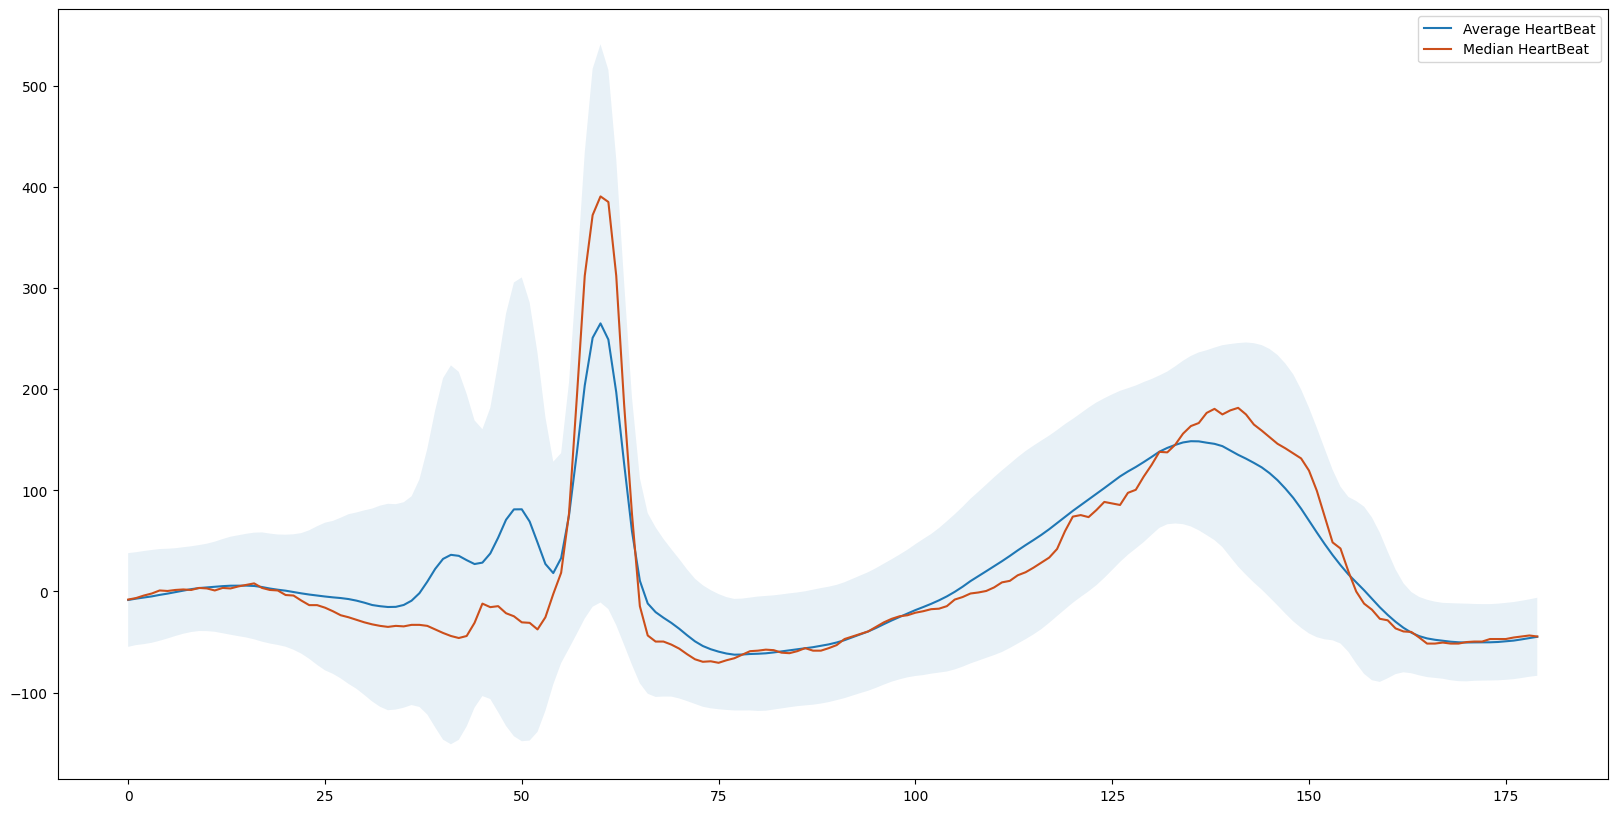

Processing val set:   6%|▋         | 65/1024 [00:06<01:51,  8.56it/s]

(29, 180)
(41, 180)
(31, 180)


Processing val set:   7%|▋         | 69/1024 [00:06<01:37,  9.76it/s]

(35, 180)
(23, 180)
(38, 180)


Processing val set:   7%|▋         | 71/1024 [00:07<01:54,  8.33it/s]

(53, 180)
(53, 180)


Processing val set:   7%|▋         | 72/1024 [00:07<02:03,  7.71it/s]

(64, 180)
(39, 180)


Processing val set:   7%|▋         | 76/1024 [00:07<01:45,  8.95it/s]

(49, 180)
(28, 180)
(40, 180)


Processing val set:   8%|▊         | 78/1024 [00:07<01:30, 10.46it/s]

(12, 180)
(37, 180)
(35, 180)


Processing val set:   8%|▊         | 80/1024 [00:07<01:27, 10.79it/s]

(40, 180)
(66, 180)


Processing val set:   8%|▊         | 82/1024 [00:08<01:33, 10.07it/s]

(18, 180)
(56, 180)


Processing val set:   8%|▊         | 86/1024 [00:08<01:32, 10.10it/s]

(26, 180)
(32, 180)
(29, 180)


Processing val set:   9%|▊         | 88/1024 [00:08<01:29, 10.46it/s]

(31, 180)
(29, 180)
(32, 180)


Processing val set:   9%|▉         | 92/1024 [00:09<01:26, 10.75it/s]

(35, 180)
(36, 180)
(30, 180)


Processing val set:   9%|▉         | 94/1024 [00:09<01:29, 10.36it/s]

(31, 180)
(48, 180)


Processing val set:   9%|▉         | 96/1024 [00:09<01:28, 10.51it/s]

(33, 180)
(34, 180)
(28, 180)


Processing val set:  10%|▉         | 98/1024 [00:09<01:26, 10.68it/s]

(33, 180)
(62, 180)


Processing val set:  10%|▉         | 102/1024 [00:10<01:31, 10.09it/s]

(30, 180)
(31, 180)
(46, 180)


Processing val set:  10%|█         | 104/1024 [00:10<01:27, 10.54it/s]

(28, 180)
(28, 180)
(26, 180)


Processing val set:  11%|█         | 108/1024 [00:10<01:21, 11.21it/s]

(32, 180)
(28, 180)
(29, 180)


Processing val set:  11%|█         | 110/1024 [00:10<01:28, 10.36it/s]

(39, 180)
(45, 180)


Processing val set:  11%|█         | 112/1024 [00:11<01:24, 10.74it/s]

(31, 180)
(35, 180)
(38, 180)


Processing val set:  11%|█         | 114/1024 [00:11<01:24, 10.77it/s]

(33, 180)
(32, 180)


Processing val set:  12%|█▏        | 118/1024 [00:11<01:25, 10.56it/s]

(57, 180)
(32, 180)
(34, 180)


Processing val set:  12%|█▏        | 120/1024 [00:11<01:24, 10.70it/s]

(29, 180)
(39, 180)
(31, 180)


Processing val set:  12%|█▏        | 124/1024 [00:12<01:21, 11.03it/s]

(34, 180)
(30, 180)
(26, 180)


Processing val set:  12%|█▏        | 126/1024 [00:12<01:20, 11.17it/s]

(28, 180)
(27, 180)
(29, 180)


Processing val set:  13%|█▎        | 130/1024 [00:12<01:19, 11.32it/s]

(23, 180)
(41, 180)
(25, 180)


Processing val set:  13%|█▎        | 132/1024 [00:12<01:17, 11.46it/s]

(26, 180)
(32, 180)
(34, 180)


Processing val set:  13%|█▎        | 136/1024 [00:13<01:15, 11.78it/s]

(19, 180)
(37, 180)
(38, 180)


Processing val set:  13%|█▎        | 138/1024 [00:13<01:33,  9.49it/s]

(88, 180)
(40, 180)


Processing val set:  14%|█▎        | 140/1024 [00:13<01:28,  9.97it/s]

(29, 180)
(29, 180)
(48, 180)


Processing val set:  14%|█▍        | 144/1024 [00:13<01:17, 11.31it/s]

(33, 180)
(26, 180)
(25, 180)


Processing val set:  14%|█▍        | 146/1024 [00:14<01:19, 11.10it/s]

(45, 180)
(35, 180)
(28, 180)


Processing val set:  15%|█▍        | 150/1024 [00:14<01:12, 12.01it/s]

(26, 180)
(24, 180)
(25, 180)


Processing val set:  15%|█▍        | 152/1024 [00:14<01:26, 10.03it/s]

(79, 180)
(31, 180)
(30, 180)


Processing val set:  15%|█▌        | 156/1024 [00:15<01:22, 10.49it/s]

(33, 180)
(39, 180)
(29, 180)


Processing val set:  15%|█▌        | 158/1024 [00:15<01:31,  9.46it/s]

(59, 180)
(33, 180)
(33, 180)


Processing val set:  16%|█▌        | 162/1024 [00:15<01:22, 10.48it/s]

(32, 180)
(39, 180)
(34, 180)


Processing val set:  16%|█▌        | 164/1024 [00:15<01:19, 10.86it/s]

(31, 180)
(35, 180)
(29, 180)


Processing val set:  16%|█▌        | 166/1024 [00:16<01:18, 10.98it/s]

(32, 180)
(75, 180)


Processing val set:  16%|█▋        | 168/1024 [00:16<01:28,  9.71it/s]

(32, 180)
(61, 180)


Processing val set:  17%|█▋        | 172/1024 [00:16<01:24, 10.10it/s]

(30, 180)
(23, 180)
(31, 180)


Processing val set:  17%|█▋        | 174/1024 [00:16<01:21, 10.40it/s]

(36, 180)
(42, 180)
(36, 180)


Processing val set:  17%|█▋        | 178/1024 [00:17<01:13, 11.44it/s]

(34, 180)
(19, 180)
(40, 180)


Processing val set:  18%|█▊        | 180/1024 [00:17<01:15, 11.21it/s]

(42, 180)
(32, 180)
(27, 180)


Processing val set:  18%|█▊        | 184/1024 [00:17<01:14, 11.26it/s]

(35, 180)
(30, 180)
(37, 180)


Processing val set:  18%|█▊        | 186/1024 [00:17<01:14, 11.27it/s]

(38, 180)
(31, 180)
(36, 180)


Processing val set:  18%|█▊        | 188/1024 [00:18<01:15, 11.12it/s]

(41, 180)
(66, 180)


Processing val set:  19%|█▉        | 192/1024 [00:18<01:23, 10.00it/s]

(45, 180)
(35, 180)
(32, 180)


Processing val set:  19%|█▉        | 194/1024 [00:18<01:20, 10.30it/s]

(29, 180)
(40, 180)
(33, 180)


Processing val set:  19%|█▉        | 198/1024 [00:19<01:10, 11.71it/s]

(46, 180)
(12, 180)
(36, 180)


Processing val set:  20%|█▉        | 200/1024 [00:19<01:10, 11.62it/s]

(31, 180)
(40, 180)


Processing val set:  20%|█▉        | 202/1024 [00:19<01:22,  9.91it/s]

(65, 180)
(33, 180)
(37, 180)


Processing val set:  20%|██        | 206/1024 [00:19<01:17, 10.55it/s]

(35, 180)
(37, 180)
(33, 180)


Processing val set:  20%|██        | 208/1024 [00:19<01:10, 11.64it/s]

(20, 180)
(31, 180)
(35, 180)


Processing val set:  21%|██        | 210/1024 [00:20<01:22,  9.92it/s]

(58, 180)
(56, 180)


Processing val set:  21%|██        | 214/1024 [00:20<01:19, 10.20it/s]

(29, 180)
(37, 180)
(39, 180)


Processing val set:  21%|██        | 216/1024 [00:20<01:14, 10.78it/s]

(21, 180)
(40, 180)
(14, 180)


Processing val set:  21%|██▏       | 220/1024 [00:21<01:04, 12.43it/s]

(36, 180)
(45, 180)
(27, 180)


Processing val set:  22%|██▏       | 222/1024 [00:21<01:06, 12.02it/s]

(32, 180)
(37, 180)


Processing val set:  22%|██▏       | 224/1024 [00:21<01:17, 10.38it/s]

(56, 180)
(33, 180)
(27, 180)


Processing val set:  22%|██▏       | 228/1024 [00:21<01:13, 10.85it/s]

(36, 180)
(37, 180)
(30, 180)


Processing val set:  22%|██▏       | 230/1024 [00:22<01:13, 10.82it/s]

(30, 180)
(31, 180)
(14, 180)


Processing val set:  23%|██▎       | 234/1024 [00:22<01:07, 11.70it/s]

(32, 180)
(33, 180)
(33, 180)


Processing val set:  23%|██▎       | 236/1024 [00:22<01:07, 11.69it/s]

(34, 180)
(34, 180)
(29, 180)


Processing val set:  23%|██▎       | 238/1024 [00:22<01:08, 11.47it/s]

(31, 180)
(70, 180)


Processing val set:  24%|██▎       | 242/1024 [00:23<01:15, 10.34it/s]

(37, 180)
(26, 180)
(33, 180)


Processing val set:  24%|██▍       | 244/1024 [00:23<01:17, 10.12it/s]

(56, 180)
(11, 180)
(35, 180)


Processing val set:  24%|██▍       | 248/1024 [00:23<01:06, 11.64it/s]

(33, 180)
(27, 180)
(24, 180)


Processing val set:  24%|██▍       | 250/1024 [00:23<01:06, 11.59it/s]

(32, 180)
(31, 180)
(44, 180)


Processing val set:  25%|██▍       | 254/1024 [00:24<01:07, 11.49it/s]

(32, 180)
(26, 180)
(23, 180)


Processing val set:  25%|██▌       | 256/1024 [00:24<01:05, 11.79it/s]

(27, 180)
(36, 180)
(34, 180)


Processing val set:  25%|██▌       | 260/1024 [00:24<01:05, 11.69it/s]

(32, 180)
(36, 180)
(37, 180)


Processing val set:  26%|██▌       | 262/1024 [00:24<01:02, 12.11it/s]

(36, 180)
(26, 180)


Processing val set:  26%|██▌       | 264/1024 [00:25<01:23,  9.13it/s]

(61, 180)
(71, 180)


Processing val set:  26%|██▌       | 266/1024 [00:25<01:18,  9.64it/s]

(41, 180)
(32, 180)
(30, 180)


Processing val set:  26%|██▋       | 270/1024 [00:25<01:11, 10.48it/s]

(25, 180)
(29, 180)
(37, 180)


Processing val set:  27%|██▋       | 272/1024 [00:25<01:10, 10.72it/s]

(28, 180)
(36, 180)
(27, 180)


Processing val set:  27%|██▋       | 276/1024 [00:26<01:14, 10.01it/s]

(73, 180)
(32, 180)
(38, 180)


Processing val set:  27%|██▋       | 278/1024 [00:26<01:13, 10.16it/s]

(38, 180)
(34, 180)
(34, 180)


Processing val set:  28%|██▊       | 282/1024 [00:26<01:09, 10.73it/s]

(34, 180)
(31, 180)
(36, 180)


Processing val set:  28%|██▊       | 284/1024 [00:27<01:18,  9.46it/s]

(32, 180)
(65, 180)


Processing val set:  28%|██▊       | 286/1024 [00:27<01:13, 10.04it/s]

(31, 180)
(29, 180)
(32, 180)


Processing val set:  28%|██▊       | 290/1024 [00:27<01:15,  9.78it/s]

(66, 180)
(28, 180)
(31, 180)


Processing val set:  29%|██▊       | 292/1024 [00:27<01:11, 10.21it/s]

(29, 180)
(26, 180)
(31, 180)


Processing val set:  29%|██▉       | 296/1024 [00:28<01:03, 11.47it/s]

(10, 180)
(31, 180)
(24, 180)


Processing val set:  29%|██▉       | 300/1024 [00:28<00:56, 12.81it/s]

(32, 180)
(24, 180)
(34, 180)
(16, 180)


Processing val set:  29%|██▉       | 302/1024 [00:28<00:57, 12.50it/s]

(37, 180)
(29, 180)
(14, 180)
(21, 180)


Processing val set:  30%|██▉       | 307/1024 [00:29<00:54, 13.05it/s]

(38, 180)
(36, 180)
(40, 180)


Processing val set:  30%|███       | 309/1024 [00:29<00:56, 12.58it/s]

(26, 180)
(29, 180)
(30, 180)


Processing val set:  30%|███       | 311/1024 [00:29<00:57, 12.32it/s]

(27, 180)
(52, 180)


Processing val set:  31%|███       | 315/1024 [00:29<01:01, 11.59it/s]

(46, 180)
(28, 180)
(32, 180)


Processing val set:  31%|███       | 317/1024 [00:29<01:06, 10.57it/s]

(43, 180)
(60, 180)


Processing val set:  31%|███       | 319/1024 [00:30<01:08, 10.30it/s]

(40, 180)
(37, 180)
(44, 180)


Processing val set:  32%|███▏      | 323/1024 [00:30<01:04, 10.81it/s]

(40, 180)
(30, 180)
(32, 180)


Processing val set:  32%|███▏      | 325/1024 [00:30<01:04, 10.84it/s]

(34, 180)
(36, 180)
(33, 180)


Processing val set:  32%|███▏      | 329/1024 [00:31<00:57, 12.01it/s]

(33, 180)
(32, 180)
(15, 180)


Processing val set:  32%|███▏      | 331/1024 [00:31<00:59, 11.72it/s]

(35, 180)
(34, 180)
(33, 180)


Processing val set:  33%|███▎      | 335/1024 [00:31<00:55, 12.35it/s]

(33, 180)
(16, 180)
(34, 180)


Processing val set:  33%|███▎      | 337/1024 [00:31<00:56, 12.21it/s]

(30, 180)
(40, 180)
(44, 180)


Processing val set:  33%|███▎      | 341/1024 [00:32<00:59, 11.52it/s]

(41, 180)
(34, 180)
(35, 180)


Processing val set:  33%|███▎      | 343/1024 [00:32<00:53, 12.76it/s]

(27, 180)
(11, 180)
(44, 180)


Processing val set:  34%|███▍      | 347/1024 [00:32<00:56, 12.07it/s]

(31, 180)
(29, 180)
(32, 180)


Processing val set:  34%|███▍      | 349/1024 [00:32<00:54, 12.36it/s]

(44, 180)
(21, 180)


Processing val set:  34%|███▍      | 351/1024 [00:32<01:05, 10.27it/s]

(60, 180)
(41, 180)
(31, 180)


Processing val set:  35%|███▍      | 355/1024 [00:33<00:58, 11.37it/s]

(16, 180)
(30, 180)
(38, 180)


Processing val set:  35%|███▍      | 357/1024 [00:33<00:58, 11.39it/s]

(26, 180)
(34, 180)


Processing val set:  35%|███▌      | 359/1024 [00:33<01:04, 10.29it/s]

(52, 180)
(27, 180)
(31, 180)


Processing val set:  35%|███▌      | 363/1024 [00:34<01:01, 10.72it/s]

(27, 180)
(41, 180)
(27, 180)


Processing val set:  36%|███▌      | 365/1024 [00:34<01:01, 10.78it/s]

(30, 180)
(34, 180)
(33, 180)


Processing val set:  36%|███▌      | 367/1024 [00:34<01:00, 10.87it/s]

(26, 180)
(34, 180)


Processing val set:  36%|███▌      | 371/1024 [00:34<01:03, 10.30it/s]

(53, 180)
(28, 180)
(32, 180)


Processing val set:  36%|███▋      | 373/1024 [00:35<01:09,  9.40it/s]

(27, 180)
(63, 180)


Processing val set:  37%|███▋      | 375/1024 [00:35<01:10,  9.19it/s]

(31, 180)
(58, 180)


Processing val set:  37%|███▋      | 377/1024 [00:35<01:06,  9.75it/s]

(39, 180)
(33, 180)
(32, 180)


Processing val set:  37%|███▋      | 379/1024 [00:35<01:03, 10.15it/s]

(30, 180)
(55, 180)


Processing val set:  37%|███▋      | 383/1024 [00:36<01:10,  9.08it/s]

(69, 180)
(28, 180)
(38, 180)


Processing val set:  38%|███▊      | 385/1024 [00:36<01:05,  9.72it/s]

(29, 180)
(30, 180)


Processing val set:  38%|███▊      | 387/1024 [00:36<01:09,  9.13it/s]

(53, 180)
(30, 180)
(42, 180)


Processing val set:  38%|███▊      | 391/1024 [00:36<01:02, 10.13it/s]

(41, 180)
(31, 180)
(35, 180)


Processing val set:  39%|███▊      | 395/1024 [00:37<00:59, 10.53it/s]

(71, 180)
(21, 180)
(19, 180)
(31, 180)


Processing val set:  39%|███▉      | 397/1024 [00:37<01:05,  9.51it/s]

(25, 180)
(63, 180)


Processing val set:  39%|███▉      | 399/1024 [00:37<01:10,  8.87it/s]

(63, 180)
(35, 180)
(17, 180)


Processing val set:  39%|███▉      | 401/1024 [00:37<01:00, 10.27it/s]

(33, 180)
(38, 180)


Processing val set:  40%|███▉      | 405/1024 [00:38<01:02,  9.88it/s]

(63, 180)
(30, 180)
(30, 180)


Processing val set:  40%|███▉      | 407/1024 [00:38<01:00, 10.23it/s]

(43, 180)
(34, 180)
(30, 180)


Processing val set:  40%|████      | 411/1024 [00:38<00:54, 11.26it/s]

(17, 180)
(29, 180)
(32, 180)


Processing val set:  40%|████      | 413/1024 [00:39<01:00, 10.09it/s]

(37, 180)
(45, 180)


Processing val set:  41%|████      | 415/1024 [00:39<00:57, 10.65it/s]

(29, 180)
(32, 180)


Processing val set:  41%|████      | 417/1024 [00:39<01:03,  9.62it/s]

(64, 180)
(27, 180)


Processing val set:  41%|████      | 419/1024 [00:39<01:00, 10.07it/s]

(42, 180)
(15, 180)
(40, 180)


Processing val set:  41%|████      | 421/1024 [00:39<00:58, 10.32it/s]

(38, 180)
(35, 180)


Processing val set:  42%|████▏     | 425/1024 [00:40<00:59, 10.03it/s]

(65, 180)
(31, 180)
(33, 180)


Processing val set:  42%|████▏     | 427/1024 [00:40<00:53, 11.09it/s]

(17, 180)
(33, 180)
(32, 180)


Processing val set:  42%|████▏     | 431/1024 [00:40<00:52, 11.32it/s]

(26, 180)
(29, 180)
(31, 180)


Processing val set:  42%|████▏     | 433/1024 [00:40<00:48, 12.28it/s]

(17, 180)
(33, 180)
(28, 180)


Processing val set:  43%|████▎     | 437/1024 [00:41<00:49, 11.78it/s]

(34, 180)
(30, 180)
(37, 180)


Processing val set:  43%|████▎     | 439/1024 [00:41<00:48, 12.16it/s]

(26, 180)
(28, 180)
(40, 180)


Processing val set:  43%|████▎     | 443/1024 [00:41<00:50, 11.52it/s]

(29, 180)
(43, 180)
(29, 180)


Processing val set:  43%|████▎     | 445/1024 [00:42<00:49, 11.71it/s]

(36, 180)
(23, 180)


Processing val set:  44%|████▎     | 447/1024 [00:42<00:57, 10.10it/s]

(63, 180)
(33, 180)
(47, 180)


Processing val set:  44%|████▍     | 451/1024 [00:42<00:58,  9.82it/s]

(74, 180)
(24, 180)
(34, 180)


Processing val set:  44%|████▍     | 453/1024 [00:42<01:03,  9.02it/s]

(42, 180)
(58, 180)


Processing val set:  44%|████▍     | 455/1024 [00:43<00:59,  9.58it/s]

(33, 180)
(30, 180)
(40, 180)


Processing val set:  45%|████▍     | 459/1024 [00:43<00:54, 10.39it/s]

(30, 180)
(35, 180)
(31, 180)


Processing val set:  45%|████▌     | 461/1024 [00:43<00:52, 10.81it/s]

(28, 180)
(30, 180)
(31, 180)


Processing val set:  45%|████▌     | 465/1024 [00:44<00:49, 11.32it/s]

(31, 180)
(29, 180)
(31, 180)


Processing val set:  46%|████▌     | 467/1024 [00:44<00:50, 11.06it/s]

(33, 180)
(47, 180)
(40, 180)


Processing val set:  46%|████▌     | 471/1024 [00:44<00:50, 11.00it/s]

(42, 180)
(37, 180)
(40, 180)


Processing val set:  46%|████▌     | 473/1024 [00:44<00:50, 10.92it/s]

(31, 180)
(38, 180)
(35, 180)


Processing val set:  46%|████▋     | 475/1024 [00:44<00:50, 10.88it/s]

(41, 180)
(67, 180)


Processing val set:  47%|████▋     | 479/1024 [00:45<00:57,  9.47it/s]

(56, 180)
(37, 180)
(31, 180)


Processing val set:  47%|████▋     | 481/1024 [00:45<00:54,  9.93it/s]

(29, 180)
(33, 180)
(27, 180)


Processing val set:  47%|████▋     | 485/1024 [00:45<00:45, 11.79it/s]

(32, 180)
(37, 180)
(15, 180)


Processing val set:  48%|████▊     | 487/1024 [00:46<00:46, 11.57it/s]

(39, 180)
(32, 180)
(35, 180)


Processing val set:  48%|████▊     | 491/1024 [00:46<00:47, 11.12it/s]

(46, 180)
(27, 180)
(35, 180)


Processing val set:  48%|████▊     | 493/1024 [00:46<00:48, 10.95it/s]

(37, 180)
(35, 180)
(31, 180)


Processing val set:  48%|████▊     | 495/1024 [00:46<00:47, 11.09it/s]

(33, 180)
(27, 180)


Processing val set:  49%|████▊     | 497/1024 [00:47<00:52, 10.05it/s]

(58, 180)
(41, 180)


Processing val set:  49%|████▉     | 501/1024 [00:47<00:51, 10.06it/s]

(33, 180)
(37, 180)
(33, 180)


Processing val set:  49%|████▉     | 503/1024 [00:47<00:49, 10.50it/s]

(33, 180)
(35, 180)


Processing val set:  49%|████▉     | 505/1024 [00:47<00:58,  8.85it/s]

(63, 180)
(56, 180)


Processing val set:  50%|████▉     | 507/1024 [00:48<00:54,  9.57it/s]

(37, 180)
(30, 180)
(44, 180)


Processing val set:  50%|████▉     | 511/1024 [00:48<00:50, 10.25it/s]

(38, 180)
(28, 180)
(45, 180)


Processing val set:  50%|█████     | 513/1024 [00:48<00:54,  9.34it/s]

(28, 180)
(55, 180)


Processing val set:  50%|█████     | 515/1024 [00:48<00:51,  9.87it/s]

(28, 180)
(42, 180)
(33, 180)


Processing val set:  51%|█████     | 519/1024 [00:49<00:48, 10.33it/s]

(30, 180)
(46, 180)
(47, 180)


Processing val set:  51%|█████     | 521/1024 [00:49<00:49, 10.18it/s]

(45, 180)
(31, 180)
(42, 180)


Processing val set:  51%|█████▏    | 525/1024 [00:49<00:47, 10.58it/s]

(29, 180)
(32, 180)
(32, 180)


Processing val set:  51%|█████▏    | 527/1024 [00:50<00:45, 10.83it/s]

(31, 180)
(32, 180)
(50, 180)


Processing val set:  52%|█████▏    | 531/1024 [00:50<00:44, 11.03it/s]

(31, 180)
(33, 180)
(43, 180)


Processing val set:  52%|█████▏    | 533/1024 [00:50<00:42, 11.62it/s]

(32, 180)
(27, 180)
(31, 180)


Processing val set:  52%|█████▏    | 535/1024 [00:50<00:41, 11.71it/s]

(27, 180)
(29, 180)


Processing val set:  52%|█████▏    | 537/1024 [00:50<00:48,  9.96it/s]

(63, 180)
(66, 180)


Processing val set:  53%|█████▎    | 539/1024 [00:51<00:52,  9.16it/s]

(27, 180)
(32, 180)


Processing val set:  53%|█████▎    | 543/1024 [00:51<00:51,  9.26it/s]

(76, 180)
(34, 180)
(39, 180)


Processing val set:  53%|█████▎    | 545/1024 [00:51<00:49,  9.73it/s]

(35, 180)
(26, 180)
(35, 180)


Processing val set:  54%|█████▎    | 549/1024 [00:52<00:46, 10.12it/s]

(59, 180)
(22, 180)
(27, 180)


Processing val set:  54%|█████▍    | 551/1024 [00:52<00:51,  9.17it/s]

(67, 180)
(26, 180)


Processing val set:  54%|█████▍    | 554/1024 [00:52<00:52,  9.00it/s]

(64, 180)
(28, 180)
(27, 180)


Processing val set:  54%|█████▍    | 556/1024 [00:53<00:50,  9.35it/s]

(29, 180)
(37, 180)


Processing val set:  54%|█████▍    | 558/1024 [00:53<00:47,  9.74it/s]

(36, 180)
(32, 180)
(33, 180)


Processing val set:  55%|█████▍    | 562/1024 [00:53<00:44, 10.41it/s]

(33, 180)
(30, 180)
(37, 180)


Processing val set:  55%|█████▌    | 564/1024 [00:53<00:43, 10.53it/s]

(33, 180)
(37, 180)
(15, 180)
(22, 180)


Processing val set:  56%|█████▌    | 569/1024 [00:54<00:41, 11.03it/s]

(68, 180)
(34, 180)
(35, 180)


Processing val set:  56%|█████▌    | 571/1024 [00:54<00:40, 11.09it/s]

(30, 180)
(35, 180)
(11, 180)


Processing val set:  56%|█████▌    | 573/1024 [00:54<00:36, 12.24it/s]

(35, 180)
(35, 180)


Processing val set:  56%|█████▋    | 577/1024 [00:54<00:41, 10.69it/s]

(66, 180)
(29, 180)
(32, 180)


Processing val set:  57%|█████▋    | 579/1024 [00:55<00:43, 10.30it/s]

(82, 180)
(18, 180)
(31, 180)


Processing val set:  57%|█████▋    | 581/1024 [00:55<00:41, 10.57it/s]

(35, 180)
(72, 180)


Processing val set:  57%|█████▋    | 584/1024 [00:55<00:52,  8.33it/s]

(29, 180)
(78, 180)


Processing val set:  57%|█████▋    | 586/1024 [00:56<00:49,  8.84it/s]

(31, 180)
(35, 180)
(35, 180)


Processing val set:  58%|█████▊    | 589/1024 [00:56<00:51,  8.42it/s]

(41, 180)
(65, 180)


Processing val set:  58%|█████▊    | 591/1024 [00:56<00:47,  9.13it/s]

(31, 180)
(44, 180)
(16, 180)
(15, 180)


Processing val set:  58%|█████▊    | 594/1024 [00:56<00:34, 12.62it/s]

(10, 180)
(44, 180)


Processing val set:  58%|█████▊    | 598/1024 [00:57<00:36, 11.54it/s]

(30, 180)
(34, 180)
(32, 180)


Processing val set:  59%|█████▊    | 600/1024 [00:57<00:42,  9.91it/s]

(34, 180)
(74, 180)


Processing val set:  59%|█████▉    | 602/1024 [00:57<00:38, 11.03it/s]

(17, 180)
(34, 180)
(33, 180)


Processing val set:  59%|█████▉    | 606/1024 [00:57<00:37, 11.14it/s]

(42, 180)
(29, 180)
(32, 180)


Processing val set:  59%|█████▉    | 608/1024 [00:58<00:43,  9.63it/s]

(112, 180)
(40, 180)
(43, 180)


Processing val set:  60%|█████▉    | 612/1024 [00:58<00:40, 10.17it/s]

(56, 180)
(38, 180)
(52, 180)


Processing val set:  60%|█████▉    | 614/1024 [00:58<00:39, 10.34it/s]

(59, 180)
(41, 180)


Processing val set:  60%|██████    | 618/1024 [00:58<00:32, 12.56it/s]

(46, 180)
(13, 180)
(16, 180)
(36, 180)


Processing val set:  61%|██████    | 620/1024 [00:59<00:30, 13.21it/s]

(38, 180)
(16, 180)
(42, 180)


Processing val set:  61%|██████    | 624/1024 [00:59<00:34, 11.69it/s]

(34, 180)
(54, 180)
(65, 180)


Processing val set:  61%|██████    | 626/1024 [00:59<00:36, 10.79it/s]

(20, 180)
(94, 180)


Processing val set:  61%|██████▏   | 628/1024 [00:59<00:36, 10.88it/s]

(37, 180)
(56, 180)
(24, 180)


Processing val set:  62%|██████▏   | 632/1024 [01:00<00:35, 11.08it/s]

(36, 180)
(38, 180)
(56, 180)


Processing val set:  62%|██████▏   | 634/1024 [01:00<00:35, 10.93it/s]

(50, 180)
(44, 180)
(42, 180)


Processing val set:  62%|██████▏   | 638/1024 [01:00<00:35, 10.97it/s]

(30, 180)
(39, 180)
(36, 180)


Processing val set:  62%|██████▎   | 640/1024 [01:00<00:40,  9.38it/s]

(38, 180)
(126, 180)


Processing val set:  63%|██████▎   | 643/1024 [01:01<00:32, 11.57it/s]

(16, 180)
(18, 180)
(42, 180)


Processing val set:  63%|██████▎   | 645/1024 [01:01<00:33, 11.36it/s]

(44, 180)
(35, 180)
(44, 180)


Processing val set:  63%|██████▎   | 649/1024 [01:01<00:37,  9.99it/s]

(114, 180)
(60, 180)
(29, 180)


Processing val set:  64%|██████▎   | 651/1024 [01:02<00:40,  9.11it/s]

(61, 180)
(60, 180)
(48, 180)


Processing val set:  64%|██████▍   | 653/1024 [01:02<00:38,  9.68it/s]

(44, 180)
(89, 180)


Processing val set:  64%|██████▍   | 657/1024 [01:02<00:42,  8.59it/s]

(120, 180)
(39, 180)
(28, 180)


Processing val set:  64%|██████▍   | 660/1024 [01:03<00:40,  8.88it/s]

(81, 180)
(49, 180)
(41, 180)


Processing val set:  65%|██████▍   | 662/1024 [01:03<00:38,  9.51it/s]

(46, 180)
(32, 180)
(11, 180)


Processing val set:  65%|██████▌   | 666/1024 [01:03<00:33, 10.84it/s]

(69, 180)
(46, 180)
(35, 180)


Processing val set:  65%|██████▌   | 668/1024 [01:03<00:33, 10.63it/s]

(89, 180)
(40, 180)
(37, 180)


Processing val set:  66%|██████▌   | 672/1024 [01:04<00:29, 11.76it/s]

(49, 180)
(41, 180)
(18, 180)


Processing val set:  66%|██████▌   | 674/1024 [01:04<00:30, 11.64it/s]

(35, 180)
(31, 180)


Processing val set:  66%|██████▌   | 676/1024 [01:04<00:35,  9.72it/s]

(121, 180)
(47, 180)
(45, 180)


Processing val set:  66%|██████▋   | 679/1024 [01:04<00:38,  8.96it/s]

(108, 180)
(58, 180)


Processing val set:  67%|██████▋   | 681/1024 [01:05<00:35,  9.54it/s]

(38, 180)
(33, 180)
(34, 180)


Processing val set:  67%|██████▋   | 685/1024 [01:05<00:29, 11.50it/s]

(48, 180)
(36, 180)
(10, 180)


Processing val set:  67%|██████▋   | 687/1024 [01:05<00:29, 11.25it/s]

(50, 180)
(34, 180)
(15, 180)


Processing val set:  67%|██████▋   | 691/1024 [01:05<00:27, 12.13it/s]

(31, 180)
(45, 180)
(32, 180)


Processing val set:  68%|██████▊   | 693/1024 [01:06<00:32, 10.12it/s]

(37, 180)
(69, 180)


Processing val set:  68%|██████▊   | 695/1024 [01:06<00:39,  8.35it/s]

(82, 180)
(102, 180)


Processing val set:  68%|██████▊   | 698/1024 [01:06<00:35,  9.22it/s]

(51, 180)
(30, 180)
(32, 180)


Processing val set:  68%|██████▊   | 700/1024 [01:07<00:32,  9.95it/s]

(26, 180)
(36, 180)
(37, 180)


Processing val set:  69%|██████▊   | 702/1024 [01:07<00:30, 10.73it/s]

(25, 180)
(58, 180)


Processing val set:  69%|██████▉   | 706/1024 [01:07<00:32,  9.71it/s]

(85, 180)
(36, 180)
(70, 180)


Processing val set:  69%|██████▉   | 708/1024 [01:07<00:31,  9.98it/s]

(35, 180)
(54, 180)
(32, 180)


Processing val set:  69%|██████▉   | 710/1024 [01:08<00:29, 10.47it/s]

(37, 180)
(66, 180)


Processing val set:  70%|██████▉   | 712/1024 [01:08<00:33,  9.40it/s]

(58, 180)
(32, 180)


Processing val set:  70%|██████▉   | 716/1024 [01:08<00:32,  9.39it/s]

(60, 180)
(47, 180)
(33, 180)


Processing val set:  70%|███████   | 718/1024 [01:08<00:30,  9.89it/s]

(33, 180)
(35, 180)
(37, 180)


Processing val set:  71%|███████   | 722/1024 [01:09<00:28, 10.50it/s]

(29, 180)
(41, 180)
(31, 180)


Processing val set:  71%|███████   | 724/1024 [01:09<00:28, 10.70it/s]

(35, 180)
(29, 180)
(21, 180)


Processing val set:  71%|███████   | 726/1024 [01:09<00:26, 11.41it/s]

(26, 180)
(34, 180)


Processing val set:  71%|███████▏  | 730/1024 [01:10<00:28, 10.38it/s]

(84, 180)
(27, 180)
(23, 180)


Processing val set:  71%|███████▏  | 732/1024 [01:10<00:31,  9.40it/s]

(81, 180)
(28, 180)
(29, 180)


Processing val set:  72%|███████▏  | 734/1024 [01:10<00:28, 10.30it/s]

(37, 180)
(78, 180)


Processing val set:  72%|███████▏  | 736/1024 [01:10<00:30,  9.29it/s]

(35, 180)
(20, 180)


Processing val set:  72%|███████▏  | 738/1024 [01:10<00:32,  8.91it/s]

(55, 180)
(38, 180)


Processing val set:  72%|███████▏  | 741/1024 [01:11<00:32,  8.61it/s]

(83, 180)
(63, 180)
(24, 180)


Processing val set:  73%|███████▎  | 745/1024 [01:11<00:28,  9.84it/s]

(44, 180)
(48, 180)
(34, 180)


Processing val set:  73%|███████▎  | 747/1024 [01:11<00:32,  8.65it/s]

(131, 180)
(39, 180)
(48, 180)


Processing val set:  73%|███████▎  | 751/1024 [01:12<00:25, 10.52it/s]

(26, 180)
(15, 180)
(39, 180)


Processing val set:  74%|███████▎  | 753/1024 [01:12<00:25, 10.76it/s]

(30, 180)
(29, 180)
(42, 180)


Processing val set:  74%|███████▎  | 755/1024 [01:12<00:24, 11.09it/s]

(36, 180)
(26, 180)


Processing val set:  74%|███████▍  | 759/1024 [01:12<00:24, 11.03it/s]

(75, 180)
(11, 180)
(33, 180)


Processing val set:  74%|███████▍  | 761/1024 [01:13<00:23, 11.17it/s]

(27, 180)
(21, 180)
(48, 180)


Processing val set:  75%|███████▍  | 765/1024 [01:13<00:21, 12.18it/s]

(29, 180)
(18, 180)
(24, 180)


Processing val set:  75%|███████▍  | 767/1024 [01:13<00:25, 10.25it/s]

(35, 180)
(70, 180)


Processing val set:  75%|███████▌  | 769/1024 [01:13<00:24, 10.58it/s]

(28, 180)
(32, 180)
(34, 180)


Processing val set:  75%|███████▌  | 773/1024 [01:14<00:22, 11.08it/s]

(38, 180)
(34, 180)
(27, 180)


Processing val set:  76%|███████▌  | 775/1024 [01:14<00:22, 11.06it/s]

(33, 180)
(42, 180)
(30, 180)


Processing val set:  76%|███████▌  | 779/1024 [01:14<00:21, 11.54it/s]

(28, 180)
(29, 180)
(31, 180)


Processing val set:  76%|███████▋  | 781/1024 [01:15<00:25,  9.66it/s]

(30, 180)
(131, 180)


Processing val set:  76%|███████▋  | 783/1024 [01:15<00:24,  9.89it/s]

(56, 180)
(39, 180)
(33, 180)


Processing val set:  77%|███████▋  | 785/1024 [01:15<00:23, 10.22it/s]

(35, 180)
(66, 180)


Processing val set:  77%|███████▋  | 789/1024 [01:15<00:23, 10.19it/s]

(15, 180)
(36, 180)
(34, 180)


Processing val set:  77%|███████▋  | 791/1024 [01:16<00:23,  9.92it/s]

(31, 180)
(55, 180)
(19, 180)


Processing val set:  78%|███████▊  | 795/1024 [01:16<00:20, 11.12it/s]

(27, 180)
(44, 180)
(33, 180)


Processing val set:  78%|███████▊  | 797/1024 [01:16<00:21, 10.47it/s]

(65, 180)
(14, 180)
(41, 180)


Processing val set:  78%|███████▊  | 799/1024 [01:16<00:21, 10.63it/s]

(31, 180)
(45, 180)


Processing val set:  78%|███████▊  | 803/1024 [01:17<00:23,  9.52it/s]

(62, 180)
(31, 180)
(34, 180)


Processing val set:  79%|███████▊  | 805/1024 [01:17<00:20, 10.65it/s]

(21, 180)
(28, 180)
(29, 180)


Processing val set:  79%|███████▉  | 809/1024 [01:17<00:19, 10.95it/s]

(43, 180)
(49, 180)
(29, 180)


Processing val set:  79%|███████▉  | 811/1024 [01:17<00:19, 11.07it/s]

(38, 180)
(33, 180)
(52, 180)


Processing val set:  80%|███████▉  | 815/1024 [01:18<00:19, 10.94it/s]

(41, 180)
(34, 180)
(28, 180)


Processing val set:  80%|███████▉  | 817/1024 [01:18<00:18, 11.05it/s]

(28, 180)
(31, 180)
(50, 180)


Processing val set:  80%|███████▉  | 819/1024 [01:18<00:18, 10.99it/s]

(39, 180)
(62, 180)


Processing val set:  80%|████████  | 821/1024 [01:18<00:19, 10.22it/s]

(19, 180)
(71, 180)


Processing val set:  81%|████████  | 825/1024 [01:19<00:21,  9.14it/s]

(49, 180)
(48, 180)
(35, 180)


Processing val set:  81%|████████  | 827/1024 [01:19<00:19,  9.94it/s]

(24, 180)
(34, 180)
(31, 180)


Processing val set:  81%|████████  | 829/1024 [01:19<00:19, 10.18it/s]

(58, 180)
(64, 180)


Processing val set:  81%|████████▏ | 832/1024 [01:20<00:23,  8.21it/s]

(32, 180)
(62, 180)


Processing val set:  81%|████████▏ | 834/1024 [01:20<00:20,  9.07it/s]

(21, 180)
(47, 180)
(41, 180)


Processing val set:  82%|████████▏ | 837/1024 [01:20<00:22,  8.44it/s]

(31, 180)
(76, 180)


Processing val set:  82%|████████▏ | 840/1024 [01:21<00:20,  9.17it/s]

(31, 180)
(31, 180)
(54, 180)


Processing val set:  82%|████████▏ | 842/1024 [01:21<00:18,  9.81it/s]

(28, 180)
(53, 180)
(28, 180)


Processing val set:  82%|████████▏ | 844/1024 [01:21<00:16, 11.00it/s]

(22, 180)
(31, 180)


Processing val set:  83%|████████▎ | 848/1024 [01:21<00:17, 10.23it/s]

(76, 180)
(32, 180)
(33, 180)


Processing val set:  83%|████████▎ | 850/1024 [01:21<00:16, 10.35it/s]

(33, 180)
(56, 180)
(15, 180)


Processing val set:  83%|████████▎ | 852/1024 [01:22<00:14, 11.55it/s]

(31, 180)
(39, 180)


Processing val set:  84%|████████▎ | 856/1024 [01:22<00:15, 10.84it/s]

(38, 180)
(40, 180)
(32, 180)


Processing val set:  84%|████████▍ | 858/1024 [01:22<00:15, 10.70it/s]

(13, 180)
(67, 180)


Processing val set:  84%|████████▍ | 860/1024 [01:22<00:14, 11.61it/s]

(18, 180)
(42, 180)
(38, 180)


Processing val set:  84%|████████▍ | 862/1024 [01:22<00:14, 11.32it/s]

(42, 180)
(64, 180)


Processing val set:  84%|████████▍ | 864/1024 [01:23<00:17,  9.17it/s]

(58, 180)
(56, 180)


Processing val set:  85%|████████▍ | 868/1024 [01:23<00:16,  9.31it/s]

(33, 180)
(48, 180)
(44, 180)


Processing val set:  85%|████████▍ | 870/1024 [01:23<00:15,  9.85it/s]

(36, 180)
(33, 180)
(30, 180)


Processing val set:  85%|████████▌ | 872/1024 [01:24<00:14, 10.29it/s]

(35, 180)
(29, 180)


Processing val set:  85%|████████▌ | 875/1024 [01:24<00:15,  9.43it/s]

(68, 180)
(45, 180)
(27, 180)


Processing val set:  86%|████████▌ | 879/1024 [01:24<00:13, 10.42it/s]

(31, 180)
(32, 180)
(28, 180)


Processing val set:  86%|████████▌ | 881/1024 [01:24<00:12, 11.62it/s]

(36, 180)
(15, 180)
(33, 180)


Processing val set:  86%|████████▌ | 883/1024 [01:25<00:12, 11.51it/s]

(43, 180)
(80, 180)


Processing val set:  86%|████████▋ | 885/1024 [01:25<00:14,  9.71it/s]

(53, 180)
(61, 180)


Processing val set:  87%|████████▋ | 889/1024 [01:25<00:13,  9.64it/s]

(29, 180)
(31, 180)
(28, 180)


Processing val set:  87%|████████▋ | 891/1024 [01:25<00:12, 10.36it/s]

(31, 180)
(25, 180)
(35, 180)


Processing val set:  87%|████████▋ | 893/1024 [01:26<00:12, 10.18it/s]

(50, 180)
(50, 180)


Processing val set:  88%|████████▊ | 897/1024 [01:26<00:12,  9.83it/s]

(68, 180)
(28, 180)
(33, 180)


Processing val set:  88%|████████▊ | 899/1024 [01:26<00:12, 10.16it/s]

(32, 180)
(36, 180)
(48, 180)


Processing val set:  88%|████████▊ | 903/1024 [01:27<00:11, 10.47it/s]

(40, 180)
(34, 180)
(36, 180)


Processing val set:  88%|████████▊ | 905/1024 [01:27<00:12,  9.31it/s]

(56, 180)
(73, 180)


Processing val set:  89%|████████▊ | 907/1024 [01:27<00:11,  9.75it/s]

(33, 180)
(44, 180)
(30, 180)


Processing val set:  89%|████████▉ | 909/1024 [01:27<00:11, 10.32it/s]

(38, 180)
(28, 180)


Processing val set:  89%|████████▉ | 913/1024 [01:28<00:11, 10.01it/s]

(58, 180)
(38, 180)
(80, 180)


Processing val set:  89%|████████▉ | 915/1024 [01:28<00:11,  9.87it/s]

(40, 180)
(47, 180)


Processing val set:  90%|████████▉ | 917/1024 [01:28<00:12,  8.86it/s]

(86, 180)
(63, 180)


Processing val set:  90%|████████▉ | 919/1024 [01:28<00:10,  9.69it/s]

(34, 180)
(25, 180)
(53, 180)


Processing val set:  90%|█████████ | 923/1024 [01:29<00:10,  9.58it/s]

(73, 180)
(32, 180)
(25, 180)


Processing val set:  90%|█████████ | 925/1024 [01:29<00:09, 10.16it/s]

(26, 180)
(46, 180)
(56, 180)


Processing val set:  91%|█████████ | 929/1024 [01:29<00:08, 10.64it/s]

(38, 180)
(34, 180)
(37, 180)


Processing val set:  91%|█████████ | 931/1024 [01:30<00:08, 10.68it/s]

(61, 180)
(36, 180)
(37, 180)


Processing val set:  91%|█████████▏| 935/1024 [01:30<00:09,  9.82it/s]

(96, 180)
(44, 180)
(34, 180)


Processing val set:  92%|█████████▏| 937/1024 [01:30<00:08, 10.65it/s]

(31, 180)
(22, 180)
(59, 180)


Processing val set:  92%|█████████▏| 941/1024 [01:30<00:07, 10.71it/s]

(31, 180)
(30, 180)
(48, 180)


Processing val set:  92%|█████████▏| 943/1024 [01:31<00:08,  9.93it/s]

(42, 180)
(61, 180)


Processing val set:  92%|█████████▏| 945/1024 [01:31<00:07,  9.96it/s]

(47, 180)
(54, 180)
(24, 180)


Processing val set:  93%|█████████▎| 949/1024 [01:31<00:06, 10.83it/s]

(39, 180)
(33, 180)
(32, 180)


Processing val set:  93%|█████████▎| 951/1024 [01:31<00:06, 10.88it/s]

(35, 180)
(29, 180)
(32, 180)


Processing val set:  93%|█████████▎| 955/1024 [01:32<00:06, 11.25it/s]

(32, 180)
(35, 180)
(29, 180)


Processing val set:  93%|█████████▎| 957/1024 [01:32<00:06,  9.66it/s]

(46, 180)
(86, 180)


Processing val set:  94%|█████████▎| 959/1024 [01:32<00:06,  9.88it/s]

(77, 180)
(31, 180)
(49, 180)


Processing val set:  94%|█████████▍| 962/1024 [01:33<00:07,  8.34it/s]

(64, 180)
(78, 180)


Processing val set:  94%|█████████▍| 964/1024 [01:33<00:06,  9.22it/s]

(37, 180)
(24, 180)


Processing val set:  94%|█████████▍| 965/1024 [01:33<00:07,  8.15it/s]

(74, 180)
(45, 180)


Processing val set:  95%|█████████▍| 968/1024 [01:33<00:07,  7.75it/s]

(48, 180)
(67, 180)


Processing val set:  95%|█████████▍| 971/1024 [01:34<00:05,  8.89it/s]

(59, 180)
(28, 180)
(41, 180)


Processing val set:  95%|█████████▌| 973/1024 [01:34<00:06,  8.22it/s]

(32, 180)
(105, 180)


Processing val set:  95%|█████████▌| 975/1024 [01:34<00:05,  9.06it/s]

(28, 180)
(35, 180)
(24, 180)


Processing val set:  95%|█████████▌| 977/1024 [01:34<00:04, 10.18it/s]

(59, 180)
(44, 180)


Processing val set:  96%|█████████▌| 979/1024 [01:35<00:04, 10.05it/s]

(25, 180)
(34, 180)


Processing val set:  96%|█████████▌| 983/1024 [01:35<00:04,  9.63it/s]

(105, 180)
(34, 180)
(40, 180)


Processing val set:  96%|█████████▌| 985/1024 [01:35<00:03, 10.09it/s]

(32, 180)
(34, 180)
(30, 180)


Processing val set:  96%|█████████▋| 987/1024 [01:35<00:03, 10.36it/s]

(36, 180)
(64, 180)


Processing val set:  97%|█████████▋| 991/1024 [01:36<00:03,  9.82it/s]

(53, 180)
(32, 180)
(35, 180)


Processing val set:  97%|█████████▋| 993/1024 [01:36<00:03,  9.87it/s]

(64, 180)
(42, 180)
(22, 180)


Processing val set:  97%|█████████▋| 998/1024 [01:36<00:01, 13.92it/s]

(43, 180)
(17, 180)
(12, 180)
(33, 180)
(20, 180)


Processing val set:  98%|█████████▊| 1002/1024 [01:37<00:01, 13.52it/s]

(58, 180)
(44, 180)
(61, 180)


Processing val set:  98%|█████████▊| 1004/1024 [01:37<00:01, 13.62it/s]

(22, 180)
(50, 180)
(13, 180)


Processing val set:  98%|█████████▊| 1008/1024 [01:37<00:01, 13.03it/s]

(78, 180)
(61, 180)
(30, 180)


Processing val set:  99%|█████████▉| 1013/1024 [01:37<00:00, 16.85it/s]

(43, 180)
(13, 180)
(12, 180)
(16, 180)
(21, 180)
(22, 180)


Processing val set:  99%|█████████▉| 1018/1024 [01:38<00:00, 17.94it/s]

(46, 180)
(13, 180)
(16, 180)
(40, 180)
(11, 180)


Processing val set: 100%|█████████▉| 1021/1024 [01:38<00:00, 18.64it/s]

(13, 180)
(32, 180)
(19, 180)
(28, 180)


Processing val set: 100%|██████████| 1024/1024 [01:38<00:00, 10.41it/s]

(38, 180)
(4093, 180)
(1024, 180)


In [169]:
def split_into_pulses(signal, idx, plot_first=True):
    #r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    #signal = nk.ecg_clean(signal, sampling_rate=300)
    r_peaks_christov = ecg.christov_segmenter(nk.ecg_clean(signal, sampling_rate=300), 300)
    r_peaks_hamilton = detectors.hamilton_detector(signal)
    try:
        r_peaks_engzee = detectors.engzee_detector(signal)
    except:
        r_peaks_engzee = []
    r_peaks_twoavg = detectors.two_average_detector(signal)
    r_peaks_tompkins = detectors.two_average_detector(signal)
    # choose the best one by number of peaks
    lengths = np.array([len(r_peaks_christov), len(r_peaks_hamilton), len(r_peaks_engzee), len(r_peaks_twoavg), len(r_peaks_tompkins)])
    r_peaks = np.array([r_peaks_christov, r_peaks_hamilton, r_peaks_engzee, r_peaks_twoavg, r_peaks_tompkins])[np.argmax(lengths)]
    if len(r_peaks) < 2:
        print(f'No peaks found for {idx}')
    else:
        r_peaks = R_correction(signal, np.asarray(r_peaks))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']
        # discard beats that are too short or too long based on distances between peaks mean and std
        #beats = beats[np.where(np.logical_and(beats_lengths > mean_beat_length - std_beat_length, beats_lengths < mean_beat_length + std_beat_length))]
    #print(beats.shape)

    #print(beats.shape)
    mu = np.mean(beats, axis=0)
    var = np.std(beats, axis=0)
    md = np.median(beats, axis=0)
    maxs = np.max(beats, axis=0)
    mins = np.min(beats, axis=0)

    if idx == 0 and plot_first:
        plt.figure(figsize=(20, 10))
        plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
        plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
        plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')
        plt.legend()
        plt.show()
    
    return mu, var, md, maxs, mins

# Split into pulses and save as numpy arrays
train_processed = []
val_processed = []
for df_name, df, processed in zip(['train', 'val'], [train_df, val_df], [train_processed, val_processed]):
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f'Processing {df_name} set'):
        signal = np.array(row)
        signal = signal[~np.isnan(signal)] # Remove nan values
        mu, var, md, maxs, mins = split_into_pulses(signal, idx, plot_first=True)
        """
        #processed.append(np.vstack([mu, var, md, maxs, mins])) # for shape 5x180
        processed.append(np.concatenate([mu, var, md, maxs, mins])) # for shape 1x900
        # add length as a feature
        #processed[-1] = np.hstack([processed[-1], np.array([lengths]*5)]) # for shape 5x181
        processed[-1] = np.concatenate([processed[-1], lengths]) # for shape 1x901
        """
        # add only mu
        processed.append(mu)


train_processed = np.array(train_processed)
val_processed = np.array(val_processed)
train_y = train_y.to_numpy()
val_y = val_y.to_numpy()

print(train_processed.shape)
print(val_processed.shape)
    

In [170]:
X_train = train_processed.copy()
X_test = val_processed.copy()
y_train = train_y.copy()
y_test = val_y.copy()

In [175]:
def add_gaussian_noise(signal, power=0.05):
    noise=np.random.normal(0,power,X_train.shape[1])
    #print(noise.shape)
    return (signal+noise)


train_processed = X_train.squeeze()
val_processed = X_test.squeeze()
train_y = y_train
val_y = y_test

print(train_processed.shape)
print(val_processed.shape)

"""# leave only 1 sample in val_processed, and move all the rest to train_processed
train_processed = np.concatenate((train_processed, val_processed[1:]))
train_y = np.concatenate((train_y, val_y[1:]))
val_processed = val_processed[:1]
val_y = val_y[:1]


print(train_processed.shape)
print(val_processed.shape)"""

repeat_times = {0: 1, 1: 5, 2: 2, 3: 10}

for cls, scale in repeat_times.items():
    if cls == 0:
        continue
    class_samples = train_processed[train_y == cls]
    class_samples_aug = []
    for i in range(int(scale-1)):
        class_samples_aug.append(np.array([add_gaussian_noise(x, 0.2) for x in class_samples]))
        if cls == 2:
            # remove the half of the added class 2 samples
            class_samples_aug[-1] = class_samples_aug[-1][::2]
    class_samples_aug = np.concatenate(class_samples_aug)
    train_processed = np.concatenate((train_processed, class_samples_aug))
    train_y = np.concatenate((train_y, np.ones(len(class_samples_aug)) * cls))

# discard class 3 from train and val
"""
train_processed = train_processed[train_y != 3]
train_y = train_y[train_y != 3]
val_processed = val_processed[val_y != 3]
val_y = val_y[val_y != 3].values
"""
# do the same for val, but without adding noise
"""
for cls, scale in repeat_times.items():
    if cls == 0:
        continue
    class_samples = val_processed[val_y == cls]
    class_samples_aug = []
    for i in range(int(scale-1)):
        class_samples_aug.append(class_samples)
        if cls == 2:
            # remove the half of the added class 2 samples
            class_samples_aug[-1] = class_samples_aug[-1][::2]
    class_samples_aug = np.concatenate(class_samples_aug)
    val_processed = np.concatenate((val_processed, class_samples_aug))
    val_y = np.concatenate((val_y, np.ones(len(class_samples_aug)) * cls))
"""
val_processed = val_processed.reshape(len(val_processed), val_processed.shape[1], 1)
train_processed = train_processed.reshape(len(train_processed), train_processed.shape[1], 1)

print(train_processed.shape)
print(train_y.shape)
print(val_processed.shape)
print(val_y.shape)

(4093, 180)
(1024, 180)
(7323, 180, 1)
(7323,)
(1024, 180, 1)
(1024,)


In [176]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0):
        super(GRUModel, self).__init__()
        # self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x.shape)
        #packed_output,(hidden_state,cell_state)= self.lstm(x)
        packed_output,hidden_state= self.lstm(x)
        # Assuming you want the last hidden state
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        # Max pooling across the sequence dimension
        #print('hidden', hidden.shape)
        #out, out2 = torch.max(hidden, dim=1)
        #print('out', out.shape, out2.shape)
        out = hidden
        out = self.fc1(out)
        out = self.relu(out)
        # Uncomment the line below if you want to apply dropout
        #out = self.dropout(out)
        #out = self.fc2(out)
        #out = self.relu(out)
    
        out = self.fc3(out)
        return out
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)
    

class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index]).float() #.unsqueeze(-1) # uncomment for RNNs with 1d input
        # transpose to (batch, seq_len, input_size)
        #print(sequence.shape)
        #sequence = sequence.transpose(0, 1)
        #print(sequence.shape)
        label = torch.tensor(self.labels[index]).long()
        return sequence, label
    

def train(model, num_epochs, batch_size, learning_rate, train_df, train_y, val_df, val_y, weights_dir='weights', class_weights_normalized=[1, 1, 1, 1]):
    train_dataset = CustomDataset(train_df, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = CustomDataset(val_df, val_y)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #class_weights_normalized = np.array([0.448410572892408, 0.814343716297659, 2.353449856383304, 8.546271637816245]) #np.array([1.69, 11.6, 3.47, 30])/np.sum([1.69, 11.6, 3.47, 30]) #[0.1, 0.7, 0.2]
    
    class_weights = torch.FloatTensor(class_weights_normalized).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    model.to(device)

    os.makedirs(weights_dir, exist_ok=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for sequences, labels in train_loader: #tqdm(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            """
            l2_reg = torch.tensor(0.0).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, p=2)

            l1_reg = torch.tensor(0.0).to(device)
            for param in model.parameters():
                l1_reg += torch.norm(param, p=1)

            loss += 0.0001 * l2_reg #+ 0.0001 * l1_reg
            """
            optimizer.zero_grad()
            loss.backward()
            # apply gradient clipping here
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for sequences, labels in val_loader:
                #print(labels)
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                test_loss = criterion(outputs, labels)
                outputs = model.softmax(outputs)
                _, predicted = torch.max(outputs.data, 1)
                predicted_np = outputs.cpu().numpy()
                #print(predicted_np)
                #print(np.unique(predicted_np, return_counts=True))
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')

            accuracy = correct / total
            print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss/len(train_loader):.4f}, Val loss: {test_loss.item():.4f}, Validation Accuracy: {accuracy:.2%}, F1 score: {f1:.4f}')
            torch.save(model.state_dict(), f'{weights_dir}/gru_epoch_{epoch+1}.pth')


In [183]:
input_size = 1 # train_processed.shape[1]
hidden_size = 128
output_size = 4 
batch_size = 128 #512 #64
num_epochs = 20
learning_rate = 0.00015

model1 = GRUModel(input_size, hidden_size, output_size, num_layers=6, dropout=0.3)

train(model1, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights_c')

Epoch 1/20, Train loss: 1.3413, Val loss: 1.4293, Validation Accuracy: 52.25%, F1 score: 0.0904
Epoch 2/20, Train loss: 1.2947, Val loss: 1.4957, Validation Accuracy: 52.64%, F1 score: 0.1235


KeyboardInterrupt: 

In [52]:
# print how many nan are in train and val processed and their indices
print(np.count_nonzero(np.isnan(train_processed)))
print(np.argwhere(np.isnan(train_processed)))
print(np.count_nonzero(np.isnan(val_processed)))
print(np.argwhere(np.isnan(val_processed)))

30
[[1027    0  180]
 [1027    1  180]
 [1027    2  180]
 [1027    3  180]
 [1027    4  180]
 [1415    0  180]
 [1415    1  180]
 [1415    2  180]
 [1415    3  180]
 [1415    4  180]
 [2949    0  180]
 [2949    1  180]
 [2949    2  180]
 [2949    3  180]
 [2949    4  180]
 [3176    0  180]
 [3176    1  180]
 [3176    2  180]
 [3176    3  180]
 [3176    4  180]
 [3949    0  180]
 [3949    1  180]
 [3949    2  180]
 [3949    3  180]
 [3949    4  180]
 [4007    0  180]
 [4007    1  180]
 [4007    2  180]
 [4007    3  180]
 [4007    4  180]]
15
[[110   0 180]
 [110   1 180]
 [110   2 180]
 [110   3 180]
 [110   4 180]
 [259   0 180]
 [259   1 180]
 [259   2 180]
 [259   3 180]
 [259   4 180]
 [624   0 180]
 [624   1 180]
 [624   2 180]
 [624   3 180]
 [624   4 180]]


In [68]:
# calculate snr for each entry in train_processed, print mean, std, min, max for each class

train_processed_0 = train_processed[train_y == 0]
train_processed_1 = train_processed[train_y == 1]
train_processed_2 = train_processed[train_y == 2]
train_processed_3 = train_processed[train_y == 3]

snrs_0 = [np.mean(train_processed_0[i][2]) for i in range(train_processed_0.shape[0])]
print(f"for class 0, mean snr is {np.mean(snrs_0)}, std is {np.std(snrs_0)}, min is {np.min(snrs_0)}, max is {np.max(snrs_0)}")

snrs_1 = [np.mean(train_processed_1[i][2]) for i in range(train_processed_1.shape[0])]
print(f"for class 1, mean snr is {np.mean(snrs_1)}, std is {np.std(snrs_1)}, min is {np.min(snrs_1)}, max is {np.max(snrs_1)}")

snrs_2 = [np.mean(train_processed_2[i][2]) for i in range(train_processed_2.shape[0])]
print(f"for class 2, mean snr is {np.mean(snrs_2)}, std is {np.std(snrs_2)}, min is {np.min(snrs_2)}, max is {np.max(snrs_2)}")

snrs_3 = [np.mean(train_processed_3[i][2]) for i in range(train_processed_3.shape[0])]
print(f"for class 3, mean snr is {np.mean(snrs_3)}, std is {np.std(snrs_3)}, min is {np.min(snrs_3)}, max is {np.max(snrs_3)}")

for class 0, mean snr is 25.236786503629087, std is 33.35446823352814, min is -366.9944751381216, max is 250.91988950276243
for class 1, mean snr is 17.763809594748864, std is 23.560094570425314, min is -48.844423092321236, max is 79.89173052931741
for class 2, mean snr is 22.376418629571322, std is 35.72216241806241, min is -333.28742436201, max is 185.49365999456572
for class 3, mean snr is 20.124786704620625, std is 49.71708797571994, min is -332.5939226519337, max is 172.64173395665108


In [80]:
# train liear regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))

# train random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0).fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))

# train HistGradientBoostingClassifier model
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# create class weight based on the number of samples in each class
#class_weight = {0: 1, 1: 7, 2: 2}
clf = HistGradientBoostingClassifier(max_iter=5000, random_state=0).fit(train_processed, train_y)
pred = clf.predict(val_processed)
print(accuracy_score(val_y, pred))
print(f1_score(val_y, pred, average='macro'))

/home/glib/anaconda3/envs/sdfusion/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6424242424242425
0.705050505050505
0.7404040404040404
0.654803858674037


In [162]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
train_df = pd.merge(X_train, y_train, on='id')
train_df = train_df.drop(['id'], axis=1)

train_df_0 = train_df[train_df['y'] == 0]
train_df_1 = train_df[train_df['y'] == 1]
train_df_2 = train_df[train_df['y'] == 2]
train_df_3 = train_df[train_df['y'] == 3]

train_df_0, val_df_0 = train_test_split(train_df_0, test_size=0.2, random_state=42)
train_df_1, val_df_1 = train_test_split(train_df_1, test_size=0.2, random_state=42)
train_df_2, val_df_2 = train_test_split(train_df_2, test_size=0.2, random_state=42)
train_df_3, val_df_3 = train_test_split(train_df_3, test_size=0.2, random_state=42)

train_df = pd.concat([train_df_0, train_df_1, train_df_2, train_df_3], axis=0)
val_df = pd.concat([val_df_0, val_df_1, val_df_2, val_df_3], axis=0)
train_y = train_df.pop('y')
val_y = val_df.pop('y')

# train HistGradientBoostingClassifier model
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# create class weight based on the number of samples in each class
#class_weight = {0: 1, 1: 7, 2: 2}
clf = HistGradientBoostingClassifier(max_iter=5000, random_state=0).fit(train_df, train_y)
pred = clf.predict(val_df)
print(accuracy_score(val_y, pred))
print(f1_score(val_y, pred, average='macro'))

0.5810546875
0.2793290315969015


In [42]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0):
        super(GRUModel, self).__init__()
        # self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.lstm = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x.shape)
        #packed_output,(hidden_state,cell_state)= self.lstm(x)
        packed_output,hidden_state= self.lstm(x)
        # Assuming you want the last hidden state
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        
        # Max pooling across the sequence dimension
        #print('hidden', hidden.shape)
        #out, out2 = torch.max(hidden, dim=1)
        #print('out', out.shape, out2.shape)
        out = hidden
        out = self.fc1(out)
        out = self.relu(out)
        # Uncomment the line below if you want to apply dropout
        out = self.dropout(out)
        out = self.fc2(out)
        return out
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)
    

class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index]).float() #.unsqueeze(-1) # uncomment for RNNs with 1d input
        # transpose to (batch, seq_len, input_size)
        #print(sequence.shape)
        sequence = sequence.transpose(0, 1)
        #print(sequence.shape)
        label = torch.tensor(self.labels[index])
        return sequence, label
    

def train(model, num_epochs, batch_size, learning_rate, train_df, train_y, val_df, val_y, weights_dir='weights'):
    train_dataset = CustomDataset(train_df, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = CustomDataset(val_df, val_y)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weights_normalized = np.array([1.69, 11.6, 3.47, 30])/np.sum([1.69, 11.6, 3.47, 30]) #[0.1, 0.7, 0.2]
    class_weights = torch.FloatTensor(class_weights_normalized).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    model.to(device)

    os.makedirs(weights_dir, exist_ok=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for sequences, labels in train_loader: #tqdm(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            l2_reg = torch.tensor(0.0).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, p=2)
            loss += learning_rate * l2_reg
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for sequences, labels in val_loader:
                #print(labels)
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                test_loss = criterion(outputs, labels)
                outputs = model.softmax(outputs)
                _, predicted = torch.max(outputs.data, 1)
                predicted_np = outputs.cpu().numpy()
                #print(predicted_np)
                #print(np.unique(predicted_np, return_counts=True))
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro')

            accuracy = correct / total
            print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss/len(train_loader):.4f}, Val loss: {test_loss.item():.4f}, Validation Accuracy: {accuracy:.2%}, F1 score: {f1:.4f}')
            torch.save(model.state_dict(), f'{weights_dir}/gru_epoch_{epoch+1}.pth')


In [35]:
print(train_processed.shape)

(3957, 5, 181)


In [59]:
input_size = 5 # train_processed.shape[1]
hidden_size = 256
output_size = 4 
batch_size = 32
num_epochs = 30
learning_rate = 0.001

model = GRUModel(input_size, hidden_size, output_size, num_layers=6, dropout=0.5)

train(model, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights')

Epoch 1/30, Train loss: 1.8367, Val loss: 1.3875, Validation Accuracy: 35.84%, F1 score: 0.0897
Epoch 2/30, Train loss: 1.7506, Val loss: 0.8016, Validation Accuracy: 8.98%, F1 score: 0.4286
Epoch 3/30, Train loss: 1.6906, Val loss: 0.4470, Validation Accuracy: 31.25%, F1 score: 0.3111
Epoch 4/30, Train loss: 1.7074, Val loss: 1.4257, Validation Accuracy: 10.94%, F1 score: 0.1333
Epoch 5/30, Train loss: 1.6233, Val loss: 0.8684, Validation Accuracy: 10.45%, F1 score: 0.2857
Epoch 6/30, Train loss: 1.5866, Val loss: 0.3452, Validation Accuracy: 41.89%, F1 score: 0.4839
Epoch 7/30, Train loss: 1.5739, Val loss: 0.9559, Validation Accuracy: 10.84%, F1 score: 0.4386
Epoch 8/30, Train loss: 1.5047, Val loss: 1.0796, Validation Accuracy: 56.64%, F1 score: 0.2857
Epoch 9/30, Train loss: 1.5169, Val loss: 0.7699, Validation Accuracy: 19.92%, F1 score: 0.3051
Epoch 10/30, Train loss: 1.5193, Val loss: 0.5610, Validation Accuracy: 29.79%, F1 score: 0.4576


KeyboardInterrupt: 

In [208]:
class Big1DCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout=0.1):
        super(Big1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * (input_size // 32), 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)

In [ ]:
input_size = 901 # train_processed.shape[1]
hidden_size = 256
output_size = 3 
batch_size = 64
num_epochs = 30
learning_rate = 0.0001

cn = Big1DCNN(input_size, output_size, dropout=0.1)

train(cn, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights_cn')

In [212]:
class Improved1DCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout=0.5):
        super(Improved1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (input_size // 4), 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def softmax(self, x):
        return torch.softmax(x, dim=-1)


In [225]:
input_size = 901 # train_processed.shape[1]
hidden_size = 64
output_size = 3 
batch_size = 64
num_epochs = 30
learning_rate = 0.001


icn = Improved1DCNN(input_size, output_size, dropout=0.2)

train(icn, num_epochs, batch_size, learning_rate, train_processed, train_y, val_processed, val_y, weights_dir='weights_icn')

Epoch 1/30, Train loss: 35.5069, Val loss: 1.0994, Validation Accuracy: 52.83%, F1 score: 0.1404
Epoch 2/30, Train loss: 1.1079, Val loss: 1.1656, Validation Accuracy: 58.48%, F1 score: 0.0784
Epoch 3/30, Train loss: 1.0715, Val loss: 1.1593, Validation Accuracy: 59.19%, F1 score: 0.1261
Epoch 4/30, Train loss: 1.0188, Val loss: 0.9436, Validation Accuracy: 55.25%, F1 score: 0.2016
Epoch 5/30, Train loss: 0.9384, Val loss: 1.1406, Validation Accuracy: 55.45%, F1 score: 0.1261
Epoch 6/30, Train loss: 0.8910, Val loss: 1.2064, Validation Accuracy: 50.51%, F1 score: 0.1905
Epoch 7/30, Train loss: 0.8207, Val loss: 1.3435, Validation Accuracy: 55.86%, F1 score: 0.1667
Epoch 8/30, Train loss: 0.7566, Val loss: 1.3696, Validation Accuracy: 56.06%, F1 score: 0.2411
Epoch 9/30, Train loss: 0.7219, Val loss: 1.4438, Validation Accuracy: 56.67%, F1 score: 0.1905
Epoch 10/30, Train loss: 0.6909, Val loss: 1.8518, Validation Accuracy: 56.06%, F1 score: 0.1789
Epoch 11/30, Train loss: 0.6519, Val l

In [44]:
class SmallCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super(SmallCNN, self).__init__()

        self.conv1 = nn.Conv1d(5, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (input_size // 4), hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def softmax(self, x):
        return torch.softmax(x, dim=-1)

In [46]:
print(train_processed.shape)

(3957, 5, 181)


In [56]:
input_size = 181 # train_processed.shape[1]
hidden_size = 64
output_size = 4 
batch_size = 32
num_epochs = 30
learning_rate = 0.001

scn = SmallCNN(input_size, hidden_size, output_size, dropout=0.1)

train_processed_t = train_processed.transpose(0, 2, 1)
val_processed_t = val_processed.transpose(0, 2, 1)

# replace nan with previous value
for i in range(train_processed_t.shape[0]):
    for j in range(train_processed_t.shape[1]):
        if np.isnan(train_processed_t[i][j][0]):
            train_processed_t[i][j] = train_processed_t[i][j-1]

for i in range(val_processed_t.shape[0]):
    for j in range(val_processed_t.shape[1]):
        if np.isnan(val_processed_t[i][j][0]):
            val_processed_t[i][j] = val_processed_t[i][j-1]

train(scn, num_epochs, batch_size, learning_rate, train_processed_t, train_y, val_processed_t, val_y, weights_dir='weights_scn')

Epoch 1/30, Train loss: 4.4623, Val loss: 0.5544, Validation Accuracy: 13.28%, F1 score: 0.3226
Epoch 2/30, Train loss: 1.3364, Val loss: 0.9034, Validation Accuracy: 30.66%, F1 score: 0.2716
Epoch 3/30, Train loss: 1.2247, Val loss: 0.3909, Validation Accuracy: 23.05%, F1 score: 0.3226
Epoch 4/30, Train loss: 1.2332, Val loss: 0.3914, Validation Accuracy: 25.10%, F1 score: 0.4921
Epoch 5/30, Train loss: 1.2399, Val loss: 0.5637, Validation Accuracy: 38.48%, F1 score: 0.2288
Epoch 6/30, Train loss: 1.2240, Val loss: 0.5528, Validation Accuracy: 37.89%, F1 score: 0.4576
Epoch 7/30, Train loss: 1.1768, Val loss: 0.6798, Validation Accuracy: 38.18%, F1 score: 0.3111
Epoch 8/30, Train loss: 1.1866, Val loss: 1.4261, Validation Accuracy: 42.48%, F1 score: 0.1444
Epoch 9/30, Train loss: 1.1904, Val loss: 1.0503, Validation Accuracy: 46.68%, F1 score: 0.1800
Epoch 10/30, Train loss: 1.1426, Val loss: 0.7961, Validation Accuracy: 31.74%, F1 score: 0.4286
Epoch 11/30, Train loss: 1.1332, Val lo